# Pistachio simulation

<!-- Index of contents -->
* [Define the problem](#Define-the-problem)
* [Simulation agents](#Simulation-agents)
* [Stress types](#Stress-types)
  * [Chill hours stress](#Chill-hours-stress)
  * [Heat units stress](#Heat-units-stress)
  * [Temperature stress](#Temperature-stress)
  * [Hydric stress](#Hydric-stress)
* [Simulation parameters](#Simulation-parameters)

## Define the problem

......

## Simulation agents

In [5]:
from pydantic import BaseModel, Field, field_validator, model_validator
from typing import List, Literal, Optional
from datetime import date
import numpy as np
from typing import Tuple

from enum import Enum

class IntensityLevel(List[float], Enum):
    low = [0.1, 0.3]
    medium = [0.3, 0.6]
    high = [0.6, 0.8]
    very_high = [0.8, 1.0]

### Weather agent

In [6]:
# Meteorological Class
import datetime
import time


class Meteorological(BaseModel):
    timestamp: date = Field(..., description="Date of the meteorological data")
    t_med: float = Field(..., ge=-30, le=50, description="Current temperature [-30°C to 50°C]")
    t_min: float = Field(..., ge=-30, le=50, description="Minimum temperature [-30°C to 50°C]")
    t_max: float = Field(..., ge=-30, le=50, description="Maximum temperature [-30°C to 50°C]")
    rh_med: float = Field(..., ge=0, le=100, description="Current relative humidity [0-100%]")
    rh_min: float = Field(..., ge=0, le=100, description="Minimum relative humidity [0-100%]")
    rh_max: float = Field(..., ge=0, le=100, description="Maximum relative humidity [0-100%]")
    wind: float = Field(..., ge=0, description="Current wind speed [0-.. m/s]")
    pp: float = Field(..., ge=0, description="Precipitation level [0-.. mm]")

# Weather Class
class Weather(BaseModel):
    # Input variables
    location: str = Field(..., description="Geographic location, e.g., Valladolid")
    init_date: date = Field(..., description="Initial date")
    end_date: date = Field(..., description="End date")
    type: Literal["normal", "extreme"] = Field(..., description="Type of weather [normal, extreme]")
    # Local variables
    meteorological: List[Meteorological] = Field(default=[], description="List of meteorological data")

    def transform_meteorological_data(self):
        match self.type:
            case "extreme":
                # NOTE: This is a dummy example, in a real case
                for meteorological in self.meteorological:
                    meteorological.temperature += np.random.choice([-5, 5])
                    meteorological.relative_humidity += np.random.choice([-10, 10])
                    meteorological.wind += np.random.choice([-10, 10])
                    meteorological.precipitation += np.random.choice([-10, 10])

    @property
    def idema(self):
        # TODO:
        return "2044B"

    def get_weather_data(self):
        import dotenv
        import os
        import requests_cache

        def safe_float(value, default=0.0):
            try:
                return float(value.replace(",", "."))
            except ValueError:
                return default

        dotenv.load_dotenv()
        weather_url = os.getenv("AGROSLAB_API_URL")
        AUTH_TOKEN = os.getenv("AGROSLAB_AUTH_TOKEN")

        headers = {
            'Authorization': AUTH_TOKEN,
        }
        # Loop data every 4 months because the API has a limit of 6 months
        init_date = self.init_date
        end_date = self.end_date
        while init_date < end_date:
            end_date_query = init_date + datetime.timedelta(days=4 * 30)
            if end_date_query > end_date:
                end_date_query = end_date
            body = {
                "operation": "aemetclimatologiadiaria",
                "initdate": init_date.strftime("%d-%m-%Y"),
                "enddate": end_date_query.strftime("%d-%m-%Y"),
                "idema": self.idema
            }
            if not os.path.exists(f"cache/cache_{init_date.strftime('%Y%m%d')}_{end_date_query.strftime('%Y%m%d')}.sqlite"):
                time.sleep(2)
            session = requests_cache.CachedSession(f"cache/cache_{init_date.strftime('%Y%m%d')}_{end_date_query.strftime('%Y%m%d')}", allowable_methods=('GET', 'POST'))
            data = session.post(weather_url, json=body, headers=headers)
            if data.status_code != 200:
                raise ValueError(data.json())
            historical_data_raw = data.json()
            # Process
            # tmed, velmedia, tmin, tmax, prec, date, hrMedia, hrMax, hrMin
            historical_data = []
            for data in historical_data_raw:
                meteorological = Meteorological(
                    timestamp=date.fromisoformat(data["fecha"]),
                    t_med=safe_float(data.get("tmed", "0")),
                    t_min=safe_float(data.get("tmin", "0")),
                    t_max=safe_float(data.get("tmax", "0")),
                    rh_med=safe_float(data.get("hrMedia", "40")),
                    rh_min=safe_float(data.get("hrMin", "0")),
                    rh_max=safe_float(data.get("hrMax", "0")),
                    wind=safe_float(data.get("velmedia", "0")),
                    pp=safe_float(data.get("prec", "0"))
                )
                historical_data.append(meteorological)
            # value
            self.meteorological.extend(historical_data) 
            init_date = init_date + datetime.timedelta(days=4 * 30 + 1)
        return self.meteorological

### Disease agents

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

| Disease          | Temperature       | Humidity     | Severity   | Treatment difficulty | Period               |
|------------------|-------------------|--------------|------------|-----------------------|----------------------|
| Verticillium     | $20 - 30^{\circ}C$ | Better high  | Very high  | Very high            | June - September     |
| Botryosphaeria   | $27 - 33^{\circ}C$ | Better high  | High       | Medium               | June - September     |
| Alternaria       | $27 - 35^{\circ}C$ | Better high  | Medium     | Medium               | mid July - September |
| Septoria         | $18 - 26^{\circ}C$ | Better high  | High       | Medium               | May - September      |
| Aflatoxins       | $27 - 40^{\circ}C$ | Better high  | Very High  | High                 | Mid August - Harvest |


In [7]:
from enum import Enum

class DiseaseType(str, Enum):
    Verticillium = "Verticillium"
    Botryosphaeria = "Botryosphaeria"
    Alternaria = "Alternaria"
    Septoria = "Septoria"
    Aflatoxin = "Aflatoxin"

class Disease(BaseModel):
    type: DiseaseType = Field(..., description="Type of disease, e.g., Verticillium, Alternaria")
    RH_disease_min: float = Field(default=65, ge=0, le=100, description="Minimum relative humidity for disease")
    T_disease_min: float = Field(..., ge=0, le=50, description="Minimum temperature for disease")
    T_disease_max: float = Field(..., ge=0, le=50, description="Maximum temperature for disease")
    severity: float = Field(..., ge=0, le=1.0, description="Severity of the disease [low=0.0, high=1.0]")
    treatment_difficulty: float = Field(..., ge=0, le=1.0, description="Difficulty to treat [low=0.0, high=1.0]")
    period_init: int = Field(..., ge=0, le=365, description="Month of the year when the disease can appear")
    period_end: int = Field(..., ge=0, le=365, description="Month of the year when the disease disappears")

    # Allow arbitrary types (ndarray in this case)
    class Config:
        arbitrary_types_allowed = True

    @field_validator('period_end')
    def check_period(cls, period_end, values):
        if period_end < values['period_init']:
            raise ValueError('period_end must be greater than period_init')
        return period_end
        

# # Verticillium Class
# class Verticillium(Disease):
#     type: DiseaseType = DiseaseType.Verticillium
#     T_disease_min: float = 20
#     T_disease_max: float = 30
#     severity: float = IntensityLevel.very_high
#     treatment_difficulty: float = IntensityLevel.very_high
#     period_init: int = 6 # June
#     period_end: int = 9 # September

# # Botryosphaeria Class
# class Botryosphaeria(Disease):
#     type: DiseaseType = DiseaseType.Botryosphaeria
#     T_disease_min: float = 27
#     T_disease_max: float = 33
#     severity: float = IntensityLevel.high
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 6 # June
#     period_end: int = 9 # September

# # Alternaria Class
# class Alternaria(Disease):
#     type: DiseaseType = DiseaseType.Alternaria
#     T_disease_min: float = 27
#     T_disease_max: float = 35
#     severity: float = IntensityLevel.medium
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 7 # July
#     period_end: int = 9 # September

# # Septoria Class
# class Septoria(Disease):
#     type: DiseaseType = DiseaseType.Septoria
#     T_disease_min: float = 18
#     T_disease_max: float = 26
#     severity: float = IntensityLevel.high
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 5 # May
#     period_end: int = 9 # September

# # Aflatoxin Class
# class Aflatoxin(Disease):
#     type: DiseaseType = DiseaseType.Aflatoxin
#     T_disease_min: float = 25
#     T_disease_max: float = 35
#     severity: float = IntensityLevel.very_high
#     treatment_difficulty: float = IntensityLevel.high
#     period_init: int = 8 # August
#     period_end: int = 10 # October

### Pest agents

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

| Pest               | Temperature       | Humidity     | Severity | Treatment difficulty | Period             |
|--------------------|-------------------|--------------|----------|-----------------------|--------------------|
| Green stink bug    | $20 - 35^{\circ}C$ | Better high  | Medium   | High                 | August - October   |
| Pistachio psylla   | $20 - 35^{\circ}C$ | Better high  | High     | High                 | April - October    |
| Leaf beetle        | $20 - 35^{\circ}C$ | Better high  | Low      | Medium               | May                |

In [8]:
from enum import Enum

class PestType(str, Enum):
    green_stink_bug = "Green stink bug"
    pistachio_psylla = "Pistachio psylla"
    leaf_beetle = "Leaf beetle"

class Pest(BaseModel):
    type: PestType = Field(..., description="Type of pest, e.g., Green stink bug, Leaf beetle")
    RH_pest_min: float = Field(default=65, ge=0, le=100, description="Minimum relative humidity for pest activity")
    T_pest_min: float = Field(..., ge=0, le=50, description="Minimum temperature for pest activity")
    T_pest_max: float = Field(..., ge=0, le=50, description="Maximum temperature for pest activity")
    severity: float = Field(..., ge=0, le=1.0, description="Severity of pest [low=0.0, high=1.0]")
    treatment_difficulty: float = Field(..., ge=0, le=1.0, description="Difficulty to treat [low=0.0, high=1.0]")
    period_init: int = Field(..., ge=0, le=365, description="Month of the year when the pest can appear")
    period_end: int = Field(..., ge=0, le=365, description="Month of the year when the pest disappears")

    @field_validator('period_end')
    def check_period(cls, period_end, values):
        print(period_end)
        if 'period_init' in values and period_end < values['period_init']:
            raise ValueError("period_end must be after period_init")
        return period_end
    
# # Green stink bug Class
# class Green_stink_bug(Pest):
#     type: PestType = PestType.green_stink_bug
#     T_pest_min: float = 20
#     T_pest_max: float = 35
#     severity: float = IntensityLevel.medium
#     treatment_difficulty: float = IntensityLevel.high
#     period_init: int = 8 # June
#     period_end: int = 10 # October

# # Pistachio psylla Class
# class Pistachio_psylla(Pest):
#     type: PestType = PestType.pistachio_psylla
#     T_pest_min: float = 20
#     T_pest_max: float = 35
#     severity: float = IntensityLevel.high
#     treatment_difficulty: float = IntensityLevel.high
#     period_init: int = 4 # April
#     period_end: int = 10 # October

# # Leaf beetle Class
# class Leaf_beetle(Pest):
#     type: PestType = PestType.leaf_beetle
#     T_pest_min: float = 20
#     T_pest_max: float = 35
#     severity: float = IntensityLevel.low
#     treatment_difficulty: float = IntensityLevel.medium
#     period_init: int = 5 # May
#     period_end: int = 5 # May

### Farm agent

In [9]:
class Farm(BaseModel):
    location: str = Field(..., description="Geographic location, e.g., Valladolid")
    irrigation: Literal["rainfed", "irrigated"] = Field(..., description="Type of irrigation [drip, sprinkler]")

class Soil(BaseModel):
    drainage: float = Field(..., ge=0.0, le=1.0, description="Drainage quality [low=0.0, high=1.0]")

### Crop agent

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

#### Rootstock

| **Characteristic**                 | **Rootstocks (in order of preference)**                                                                                  |
|------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| Cold Resistance                    | *P. Cornicabra (or P. Terebinthus)*, *P. Atlantica*                                                                       |
| Resistance to Verticillium         | *P. Integerrima (PGI)*, UCB-1                                                                                            |
| Salinity Resistance                | *P. Atlantica*, *P. Cornicabra*                                                                                          |
| Good Productivity in Poor Soils    | *P. Cornicabra*, *P. Vera*                                                                                               |
| High Yield                         | UCB-1, *P. Integerrima*, *P. Atlantica*, *P. Cornicabra*                                                                 |
| High Vigor (Trunk Diameter)        | *P. Atlantica*, *P. Cornicabra*, *P. Integerrima*, *P. Vera*                                                             |
| Recommended for Dryland Farming    | *P. Cornicabra*                                                                                                          |
| Recommended for Irrigated Farming  | *P. Atlantica*, UCB-1                                                                                                    |


In [10]:
from enum import Enum
from typing import Union

class RootstockType(str, Enum):
    P_Cornicabra = "P. Cornicabra"
    P_Atlantica = "P. Atlantica"
    UCB_1 = "UCB-1"
    P_Vera = "P. Vera"
    P_Integerrima = "P. Integerrima"

# class Rootstock_P_Cornicabra(BaseModel):
#     type: RootstockType = RootstockType.P_Cornicabra
#     cold_resistance: float = Field(0.15, ge=0, le=1.0, description="Cold resistance level [low=0.0, high=1.0]")

# class Rootstock_P_Atlantica(BaseModel):
#     type: RootstockType = RootstockType.P_Atlantica
#     vigour_increase: float = Field(0.15, ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")
#     cold_resistance: float = Field(0.15, ge=0, le=1.0, description="Cold resistance level [low=0.0, high=1.0]")

# class Rootstock_UCB_1(BaseModel):
#     type: RootstockType = RootstockType.UCB_1
#     resistance_to_verticillium: float = Field(0.4, ge=0, le=1.0, description="Resistance to Verticillium level [low=0.0, high=1.0]")

# class Rootstock_P_Vera(BaseModel):
#     type: RootstockType = RootstockType.P_Vera
#     vigour_increase: float = Field(0.15, ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")

# class Rootstock_P_Integerrima(BaseModel):
#     type: RootstockType = RootstockType.P_Integerrima
#     vigour_increase: float = Field(0.15, ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")
#     resistance_to_verticillium: float = Field(0.3, ge=0, le=1.0, description="Resistance to Verticillium level [low=0.0, high=1.0]")


# Variety Class
class Variety(BaseModel):
    HU_optimal: float = Field(..., ge=0, le=5000, description="Optimal heat units for growth")
    T_base_HU: float = Field(..., ge=0, le=50, description="Base temperature for heat units")
    CH_optimal: float = Field(..., ge=0, le=5000, description="Optimal chill hours")
    T_base_CH: float = Field(..., ge=0, le=50, description="Base temperature for chill hours")
    T_min: float = Field(..., ge=-50, le=50, description="Min temperature that variety holds")
    T_max: float = Field(..., ge=-50, le=50, description="Max temperature that variety holds")
    alternate_bearing: float = Field(..., ge=0, le=1.0, description="Level of alternate bearing [low=0.0, high=1.0]")
    vigour: float = Field(..., ge=0, le=1.0, description="Vigor level [low=0.0, high=1.0]")
    RH_min_pollination: float = Field(..., ge=0, le=100, description="Minimum relative humidity for pollination")
    RH_max_pollination: float = Field(..., ge=0, le=100, description="Maximum relative humidity for pollination")
    PP_min_year: float = Field(400, ge=0, description="Minimum precipitation per year")
    PP_optimal_year: float = Field(600, ge=0, description="Optimal precipitation per year")
    PP_max_may: float = Field(45, ge=0, description="Maximum precipitation in May")
    PP_max_april: float = Field(50, ge=0, description="Maximum precipitation in April")
    pp_max_sept: float = Field(30, ge=0, description="Maximum precipitation in September")
    #diseases: List[str] = Field(default_factory=list, description="List of diseases affecting the variety")
    #pests: List[str] = Field([*PestType] , description="List of pests affecting the variety")
    rootstock: RootstockType = Field(RootstockType.P_Vera, description="Type of rootstock")
    y_base_rainfed: float = Field(8, ge=0, description="Base yield for rainfed conditions")
    y_base_irrigated: float = Field(15, ge=0, description="Base yield for irrigated conditions")
    max_hours_under_extreme_temperatures: float = Field(0, ge=0, description="Maximum hours under extreme temperatures")
    CH: int = 0
    HU: float = 0

    def calculate_chill_hours(self, t_min_daily:List[float], t_max_daily:List[float]):
        # CROSSA-REYNAUD: 24 * (self.T_base_CH - T_min_daily)/(T_max_daily - T_min_daily)
        self.CH = sum([24 * (self.T_base_CH - t_min_daily) / (t_max_daily - t_min_daily) if t_max_daily != t_min_daily else 0 for t_min_daily, t_max_daily in zip(t_min_daily, t_max_daily)])
        return self.CH


    def calculate_heat_units(self, t_max_monthly:float, t_min_monthly:float):
        # (L.Ferguson, 2015):
        self.HU = ((t_max_monthly + t_min_monthly) / 2) * 213
        return self.HU


# Crop Class
class Crop(BaseModel):
    age: int = Field(10, ge=10, le=100, description="Initial age of the crop [10-100 years]")
    variety: Variety

## Stress types

### Base stress

In biological systems, these processes are usually non-linear \cite{natalia2012}. For instance, when a disease spreads, it begins gradually and takes time to build up. However, as time passes, it spreads more rapidly and through more areas, making it an almost exponential process. Based on this foundation, we will create the following functions, each with the following common elements:

<ul>
<li>
    <strong>Trigger:</strong> <code>&phi;_{trigger}</code> is a function that is 1 when optimal conditions for the stress are accomplished and 0 when not.
</li>
    <li>
        <strong>Evolution function:</strong> It describes how the base stress evolves, due to direct causes described in table <a href="#tab:stress_causes">Table 1</a>. This ranges between 0 and 1 and depends on the relevant parameter. For example, in the case of cold-hour stress, it depends on the number of cold hours. Inside, there is a growth constant (<code>&alpha;_{stress}</code>): This regulates the speed at which stress develops. The range is from -10 to 10. -10 means exponential, 0 means linear and 10 means logarithmic (<code>"growth_rate"</code> in table <a href="#tab:initial-params-desc">Table 2</a>).
    </li>
    <li>
        <strong>Existing stress:</strong> Previous stress in the current year.
    </li>
    <li>
        <strong>Random component:</strong> This corresponds to a statistical distribution to generate randomness (<code>"random_component"</code> in table <a href="#tab:initial-params-desc">Table 2</a>).
    </li>
    <li>
        <strong>Other stressors that accentuate this stress:</strong> Certain types of stress, when they reach a certain level, can trigger or exacerbate other types of stress. For example, poorly pruned branches can cause wounds (mechanical stress), which in turn make the plant more susceptible to pests (pest stress). <code>&phi;_{i}</code> is the trigger function of the stressor and <code>&lambda;_{i}</code> is the importance given to that stressor.
    </li>
</ul>


$$
\footnotesize
S = \phi_{trigger} \cdot ( S_0 + 
\frac{1 - e^{-\alpha_{s} |r_{s}|}}{1 - e^{-\alpha_{s}}} + 
\sum_{i=1}^{n_{s}} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} + \epsilon_{s})
$$

$\footnotesize \alpha_{s} \in [-10, 10]$ and $r_{s} \in [0, 1]$

$\footnotesize \lambda_{osi} \in [0, 0.3]$, $\phi_{osi} = (0,1)$ and $\sum_{i=1}^{n_{stress}} \lambda_{osi} \cdot \phi_{osi} \cdot S_{osi} $\leq 1$

$
\footnotesize
\phi_{i} = \begin{cases}
    1 & S_i > S_{threshold\_i} \\
    0 & S_i \le S_{threshold\_i}
\end{cases}
$

In [11]:
class StressType(str, Enum):
    chill_hours = "chill hours stress"
    heat_units = "heat units stress"
    temperature = "temperature stress"
    hydric = "hydric stress"
    nutritional = "nutritional stress"
    mechanical = "mechanical stress"

    

class Stress(BaseModel):
    name: str = Field("", description="Name of the stress")
    stress: float = 0.0
    weight: float = Field(1, ge=0, le=1.0, description="Stress weight [0.0-1.0]")
    ## Exponential function params
    growth_rate: float = Field(..., ge=-10, le=10, description="Growth rate [-10 to 10]")
    ## Other stressors params
    other_stressors_weights: List[float] = Field([], description="Weights of stressors [0.0-1.0]")
    other_stressors_triggers: List[float] = Field([], description="Initial causal stress weights [0.0-1.0]")
    other_stressors: List[float] = Field([], description="Other stressors [0.0-1.0]")
    ## Random component
    random_component: float = Field(..., description="Random component")

    @model_validator(mode="after")
    def check_stress_weights(self):
        if len(self.other_stressors_weights) != len(self.other_stressors_triggers):
            raise ValueError("Weights and triggers must have the same length")
        if len(self.other_stressors_weights) != len(self.other_stressors):
            raise ValueError("Weights and stressors must have the same length")
        return self
    
    @property
    def _trigger(self):
        print("Implement this method in corresponding stress class...")
        raise NotImplementedError

    @property
    def _magnitude_of_stress(self):
        print("Implement this method in corresponding stress class...")
        raise NotImplementedError

    @property
    def _evolution_function(self):
        magnitude = self._magnitude_of_stress
        # print(f"magnitude: {magnitude}")
        return (1 - np.exp(-self.growth_rate * np.abs(magnitude))) / (1 - np.exp(-self.growth_rate))

    @property
    def _other_stressors(self):
        trigger_function = [1 if stressor > causal_stress else 0 for stressor, causal_stress in zip(self.other_stressors, self.other_stressors_triggers)]
        return np.sum(np.multiply(self.other_stressors_weights, trigger_function))

    def calculate_stress(self):
        # print(f"--------- {self.name}...")
        # print(f"trigger: {self._trigger} - growth_rate: {self.growth_rate} evolution: {self._evolution_function} - other: {self._other_stressors} - random: {self.random_component}")
        if self._trigger:
            self.stress = np.clip(self._evolution_function \
                + self._other_stressors \
                + self.random_component, 0, 1)
        # print(f"stress: {self.stress}")
        return self.stress


### Chill hours stress

$$
\footnotesize
    S_{CH}(CH) = \begin{cases}
    \frac{1 - e^{-\alpha_{cold} |r_{cold}|}}{1 - e^{-\alpha_{cold}}} + \epsilon & CH < CH_{optimal}\\
    0 & CH \ge CH_{optimal}
\end{cases}
$$

$\footnotesize CH_{optimal} =$ are the optimal chill hours for the corresponding pistachio variety.

$\footnotesize r_{cold} = 0 \ge \frac{CH_{optimal} - CH}{CH_{optimal}} > 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [12]:
class ChillHoursStress(Stress):
    name: str = StressType.chill_hours.value
    # Stress input params
    CH: float = Field(..., ge=0, le=5000, description="Chill hours")
    # Stress specific local params
    CH_optimal: float = Field(..., ge=0, le=5000, description="Optimal chill hours")

    @property
    def _trigger(self):
        return self.CH < self.CH_optimal

    @property
    def _magnitude_of_stress(self):
        return min((self.CH_optimal - self.CH) / self.CH_optimal, 1)

### Heat units stress

$$
\footnotesize
    S_{HU}(CH) = \begin{cases}
    \frac{1 - e^{-\alpha_{heat} |r_{heat}|}}{1 - e^{-\alpha_{heat}}} + \epsilon & CH < CH_{optimal}\\
    0 & CH \ge CH_{optimal}
\end{cases}
$$

$\footnotesize HU_{optimal} =$ are the optimal heat units for the corresponding pistachio variety.

$\footnotesize r_{heat} = 0 \ge \frac{HU_{optimal} - HU}{HU_{optimal}} > 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [13]:
class HeatUnitsStress(Stress):
    name: str = StressType.heat_units.value
    # Stress input params
    HU: float = Field(..., ge=0, description="Heat units")
    # Stress specific local params
    HU_optimal: float = Field(..., ge=0, description="Optimal heat units")

    @property
    def _trigger(self):
        return self.HU < self.HU_optimal

    @property
    def _magnitude_of_stress(self):
        return min((self.HU_optimal - self.HU) / self.HU_optimal, 1)

### Temperature stress

$$
\footnotesize
S_{temp}(H_{T\_ext}) = \begin{cases}
    S_{temp\_0} + \frac{1 - e^{-\alpha_{temp} |r_{temp}|}}{1 - e^{-\alpha_{temp}}} + \epsilon & H_{T\_ext} > 0\\
    0 & H_{T\_ext} = 0
\end{cases}
$$

$
\footnotesize
H_{T\_ext} = \text{hours}(T \ge T_{max} \vee T_{min} \ge T)
$

$
\footnotesize
r = 0 \ge \frac{H_{T\_ext}}{H_{T\_ext\_max}} \ge 1
$

$
\footnotesize
H_{T\_ext\_max} =$ hours of extreme temperatures between $T_{min}$ and $T_{max}
$

$
\footnotesize
\epsilon \sim N(\mu, \sigma)
$

In [14]:
class TemperatureStress(Stress):
    name: str = StressType.temperature.value
    # Stress input params
    hours_under_extreme_temperature: int = Field(..., ge=0, description="Hours under extreme temperature")
    # Stress specific local params
    max_hours_under_extreme_temperature: int = Field(730, ge=0, description="Max hours under extreme temperature")
    
    @property
    def _trigger(self):
        return self.hours_under_extreme_temperature > 0

    @property
    def _magnitude_of_stress(self):
        return min(self.hours_under_extreme_temperature / self.max_hours_under_extreme_temperature, 1)

### Hydric stress

$$
\footnotesize
S_{hydric}(PP) = \begin{cases}
    S_{hydric\_0} + \frac{1 - e^{-\alpha_{hydric} |r_{hydric}|}}{1 - e^{-\alpha_{hydric}}} + \epsilon & PP < PP_{min} \vee PP > PP_{max}\\
    S_{hydric\_0} & PP_{min} \ge PP \ge PP_{max}
\end{cases}
$$

$
\footnotesize
r_{hydric} = 0 \ge \frac{PP_{optimal} - PP}{PP_{optimal} - PP_{min}} \ge 1
$

$
\footnotesize
\epsilon \sim N(\mu, \sigma)
$

In [15]:
class HydricStress(Stress):
    name: str = StressType.hydric.value
    # Stress input params
    PP: float = Field(..., ge=0, description="Precipitation level")
    # Stress specific local params
    PP_min: float = Field(..., ge=0, description="Minimum precipitation level")
    PP_max: float = Field(..., ge=0, description="Maximum precipitation level")

    @property
    def _trigger(self):
        return self.PP < self.PP_min or self.PP > self.PP_max

    @property
    def _magnitude_of_stress(self):
        if self.PP < self.PP_min:
            return (self.PP_min - self.PP) / self.PP_min
        if self.PP > self.PP_max:
            return (self.PP - self.PP_max) / self.PP_max
        return 0

### Mechanical stress

$$
\footnotesize
S_{mechanical} = \begin{cases}
 S_{mechanical\_0} + 1 - M & \text{farming activity}\\
 S_{mechanical\_0} & \text{no farming activity}
\end{cases}
$$

$
\footnotesize
\text{farming\_activity} \sim N(\mu, \sigma)$ represents the success of farming activities such as pruning, harvesting, etc, without damaging the plant.

In [16]:
class MechanicalStress(Stress):
    name: str = StressType.mechanical.value
    # Stress specific local params
    farming_activity: float = Field(..., description="Farming activity")

    @property
    def _trigger(self):
        return True

    @property
    def _evolution_function(self):
        return self.farming_activity

### Nutritional stress

$$
\footnotesize
S_{nutritional} = \begin{cases}
 S_{nutritional\_0} + 1 - N + \sum_{i=1}^{n\_stress} \lambda_{i} \cdot \phi_{i} \cdot S_{i} & \text{fertilisation}\\
 S_{nutritional\_0} & \text{no fertilisation}
\end{cases}
$$

$
\footnotesize
N \sim N(\mu, \sigma)$ represents the success of fertilisation (fert) activity between 0 and 1.

$\footnotesize n\_estres =$ \{hydric\}

$
\footnotesize
\epsilon \sim N(\mu, \sigma)$

In [17]:
class NutritionalStress(Stress):
    name: str = StressType.nutritional.value
    # Stress specific local params
    fertilisation: float = Field(..., description="Fertilisation activity")

    @property
    def _trigger(self):
        return True

    @property
    def _evolution_function(self):
        return self.fertilisation

### Pest and disease stress

$$
\footnotesize
S_{pest}(H_{RH\_pest}, H_{T\_pest}) = \begin{cases}
    S_{pest\_0} + \frac{1 - e^{-\alpha_{pest} |r_{pest}|}}{1 - e^{-\alpha_{pest}}} + \sum_{i=1}^{n_{stress}} \lambda_{i} \cdot \phi_{i} \cdot S_{i} + \epsilon & H_{RH\_pest} > 0 \wedge H_{T\_pest} > 0 \\
    S_{pest\_0} & H_{RH\_pest} = 0 \vee H_{T\_pest} = 0
\end{cases}\\
$$

$\footnotesize
H_{RH\_pest} = \text{hours}(RH \ge RH\_pest\_min)$ \& $H_{T\_pest} = \text{hours}(T_\_pest\_min \le T \le T_\_pest\_max)$ These are the hours of exposition to favourable relative humidity and temperature of pest.

$\footnotesize n_{stress} =$ \{mechanical, heat\_units\}

$\footnotesize \alpha_{pest}$ is the severity of the pest, that represents the growth speed of the pest.

$\footnotesize r_{pest} = 0 \ge avg(\frac{H_{RH\_pest}}{H_{RH\_pest\_max}}, \frac{H_{T\_pest}}{H_{T\_pest\_max}}) \ge 1$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

In [18]:
class PestDiseaseStress(Stress):
    # Stress input params
    hours_under_optimal_temperature: int = Field(0, ge=0, description="Hours under optimal temperature in a period")
    hours_under_optimal_rh: int = Field(0, ge=0, description="Hours under optimal relative humidity in a period")
    # Stress specific local params
    max_hours_under_optimal_t: int = Field(..., ge=0, description="Max hours under optimal temperature")
    max_hours_under_optimal_rh: int = Field(..., ge=0, description="Max hours under optimal relative humidity")

    @property
    def _trigger(self):
        return self.hours_under_optimal_temperature > 0 and self.hours_under_optimal_rh > 0

    @property
    def _magnitude_of_stress(self):
        return min(self.hours_under_optimal_temperature / self.max_hours_under_optimal_t, 1) \
            + min(self.hours_under_optimal_rh / self.max_hours_under_optimal_rh, 1)

### Total stress

Equation shows the accumulated total stress that is calculated as the weighted average of each corresponding stress and the residual stress, where each $\lambda_{i}$ represents the weighted importance assigned to each one, $n_{stress} \in$ {chill hours, temperature, heat units, water, mechanical, nutritional, pest, disease}, $\lambda_{prev}$ is the weighted importance assigned to the previous residual stress and $S_{prev}$ is the previous residual stress of last productive years. $S_{total}$ must always be between 0 and 1.

$$
\footnotesize
S_{total} = \lambda_{prev} \cdot S_{prev} + \frac{\sum_{i=1}^{n\_stress} \lambda_{ti} \cdot S_{i}}{\sum_{i=1}^{n\_stress} \lambda_{ti}}
$$

In [19]:
class TotalStress(BaseModel):
    total_stress: float = 0
    # Stress specific local params
    stressors: List[Tuple[float, float]] = Field(..., description="List of tuples where each tuple contains (stress_weight, stress_level)")
    previous_stress_weight: float = Field(..., ge=0, le=1.0, description="Previous stress weight [0.0-1.0]")
    previous_stress: float = Field(..., ge=0, le=1.0, description="Previous stress level [0.0-1.0]")

    def calculate(self):
        effective_previous_stress = self.previous_stress_weight * self.previous_stress
        weighted_sum = sum([stress_weight * stress for stress_weight, stress in self.stressors]) / sum([stress_weight for stress_weight, _ in self.stressors])
        self.total_stress =  effective_previous_stress + weighted_sum
        return self.total_stress

## Stress-based estimated yield equation

The following equation calculates the approximated yield per tree in a productive year, where γpollination
is the degree of female tree pollination, γbearing is the alternate bearing suffered -depends on
“on”-“off” cycle-, γage is the increase of yield that depends on the tree’s age, Stotal is the total
accumulated stress, Ybase is a baseline yield determined by extracted knowledge and ϵ is a
probabilistic distribution that adds randomness. Ybase depends on whether the tree is grown
under rainfed or irrigated conditions


$$
\footnotesize
Y = \begin{cases}
    \gamma_{pollination} \cdot ((1 - S_{total}) \cdot Y_{base} + \gamma_{age}) + \epsilon_{y} & \text{``on'' year} \\
    \gamma_{pollination} \cdot (\gamma_{bearing} \cdot (1 - S_{total}) \cdot Y_{previous}) + \epsilon_{y} & \text{``off'' year}
\end{cases}
$$

$\footnotesize \gamma_{age}$ represents that every two years production raises 1 kilograms in case of rainfed and 1.5 kilograms in case of irrigated.

$$
\footnotesize
\gamma_{age} = \begin{cases}
    1 \cdot (\text{age \%}\ 2 - 5)\ \text{kilograms} & \ge 10\ \text{years old} \wedge \text{rainfed} \\
    1.5 \cdot (\text{age \%}\ 2 - 5)\ \text{kilograms} & \ge 10\ \text{years old} \wedge \text{irrigated}
\end{cases}
$$

$\footnotesize \epsilon \sim N(\mu, \sigma)$

$\footnotesize \gamma_{bearing}$ represents the intensity of the alternate bearing and depends on the last year production and the pistachio variety. It should be between 50\% and 80\% less than the last year production, depending on the stress levels.

$$
\footnotesize
\gamma_{bearing} = (1 - AB - 0.2) \le \epsilon_{bearing} - \lambda_{bearing\_total} \cdot S_{total} \le (1 - AB)
$$

$\footnotesize AB$ is alternate bearing.

$\footnotesize \epsilon_{bearing} \sim U(0.3, 0.5)$

$\footnotesize \gamma_{pollination}$ represents the percentage of pollination of male trees to female ones in April. It ranges between 0 and 1.

$$
\footnotesize
\gamma_{pollination} = \begin{cases}
    1 - \frac{1 - e^{-\alpha_{pollination} |r_{pollination}|}}{1 - e^{-\alpha_{pollination}}} - \lambda_{CH} \cdot S_{CH} + \epsilon_{pollination} & RH > 80\% \vee PP > 50 mm\\
    1 & RH < 80\% \wedge PP \le 50 mm
\end{cases}
$$

$
\footnotesize
r_{pollination} = 0 \ge avg(\frac{RH - RH_{min}}{RH_{max} - RH_{min}}, \frac{PP - PP_{min}}{PP_{max} - PP_{min}}) > 1
$

$\footnotesize \epsilon_{pollination} \sim N(\mu, \sigma)$

$\footnotesize Y_{base}$ is the base production of the registered average according to knowledge. We have seen that is around 8 kilograms in rainfed regime and around 15 kilograms in irrigation regime.

$$
\footnotesize
Y_{base} = \begin{cases}
    8\ kilograms & \ge 10\ years\ old \wedge rainfed \\
    15\ kilograms & \ge 10\ years\ old \wedge irrigated
\end{cases}
$$

In [20]:
from pydantic import BaseModel, Field
from typing import Literal
import numpy as np

class EstimatedYield(BaseModel):
    # Input parameters
    age: int = Field(..., ge=10, description="Age of the tree in years")
    irrigation: Literal["rainfed", "irrigated"] = Field(..., description="Irrigation type (rainfed or irrigated)")
    alternate_bearing: float = Field(..., ge=0.5, le=0.8, description="Intensity of alternate bearing (0.5 to 0.8)")
    epsilon_bearing: float = Field(..., ge=0.3, le=0.5, description="Bearing growth rate parameter")
    total_stress: float = Field(..., ge=0, le=1, description="Total accumulated stress (0 to 1)")
    avg_rh_april: float = Field(..., ge=0, le=100, description="Average relative humidity in April (%)")
    pp_april: float = Field(..., ge=0, description="Precipitation in April (mm)")
    alpha_pollination: float = Field(..., description="Pollination growth rate parameter")
    lambda_ch: float = Field(..., ge=0, le=1, description="Weight of chill hours stress in pollination")
    s_ch: float = Field(..., ge=0, le=1, description="Chill hours stress (0 to 1)")
    random_component: float = Field(..., description="Random component")
    y_base_rainfed: float = Field(8, description="Base yield for rainfed trees")
    y_base_irrigated: float = Field(15, description="Base yield for irrigated trees")
    y_increase_irrigated: float = Field(1.5, description="Yield increase for irrigated trees")
    y_increase_rainfed: float = Field(1.0, description="Yield increase for rainfed trees")
    max_pollination_rh: float = Field(85, description="Maximum relative humidity for pollination")
    min_pollination_rh: float = Field(60, description="Minimum relative humidity for pollination")
    max_pollination_pp: float = Field(50, description="Maximum precipitation for pollination")
    min_pollination_pp: float = Field(10, description="Minimum precipitation for pollination")
    is_on_year: bool = False
    yield_previous: float = 0.0

    # Allow arbitrary types (ndarray in this case)
    class Config:
        arbitrary_types_allowed = True

    # Computed properties
    @property
    def _gamma_age(self) -> float:
        """Compute gamma_age based on the age and irrigation type. Every 2 years,
        accumulated_yield increases by 1.5 for irrigated and 1.0 for rainfed"""
        if self.age >= 10:
            return self.y_increase_irrigated * (self.age // 2 - 5) if self.irrigation == "irrigated" else self.y_increase_rainfed * (self.age // 2 - 5)
        return 0.0

    @property
    def _gamma_bearing(self) -> float:
        """Compute gamma_bearing based on alternate bearing and stress levels."""
        alternate_bearing = 1 - self.alternate_bearing
        # print(np.clip(self.epsilon_bearing - 0.5 * self.total_stress, alternate_bearing - 0.2, alternate_bearing))
        return np.clip(self.epsilon_bearing - 0.3 * self.total_stress, alternate_bearing - 0.2, alternate_bearing)

    @property
    def _gamma_pollination(self) -> float:
        # TODO: QUIZAS DERIVAR DE LA CLASE Stress PORQUE LA FORMULA ES LA MISMA
        """Compute gamma_pollination based on humidity, precipitation, and stress."""
        # if self.avg_rh_april > self.max_pollination_rh or self.pp_april > self.max_pollination_pp:
        #     r_pollination = np.mean([(self.avg_rh_april - self.min_pollination_rh) / (self.max_pollination_rh - self.min_pollination_rh), self.pp_april / self.max_pollination_pp])
        #     exponential_term = (
        #         1 - np.exp(-self.alpha_pollination * abs(r_pollination))
        #     ) / (1 - np.exp(-self.alpha_pollination))
        #     return np.clip(1 - exponential_term - self.lambda_ch * self.s_ch + self.random_component, 0, 1)
        return 1.0


    @property
    def _y_base(self) -> float:
        """Compute Y_base based on age and irrigation type."""
        if self.age >= 10:
            return self.y_base_rainfed if self.irrigation == "rainfed" else self.y_base_irrigated
        return 0.0

    def calculate_yield(self) -> float:
        """Calculate the estimated yield per tree."""
        random_component = self.random_component
        self.is_on_year = self.age % 2 == 0
        if self.is_on_year:
            return (
                self._gamma_pollination *
                ((1 - self.total_stress) * self._y_base + self._gamma_age) +
                random_component
            )
        return (
            self._gamma_pollination *
            (self._gamma_bearing * (1 - self.total_stress) * self.yield_previous) +
            random_component
        )

## Simulation parameters

<style scoped>
table {
  font-size: 16px;
  font-family: Verdana, sans-serif;
}
</style>

In this case, we are going to be using the **Kerman variety** of pistachio, which is the most common variety in Spain. It is usually used with the rootstock **Pistacia atlantica**. The following table shows the initial parameters for the simulation.

Crop

Aquí está la tabla sin la columna "Test value":

---

### Crop

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| init_age | Initial age of the crop | - | - |
| $CH\_optimal$ | Optimal chill hours for Kerman variety | 1000 | --- |
| $HU\_optimal$ | Optimal heat units for Kerman variety | 3500 | --- |
| $T\_min$ | Minimum temperature for the Kerman variety | -30 ºC | --- |
| $T\_max$ | Maximum temperature for the Kerman variety | 50 ºC | --- |
| $T\_base\_CH$ | Base temperature for chill hours calculation | < 7 ºC | - |
| $T\_base\_HU$ | Base temperature for heat units calculation | > 10 ºC | - |
| alternate_bearing | Alternate bearing | cat | --- |
| RH_min_pollination | --- | 50 % | --- |
| RH_max_pollination | --- | 90 % | --- |
| PP_min_year | --- | 400 mm | --- |
| PP_optimal_year | --- | 600 mm | --- |
| PP_max_may | Maximum precipitation in May | 45 mm | --- |
| PP_max_april | Maximum precipitation in April | 50 mm | --- |
| PP_max_sept | Maximum precipitation in September | 30 mm | --- |
| rootstock | Rootstock | - | - |
| y_base_rainfed | --- | 8 | --- |
| y_base_irrigated | --- | 15 | --- |
| max_hours_under_extreme_temperatures $(H_{T\_ext})$ | --- | - | --- |

---

### Soil

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| drainage | --- | free | --- |

---

### Farm

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| irrigation | --- | free | --- |

---

### Weather

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| location | --- | free | - |
| init_date | --- | free | - |
| end_date | --- | free | - |
| type | --- | free | - |

---

### Disease and Pest Agents [DiseaseType]  

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| type | --- | - | - |
| RH_disease_min | --- | cat | --- |
| severity | --- | cat | --- |
| treatment_difficulty | --- | cat | --- |
| T_disease_min | --- | num | --- |
| T_disease_max | --- | num | --- |
| period_init | --- | num | - |
| period_end | --- | num | - |
| max_hours_under_optimal_rh | --- | - | --- |
| max_hours_under_optimal_t | --- | - | --- |

---

### Stress

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| weight $(\lambda_{ti})$ | --- | - | --- |
| growth_rate $(\alpha_{s})$ | --- | - | --- |
| other_stressors_weights $(\lambda_{osi})$ | --- | - | --- |
| other_stressors_triggers $\phi_{osi}$ | --- | - | --- |
| random_component $(\epsilon_{s})$ | --- | - | --- |

---

### Total Stress

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| previous_stress_weight ($\lambda_{prev}$) | --- | - | --- |

---

### Stress-Based Estimated Yield

| Parameter | Description | Theorical value | Optimal value |
| --- | --- | --- | --- |
| random_component $(\epsilon_{y})$ | --- | - | --- |
| alpha_pollination | --- | - | --- |

---

Si necesitas realizar algún otro ajuste, avísame. 😊


## Simulation

<style scoped>
  code {
    font-size: 16px;
    font-family: Verdana, sans-serif;
    /* No text bg colour */
    background-color: transparent;
  }
</style>

Pseudocode:

```
function simulation (init_date, end_date, input_params):
  for year in range(init_date, end_date):
    weather_agent, crop, farm, soil, diseases, pests <- reset(input_params, year)

    # Anual stress
    stress[ch_stress] <- chill_hours_stress(crop.CH)
    stress[heat_units_stress] <- heat_units_stress(crop.HU)
    stress[temp_stress] <- temperature_stress(weather.meteorologic.t_med)
    stress[mechanical_stress] <- mechanical_stress(farm.fieldwork)
    stress[nutritional_stress] <- nutritional_stress(farm.fertilisation)
    
    # Temporal restricted stress
    for stress in list(diseases, pests):
      weather_in_outbreak_period <- weather_agent.get_weather(stress.period_init, stress.period_end)
      stress[pest_stress_{pest}] <- pest_stress(weather_in_outbreak_period.RH, weather_in_outbreak_period.T)
      stress[disease_stress_{disease}] <- disease_stress(weather_in_outbreak_period.RH, weather_in_outbreak_period.T)
    
    for weather_month in weather_agent.get_weather(init_date, end_date):
      stress[hydric] <- hydric_stress + hydric_stress(weather_month.PP)
        
    total_stress <- prev_stress + weighted_sum(stress[...n])
    y <- estimated_yield(total_stress, ...otger_args)
    
    # Save synthetic data
    save_data(y, total_stress, stress[...n], ...agents)

```

In [39]:
from math import floor
import os

def get_value(range_, size=50):
    '''Get a random value from a range and if the range has only one value, return it'''
    if isinstance(range_, (list)):
      # if it contains other things than numbers, return a random value
      if not all(isinstance(i, (int, float, str)) for i in range_):
        return range_
      if len(range_) == 0:
        return range_
      if range_[-1] == "beta":
          return np.random.choice(np.random.beta(range_[0], range_[1], size))
      if range_[-1] == "normal":
          return np.random.choice(np.random.normal(range_[0], range_[1]/3, size))
      if len(range_) == 1:
          return range_[0]
      if len(range_) == 2:
          return np.random.choice(np.random.uniform(range_[0], range_[1], size))
      return np.random.choice(range_)
    return range_

def process_parameters(params):
    if isinstance(params, dict):
        # Si es un diccionario, procesar cada clave y su valor
        return {key: process_parameters(get_value(value)) for key, value in params.items()}
    elif isinstance(params, list):
        # Si es una lista, procesar cada elemento
        return [process_parameters(get_value(value)) for value in params]
    else:
        # Si es un valor atómico (int, str, float, etc.), aplicar get_value directamente
        return get_value(params)

params = {
   "weather": {
      "location": "Valladolid",
      "init_date": date(2010, 10, 1),
      "end_date": date(2020, 9, 1),
      "type": "normal",
   },
   "farm": {
      "location": "Valladolid",
      "irrigation": "rainfed",
    },
    "soil": {
      "drainage": IntensityLevel.high.value,
    },
    "crop": {
      "age": 10,
      "variety": {
          "alternate_bearing": IntensityLevel.high.value,
          "vigour": IntensityLevel.medium.value,
          "HU_optimal": 3500,
          "T_base_HU": 10,
          "CH_optimal": 1000,
          "T_base_CH": 7,
          "T_min": -30,
          "T_max": 50,
          "RH_min_pollination": [40, 60],
          "RH_max_pollination": [75, 90],
          "PP_min_year": 300,
          "PP_optimal_year": 600,
          "PP_max_may": 50,
          "PP_max_april": 45,
          "pp_max_sept": 30,
          "max_hours_under_extreme_temperatures": [24*7*4, 24*7*6],
          "y_base_rainfed": 8,
          "y_base_irrigated": 15,
          "y_increase_irrigated": 1.5,
          "y_increase_rainfed": 1.0,
          "rootstock": RootstockType.P_Vera.value,
      },
    },
    "stress": {
        "previous_stress_weight": [0.1, 0.5],
        "chill_hours": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "heat_units": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "temperature": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "hydric": {
            "growth_rate": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
            "weight": [0.5, 1],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "mechanical": {
            "weight": [0.5, 1],
            "farming_activity": [0.5, 2, "beta"],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": []
        },
        "nutritional": {
            "weight": [0.5, 1],
            "fertilisation": [0.5, 2, "beta"],
            "random_component": [0, 0.25, "normal"],
            "other_stressors": [
                {
                    "name": StressType.heat_units.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                }
            ]
        },
        "pest": {
           "types": [
              {
                  "weight": [0, 1],
                  "random_component": [0, 0.25, "normal"],
                  "max_hours_under_optimal_t": [24*3, 24*7],
                  "max_hours_under_optimal_rh": [24*3, 24*7],
                  "characteristics": {
                      "type": PestType.green_stink_bug,
                      "RH_pest_min": 65,
                      "T_pest_min": 20,
                      "T_pest_max": 35,
                      "severity": IntensityLevel.medium.value,
                      "treatment_difficulty": IntensityLevel.high.value,
                      "period_init": 8,
                      "period_end": 10
                  }
              },
              {
                  "weight": [0, 1],
                  "random_component": [0, 0.25, "normal"],
                  "max_hours_under_optimal_t": [24*3, 24*7],
                  "max_hours_under_optimal_rh": [24*3, 24*7],
                  "characteristics": {
                      "type": PestType.pistachio_psylla,
                      "RH_pest_min": 65,
                      "T_pest_min": 20,
                      "T_pest_max": 35,
                      "severity": IntensityLevel.high.value,
                      "treatment_difficulty": IntensityLevel.high.value,
                      "period_init": 4,
                      "period_end": 10
                  }
              },
              {
                  "weight": [0, 1],
                  "random_component": [0, 0.25, "normal"],
                  "max_hours_under_optimal_t": [24*3, 24*7],
                  "max_hours_under_optimal_rh": [24*3, 24*7],
                  "characteristics": {
                      "type": PestType.leaf_beetle,
                      "RH_pest_min": 65,
                      "T_pest_min": 20,
                      "T_pest_max": 35,
                      "severity": IntensityLevel.low.value,
                      "treatment_difficulty": IntensityLevel.medium.value,
                      "period_init": 5,
                      "period_end": 5
                  }
              }
          ],
            "other_stressors": [
                {
                    "name": StressType.heat_units.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                {
                    "name": StressType.mechanical.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                }
            ]
        },
        "disease": {
            "types": [
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Verticillium,
                        "RH_disease_min": 65,
                        "T_disease_min": 20,
                        "T_disease_max": 30,
                        "severity": IntensityLevel.very_high.value,
                        "treatment_difficulty": IntensityLevel.very_high.value,
                        "period_init": 6,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Botryosphaeria,
                        "RH_disease_min": 65,
                        "T_disease_min": 27,
                        "T_disease_max": 33,
                        "severity": IntensityLevel.high.value,
                        "treatment_difficulty": IntensityLevel.medium.value,
                        "period_init": 6,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Alternaria,
                        "RH_disease_min": 65,
                        "T_disease_min": 27,
                        "T_disease_max": 35,
                        "severity": IntensityLevel.medium.value,
                        "treatment_difficulty": IntensityLevel.medium.value,
                        "period_init": 7,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Septoria,
                        "RH_disease_min": 65,
                        "T_disease_min": 18,
                        "T_disease_max": 26,
                        "severity": IntensityLevel.high.value,
                        "treatment_difficulty": IntensityLevel.medium.value,
                        "period_init": 5,
                        "period_end": 9
                    }
                },
                {
                    "weight": [0, 1],
                    "random_component": [0, 0.25, "normal"],
                    "max_hours_under_optimal_t": [24*3, 24*7],
                    "max_hours_under_optimal_rh": [24*3, 24*7],
                    "characteristics": {
                        "type": DiseaseType.Aflatoxin,
                        "RH_disease_min": 65,
                        "T_disease_min": 25,
                        "T_disease_max": 35,
                        "severity": IntensityLevel.very_high.value,
                        "treatment_difficulty": IntensityLevel.high.value,
                        "period_init": 8,
                        "period_end": 10
                    }
                }
            ],
            "other_stressors": [
                {
                    "name": StressType.heat_units.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                # {
                #     "name": StressType.pest.value,
                #     "weight": [0.0, 1.0],
                #     "trigger": [0.0, 1.0]
                # },
                {
                    "name": StressType.mechanical.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                {
                    "name": StressType.nutritional.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                },
                {
                    "name": StressType.hydric.value,
                    "weight": [0.0, 1.0],
                    "trigger": [0.0, 1.0]
                }
            ]
        }
    },
    "yield": {
        "random_component": [0, 0.25, "normal"],
        "alpha_pollination": [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
        "lambda_ch": [0.0, 1.0],
        "epsilon_bearing": [0.3, 0.5]
    }
}



# Lo que provoca
# irrigation -> 
#   irrigated -> weight_hydric_stress = [0, 0.3]
# treatment_difficulty -> 
#   very_high -> weight_pest_disease_stress = [0.9, 1]
#   high -> weight_pest_disease_stress = [0.6, 0.9]
#   medium -> weight_pest_disease_stress = [0.4, 0.6]
#   low -> weight_pest_disease_stress = [0.2, 0.4]
# drainage ->
#   low -> weight_hydric_stress = [0.6, 1]
#   medium -> weight_hydric_stress = [0.3, 0.6]
#   high -> weight_hydric_stress = [0, 0.3]
# rootstock.P_Vera -> weight_temperature_stress--
# rootstock.P_Vera -> weight_general -
# rootstock.UCB_1 -> weight_verticillium_stress = [0, 0.2]
# rootstock.P_Cornicabra -> weight_nutritional_stress-
# rootstock.P_Cornicabra -> weight_temperature_stress--
# rootstock.P_Cornicabra -> weight_general -
# rootstock.P_Intergerrima -> weight_verticillium_stress = [0, 0.2]
# rootstock.P_Integerrima -> weight_general -
# rootstock.P_Atlantica -> weight_temperature_stress--
# rootstock.P_Atlantica -> weight_general -

def read_real_data(filename="real_data.csv"):
  import pandas as pd
  if os.path.exists(filename):
    return pd.read_csv(filename)
  return None


def simulation(params, filename="results.csv", save_results=True):

  # Get real data
  real_data = read_real_data()

  estimated_yield = 0.0
  total_stress = 0.0
  previous_stress = 0.0
  previous_yield = 0.0
  age = params["crop"]["age"]
  init_date = params["weather"]["init_date"]
  end_date = params["weather"]["end_date"]

  # For every year in the simulation
  init = init_date
  end = init_date.replace(year=init_date.year+1)

  residuals = 0

  while init < end_date:
    # For every nested param, get random values
    params = process_parameters(params)

    year = init.year
    stress: List[Stress] = []
    # Get the weather data
    weather = Weather(
      location=params["weather"]["location"],
      init_date=init,
      end_date=end,
      type=params["weather"]["type"]
    )

    weather.transform_meteorological_data()
    weather.get_weather_data()

    # Get the heat units in months 4-10 and chill hours in months 11-2
    t_min_monthly_hu =  np.mean([day.t_min for day in weather.meteorological if 4 <= day.timestamp.month <= 10])
    t_max_monthly_hu =  np.mean([day.t_max for day in weather.meteorological if 4 <= day.timestamp.month <= 10])
    t_min_daily_ch =  [day.t_min for day in weather.meteorological if day.timestamp.month in [11,12,1,2]]
    t_max_daily_ch =  [day.t_max for day in weather.meteorological if day.timestamp.month in [11,12,1,2]]

    chill_hours = sum([24 * (params["crop"]["variety"]["T_base_CH"] - t_min_daily_ch) / (t_max_daily_ch - t_min_daily_ch) if t_max_daily_ch != t_min_daily_ch else 0 for t_min_daily_ch, t_max_daily_ch in zip(t_min_daily_ch, t_max_daily_ch)])
    heat_units = ((t_max_monthly_hu + t_min_monthly_hu) / 2) * 213

    real_data_year = real_data[(real_data["year"].str.split("-").str[0] == str(init.year)) & (real_data["irrigation"] == params["farm"]["irrigation"])]
    
    # Anual stress
    stress.append(ChillHoursStress(
      **params["stress"]["chill_hours"],
      CH=chill_hours,
      CH_optimal=params["crop"]["variety"]["CH_optimal"],
    ))
    stress.append(HeatUnitsStress(
      **params["stress"]["heat_units"],
      HU=heat_units,
      HU_optimal=params["crop"]["variety"]["HU_optimal"],
    ))
    hours_under_extreme_temperature = len([day.t_med for day in weather.meteorological if day.t_med < params["crop"]["variety"]["T_min"] or day.t_med > params["crop"]["variety"]["T_max"]])
    stress.append(TemperatureStress(
      **params["stress"]["temperature"],
      hours_under_extreme_temperature=hours_under_extreme_temperature,
      max_hours_under_extreme_temperature=floor(params["crop"]["variety"]["max_hours_under_extreme_temperatures"])
    ))
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      PP_min=params["crop"]["variety"]["PP_min_year"],
      PP_max=params["crop"]["variety"]["PP_optimal_year"],
      PP=np.sum([day.pp for day in weather.meteorological]),
    ))
    stress.append(MechanicalStress(
      growth_rate=0,
      **params["stress"]["mechanical"],
    ))
    stress.append(NutritionalStress(
      weight=params["stress"]["nutritional"]["weight"],
      fertilisation=params["stress"]["nutritional"]["fertilisation"],
      random_component=params["stress"]["nutritional"]["random_component"],
      growth_rate=0,
      other_stressors=[stress.calculate_stress() for stress in stress if stress.name == StressType.hydric.value],
      other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["nutritional"]["other_stressors"]],
      other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["nutritional"]["other_stressors"]]
    ))

    # Temporal restricted stress
    for pest_params in params["stress"]["pest"]["types"]:
        weather_in_outbreak_period = [day for day in weather.meteorological if pest_params["characteristics"]["period_init"] < day.timestamp.month < pest_params["characteristics"]["period_end"]]
        hours_under_optimal_temperature = len([day.t_med for day in weather_in_outbreak_period if pest_params["characteristics"]["T_pest_min"] < day.t_med < pest_params["characteristics"]["T_pest_max"]])
        hours_under_optimal_rh = len([day.rh_med for day in weather_in_outbreak_period if pest_params["characteristics"]["RH_pest_min"] < day.rh_med])

        # Calculate other stressors
        # For each other stressor, calculate the stress
        other_stressors = []
        for other_stressor in params["stress"]["pest"]["other_stressors"]:
            other_stressor_stress = [stress.calculate_stress() for stress in stress if stress.name == other_stressor["name"]][0]
            other_stressors.append(other_stressor_stress)

        stress.append(PestDiseaseStress(
            weight=pest_params["weight"],
            max_hours_under_optimal_t=floor(pest_params["max_hours_under_optimal_t"]),
            max_hours_under_optimal_rh=floor(pest_params["max_hours_under_optimal_rh"]),
            growth_rate=5,
            random_component=pest_params["random_component"],
            name=f"{pest_params['characteristics']['type'].name} stress",
            hours_under_optimal_temperature=hours_under_optimal_temperature,
            hours_under_optimal_rh=hours_under_optimal_rh,
            other_stressors=other_stressors,
            other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["pest"]["other_stressors"]],
            other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["pest"]["other_stressors"]]
        ))
    for disease_params in params["stress"]["disease"]["types"]:
      weather_in_outbreak_period = [day for day in weather.meteorological if disease_params["characteristics"]["period_init"] < day.timestamp.month < disease_params["characteristics"]["period_end"]]
      hours_under_optimal_temperature = len([day.t_med for day in weather_in_outbreak_period if disease_params["characteristics"]["T_disease_min"] < day.t_med < disease_params["characteristics"]["T_disease_max"]])
      hours_under_optimal_rh = len([day.rh_med for day in weather_in_outbreak_period if disease_params["characteristics"]["RH_disease_min"] < day.rh_med])

      # Calculate other stressors
      # For each other stressor, calculate the stress
      other_stressors = []
      for other_stressor in params["stress"]["disease"]["other_stressors"]:
        other_stressor_stress = [stress.calculate_stress() for stress in stress if stress.name == other_stressor["name"]][0]
        other_stressors.append(other_stressor_stress)

      stress.append(PestDiseaseStress(
          weight=disease_params["weight"],
          max_hours_under_optimal_t=floor(disease_params["max_hours_under_optimal_t"]),
          max_hours_under_optimal_rh=floor(disease_params["max_hours_under_optimal_rh"]),
          growth_rate=5,
          random_component=disease_params["random_component"],
          name=f"{disease_params['characteristics']['type'].name} stress",
          hours_under_optimal_temperature=hours_under_optimal_temperature,
          hours_under_optimal_rh=hours_under_optimal_rh,
          other_stressors=other_stressors,
          other_stressors_weights=[other_stressor["weight"] for other_stressor in params["stress"]["disease"]["other_stressors"]],
          other_stressors_triggers=[other_stressor["trigger"] for other_stressor in params["stress"]["disease"]["other_stressors"]]
      ))
    ## April hydric stress
    weather_in_april = [day for day in weather.meteorological if day.timestamp.month == 4]
    pp_april = np.sum([day.pp for day in weather_in_april])
    avg_rh_april = np.mean([day.rh_med for day in weather_in_april])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="April hydric stress",
      PP=pp_april,
      PP_min=0,
      PP_max=params["crop"]["variety"]["PP_max_april"]
    ))
    ## May hydric stress
    weather_in_may = [day for day in weather.meteorological if day.timestamp.month == 5]
    pp_may = np.sum([day.pp for day in weather_in_may])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="May hydric stress",
      PP=pp_may,
      PP_min=0,
      PP_max=params["crop"]["variety"]["PP_max_may"]
    ))
    ## September hydric stress
    weather_in_sept = [day for day in weather.meteorological if day.timestamp.month == 9]
    pp_sept = np.sum([day.pp for day in weather_in_sept])
    stress.append(HydricStress(
      **params["stress"]["hydric"],
      name="September hydric stress",
      PP=pp_sept,
      PP_min=0,
      PP_max=params["crop"]["variety"]["pp_max_sept"]
    ))
    
    # Total stress
    total_stress = TotalStress(
      stressors=[(stress.weight, stress.calculate_stress()) for stress in stress],
      previous_stress_weight=params["stress"]["previous_stress_weight"],
      previous_stress=previous_stress
    )
    S_total = total_stress.calculate()

    # Estimated yield
    estimated_yield = EstimatedYield(
      age=age,
      irrigation=params["farm"]["irrigation"],
      alternate_bearing=params["crop"]["variety"]["alternate_bearing"],
      total_stress=S_total,
      avg_rh_april=avg_rh_april,
      pp_april=pp_april,
      **params["yield"],
      s_ch=[s for s in stress if s.name == StressType.chill_hours.value][0].stress,
      y_base_rainfed=params["crop"]["variety"]["y_base_rainfed"],
      y_base_irrigated=params["crop"]["variety"]["y_base_irrigated"],
      max_pollination_rh=params["crop"]["variety"]["RH_max_pollination"],
      max_pollination_pp=params["crop"]["variety"]["PP_max_april"],
      min_pollination_rh=params["crop"]["variety"]["RH_min_pollination"],
      yield_previous=previous_yield
    )
    y = estimated_yield.calculate_yield()
    if save_results:
      # If results.csv does not exist or is empty, create it
      if not os.path.exists(filename) or os.path.getsize(filename) == 0:
        with open(filename, "w") as f:
          f.write("year,total_stress,estimated_yield,previous_stress")
          for s in stress:
            f.write(f",{s.name}")
          f.write(",avg_rh_april,pp_april,pp_may,pp_sept,avg_rh,pp,temp")
          f.write(",is_on_year\n")
          # Avg rh, pp, pp_max_april, pp_max_may, pp_max_sept
      # Append the results to the file
      with open(filename, "a") as f:
        f.write(f"{year}-{year+1},{S_total},{y},{previous_stress * total_stress.previous_stress_weight}")
        for s in stress:
          f.write(f",{s.stress}")
        f.write(f",{avg_rh_april},{pp_april},{pp_may},{pp_sept},{np.mean([day.rh_med for day in weather.meteorological])},{np.sum([day.pp for day in weather.meteorological])},{np.mean([day.t_med for day in weather.meteorological])}")
        f.write(f",{estimated_yield.is_on_year}\n")
    
    # Update the age
    age += 1
    previous_stress = S_total
    previous_yield = y
    init = init.replace(year=init.year+1)
    end = end.replace(year=end.year+1)

    # Update the residuals
    residuals += np.abs(real_data_year["yield"].values - y)
  return residuals/len(real_data)

# for i in range(100):    
#   simulation(params)

### Happy path

### Optuna hyperparameter optimization

In [44]:
# Optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler
from optuna.samplers import CmaEsSampler
from optuna.samplers import GridSampler
from optuna.samplers import BaseSampler

def objective(trial):
    params = {
        "weather": {
            "location": "Valladolid",
            "init_date": date(2010, 10, 1),
            "end_date": date(2020, 9, 1),
            "type": "normal",
        },
        "farm": {
            "location": "Valladolid",
            "irrigation": "rainfed",
        },
        "soil": {
            "drainage": IntensityLevel.high.value,
        },
        "crop": {
            "age": 10,
            "variety": {
                "alternate_bearing": IntensityLevel.high.value,
                "vigour": IntensityLevel.medium.value,
                "HU_optimal": 3500,
                "T_base_HU": 10,
                "CH_optimal": 1000,
                "T_base_CH": 7,
                "T_min": -30,
                "T_max": 50,
                "RH_min_pollination": trial.suggest_float("RH_min_pollination", 40, 60),
                "RH_max_pollination": trial.suggest_float("RH_max_pollination", 75, 90),
                "PP_min_year": 300,
                "PP_optimal_year": 600,
                "PP_max_may": 50,
                "PP_max_april": 45,
                "pp_max_sept": 30,
                "max_hours_under_extreme_temperatures": trial.suggest_int(
                    "max_hours_under_extreme_temperatures", 24*7*4, 24*7*6, step=12
                ),
                "y_base_rainfed": 8,
                "y_base_irrigated": 15,
                "y_increase_irrigated": 1.5,
                "y_increase_rainfed": 1.0,
                "rootstock": RootstockType.P_Vera.value,
            },
        },
        "stress": {
            "previous_stress_weight": trial.suggest_float("previous_stress_weight", 0.1, 0.5, step=0.1),
            "chill_hours": {
                "growth_rate": trial.suggest_categorical("chill_hours_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("chill_hours_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "heat_units": {
                "growth_rate": trial.suggest_categorical("heat_units_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("heat_units_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "temperature": {
                "growth_rate": trial.suggest_categorical("temperature_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("temperature_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "hydric": {
                "growth_rate": trial.suggest_categorical("hydric_growth_rate", [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]),
                "weight": trial.suggest_float("hydric_weight", 0, 1, step=0.1),
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "mechanical": {
                "weight": trial.suggest_float("mechanical_weight", 0, 1, step=0.1),
                "farming_activity": [0.5, 2, "beta"],
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [],
            },
            "nutritional": {
                "weight": trial.suggest_float("nutritional_weight", 0, 1, step=0.1),
                "fertilisation": [0.5, 2, "beta"],
                "random_component": [0, 0.25, "normal"],
                "other_stressors": [
                    {
                        "name": StressType.hydric.value,
                        "weight": trial.suggest_float("nutritional_hydric_weight", 0, 1, step=0.1),
                        "trigger": trial.suggest_float("nutritional_hydric_trigger", 0, 1, step=0.1),
                    }
                ],
            },
        "pest": {
    "types": [
        {
            "weight": trial.suggest_float("pest_type1_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("pest_type1_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("pest_type1_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": PestType.green_stink_bug,
                "RH_pest_min": 65,
                "T_pest_min": 20,
                "T_pest_max": 35,
                "severity": IntensityLevel.medium.value,
                "treatment_difficulty": IntensityLevel.high.value,
                "period_init": 8,
                "period_end": 10,
            },
        },
        {
            "weight": trial.suggest_float("pest_type2_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("pest_type2_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("pest_type2_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": PestType.pistachio_psylla,
                "RH_pest_min": 65,
                "T_pest_min": 20,
                "T_pest_max": 35,
                "severity": IntensityLevel.high.value,
                "treatment_difficulty": IntensityLevel.high.value,
                "period_init": 4,
                "period_end": 10,
            },
        },
        {
            "weight": trial.suggest_float("pest_type3_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("pest_type3_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("pest_type3_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": PestType.leaf_beetle,
                "RH_pest_min": 65,
                "T_pest_min": 20,
                "T_pest_max": 35,
                "severity": IntensityLevel.low.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 5,
                "period_end": 5,
            },
        },
    ],
    "other_stressors": [
        {
            "name": StressType.heat_units.value,
            "weight": trial.suggest_float("pest_heat_units_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("pest_heat_units_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.mechanical.value,
            "weight": trial.suggest_float("pest_mechanical_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("pest_mechanical_trigger", 0, 1, step=0.1),
        },
    ],
},
"disease": {
    "types": [
        {
            "weight": trial.suggest_float("disease_type1_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_type1_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_type1_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Verticillium,
                "RH_disease_min": 65,
                "T_disease_min": 20,
                "T_disease_max": 30,
                "severity": IntensityLevel.very_high.value,
                "treatment_difficulty": IntensityLevel.very_high.value,
                "period_init": 6,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_type2_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_type2_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_type2_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Botryosphaeria,
                "RH_disease_min": 65,
                "T_disease_min": 27,
                "T_disease_max": 33,
                "severity": IntensityLevel.high.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 6,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_type3_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_type3_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_type3_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Alternaria,
                "RH_disease_min": 65,
                "T_disease_min": 27,
                "T_disease_max": 35,
                "severity": IntensityLevel.medium.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 7,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_type4_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_type4_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_type4_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Septoria,
                "RH_disease_min": 65,
                "T_disease_min": 18,
                "T_disease_max": 26,
                "severity": IntensityLevel.high.value,
                "treatment_difficulty": IntensityLevel.medium.value,
                "period_init": 5,
                "period_end": 9,
            },
        },
        {
            "weight": trial.suggest_float("disease_type5_weight", 0, 1, step=0.1),
            "random_component": [0, 0.25, "normal"],
            "max_hours_under_optimal_t": trial.suggest_int("disease_type5_max_hours_under_optimal_t", 24*3, 24*7, step=24),
            "max_hours_under_optimal_rh": trial.suggest_int("disease_type5_max_hours_under_optimal_rh", 24*3, 24*7, step=24),
            "characteristics": {
                "type": DiseaseType.Aflatoxin,
                "RH_disease_min": 65,
                "T_disease_min": 25,
                "T_disease_max": 35,
                "severity": IntensityLevel.very_high.value,
                "treatment_difficulty": IntensityLevel.high.value,
                "period_init": 8,
                "period_end": 10,
            },
        },
    ],
    "other_stressors": [
        {
            "name": StressType.heat_units.value,
            "weight": trial.suggest_float("disease_heat_units_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_heat_units_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.mechanical.value,
            "weight": trial.suggest_float("disease_mechanical_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_mechanical_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.nutritional.value,
            "weight": trial.suggest_float("disease_nutritional_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_nutritional_trigger", 0, 1, step=0.1),
        },
        {
            "name": StressType.hydric.value,
            "weight": trial.suggest_float("disease_hydric_weight", 0, 1, step=0.1),
            "trigger": trial.suggest_float("disease_hydric_trigger", 0, 1, step=0.1),
        },
    ],
},
},
        "yield": {
            "random_component": [0, 0.25, "normal"],
            "alpha_pollination": trial.suggest_int("yield_alpha_pollination", -5, 5, step=1),
            "lambda_ch": trial.suggest_float("yield_lambda_ch", 0, 1, step=0.1),
            "epsilon_bearing": trial.suggest_float("yield_epsilon_bearing", 0.3, 0.5),
        },
    }
    residuals = simulation(params, save_results=False)
    return residuals

# Define the search space
study = optuna.create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective, n_trials=500, show_progress_bar=True, n_jobs=-1)
study.best_params

[I 2024-12-15 19:17:56,534] A new study created in memory with name: no-name-0be4ea3c-454e-4547-828c-32f621b475ac
Best trial: 1. Best value: 0.489315:   0%|          | 1/500 [00:01<11:02,  1.33s/it]

[I 2024-12-15 19:17:57,832] Trial 0 finished with value: 0.5537278063344633 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 50.913633036964654, 'RH_max_pollination': 84.69033338559012, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': -2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hou

Best trial: 1. Best value: 0.489315:   1%|          | 3/500 [00:02<05:21,  1.55it/s]

[I 2024-12-15 19:17:58,628] Trial 3 finished with value: 0.8695995023489858 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 56.84328037703911, 'RH_max_pollination': 81.7173799218722, 'max_hours_under_extreme_temperatures': 924, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': 1, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.4, 'temperature_growth_rate': 4, 'temperature_weight': 0.9, 'hydric_growth_rate': -2, 'hydric_weight': 0.30000000000000004, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 72, 'pes

Best trial: 7. Best value: 0.317648:   1%|          | 6/500 [00:02<02:19,  3.54it/s]

[I 2024-12-15 19:17:58,821] Trial 8 finished with value: 0.5259111416410571 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.08127386168375, 'RH_max_pollination': 76.9319734766942, 'max_hours_under_extreme_temperatures': 816, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.0, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.0, 'temperature_growth_rate': 1, 'temperature_weight': 0.0, 'hydric_growth_rate': -1, 'hydric_weight': 0.1, 'mechanical_weight': 0.5, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 1.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 120, 'pest

Best trial: 7. Best value: 0.317648:   2%|▏         | 8/500 [00:03<02:04,  3.95it/s]

[I 2024-12-15 19:17:58,847] Trial 4 finished with value: 0.768889775699129 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.401775361665464, 'RH_max_pollination': 88.08904454044668, 'max_hours_under_extreme_temperatures': 972, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.2, 'temperature_growth_rate': 2, 'temperature_weight': 0.0, 'hydric_growth_rate': -4, 'hydric_weight': 0.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 72, 'pest_type2_weight': 0.8, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 72, 'pest

Best trial: 7. Best value: 0.317648:   2%|▏         | 10/500 [00:03<01:47,  4.57it/s]

[I 2024-12-15 19:17:58,883] Trial 7 finished with value: 0.3176480022590987 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.707510806897204, 'RH_max_pollination': 88.336322188785, 'max_hours_under_extreme_temperatures': 912, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 1.0, 'hydric_growth_rate': -1, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.5, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_

Best trial: 7. Best value: 0.317648:   2%|▏         | 12/500 [00:03<01:49,  4.46it/s]

[I 2024-12-15 19:17:58,905] Trial 10 finished with value: 0.6049175868674046 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 53.0080717104705, 'RH_max_pollination': 84.42410472068543, 'max_hours_under_extreme_temperatures': 780, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.2, 'temperature_growth_rate': 3, 'temperature_weight': 0.1, 'hydric_growth_rate': -4, 'hydric_weight': 0.1, 'mechanical_weight': 0.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 1.0, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optima

Best trial: 7. Best value: 0.317648:   3%|▎         | 13/500 [00:05<04:27,  1.82it/s]

[I 2024-12-15 19:18:01,478] Trial 12 finished with value: 0.6861386942128955 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.92715439983142, 'RH_max_pollination': 88.51053672315791, 'max_hours_under_extreme_temperatures': 888, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.8, 'temperature_growth_rate': 5, 'temperature_weight': 0.1, 'hydric_growth_rate': -4, 'hydric_weight': 0.0, 'mechanical_weight': 0.4, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.8, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pes

Best trial: 7. Best value: 0.317648:   3%|▎         | 15/500 [00:06<04:14,  1.90it/s]

[I 2024-12-15 19:18:02,486] Trial 14 finished with value: 0.5024134474620049 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 42.43459343548251, 'RH_max_pollination': 76.47283934814433, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.9, 'hydric_growth_rate': 1, 'hydric_weight': 0.5, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 1.0, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under

Best trial: 16. Best value: 0.300018:   3%|▎         | 16/500 [00:06<04:12,  1.92it/s]

[I 2024-12-15 19:18:03,051] Trial 16 finished with value: 0.3000176685613508 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 59.82883041061501, 'RH_max_pollination': 77.69062524219854, 'max_hours_under_extreme_temperatures': 888, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest

Best trial: 16. Best value: 0.300018:   4%|▎         | 18/500 [00:06<02:52,  2.80it/s]

[I 2024-12-15 19:18:03,233] Trial 17 finished with value: 0.4363209353217069 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 58.91138063430772, 'RH_max_pollination': 76.84792506145727, 'max_hours_under_extreme_temperatures': 888, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 96, 'pest_h

Best trial: 16. Best value: 0.300018:   4%|▍         | 19/500 [00:07<02:43,  2.94it/s]

[I 2024-12-15 19:18:03,559] Trial 18 finished with value: 0.403552013819915 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 58.71662510501188, 'RH_max_pollination': 79.10396922158127, 'max_hours_under_extreme_temperatures': 888, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_h

Best trial: 16. Best value: 0.300018:   4%|▍         | 21/500 [00:07<02:26,  3.28it/s]

[I 2024-12-15 19:18:03,846] Trial 21 finished with value: 0.36222774779515643 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 59.72955641981252, 'RH_max_pollination': 78.4587081262231, 'max_hours_under_extreme_temperatures': 888, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -5, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_

Best trial: 16. Best value: 0.300018:   5%|▍         | 24/500 [00:07<01:19,  5.96it/s]

[I 2024-12-15 19:18:04,211] Trial 20 finished with value: 0.4463977745112283 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 59.71603691701136, 'RH_max_pollination': 78.51445745482398, 'max_hours_under_extreme_temperatures': 888, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -5, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_

Best trial: 24. Best value: 0.218017:   5%|▌         | 25/500 [00:09<03:45,  2.11it/s]

[I 2024-12-15 19:18:05,866] Trial 25 finished with value: 0.29139276123616575 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 59.70681134771458, 'RH_max_pollination': 78.25449164053938, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -5, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 96, 'pes

Best trial: 24. Best value: 0.218017:   5%|▌         | 27/500 [00:10<03:28,  2.27it/s]

[I 2024-12-15 19:18:06,664] Trial 26 finished with value: 0.32831193553098303 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 59.89362956499931, 'RH_max_pollination': 78.93084041420568, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optim

Best trial: 24. Best value: 0.218017:   6%|▌         | 28/500 [00:10<03:18,  2.37it/s]

[I 2024-12-15 19:18:07,028] Trial 27 finished with value: 0.3816343713255877 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 58.77971409758449, 'RH_max_pollination': 78.27899267337683, 'max_hours_under_extreme_temperatures': 888, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hou

Best trial: 28. Best value: 0.207579:   6%|▌         | 31/500 [00:11<02:13,  3.50it/s]

[I 2024-12-15 19:18:07,488] Trial 29 finished with value: 0.3265388067301107 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.215952503231264, 'RH_max_pollination': 75.12932716927308, 'max_hours_under_extreme_temperatures': 780, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -2, 'temperature_weight': 1.0, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_opti

Best trial: 28. Best value: 0.207579:   7%|▋         | 34/500 [00:12<02:35,  3.01it/s]

[I 2024-12-15 19:18:08,904] Trial 31 finished with value: 0.2628612055193309 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.41786644791076, 'RH_max_pollination': 75.1594254959922, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -3, 'temperature_weight': 1.0, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optim

Best trial: 28. Best value: 0.207579:   7%|▋         | 36/500 [00:12<01:51,  4.17it/s]

[I 2024-12-15 19:18:09,159] Trial 35 finished with value: 0.3041939056131023 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 54.91951246747131, 'RH_max_pollination': 75.24856280761585, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -1, 'temperature_weight': 0.5, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, '

Best trial: 28. Best value: 0.207579:   7%|▋         | 37/500 [00:14<03:40,  2.10it/s]

[I 2024-12-15 19:18:10,518] Trial 36 finished with value: 0.4589236290063961 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 53.302151066569785, 'RH_max_pollination': 75.10710950289375, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 96, 'pe

Best trial: 28. Best value: 0.207579:   8%|▊         | 39/500 [00:14<03:25,  2.24it/s]

[I 2024-12-15 19:18:11,365] Trial 38 finished with value: 0.28019055116077224 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 54.89711889704925, 'RH_max_pollination': 75.2193119549612, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.5, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.7000000000000001, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 144, 'pe

Best trial: 28. Best value: 0.207579:   8%|▊         | 40/500 [00:15<03:30,  2.19it/s]

[I 2024-12-15 19:18:11,860] Trial 39 finished with value: 0.24271324513403725 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 53.465606044761046, 'RH_max_pollination': 75.57171823168136, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -1, 'temperature_weight': 0.5, 'hydric_growth_rate': -3, 'hydric_weight': 0.8, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.7000000000000001, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_opt

Best trial: 41. Best value: 0.205036:   8%|▊         | 41/500 [00:15<03:20,  2.29it/s]

[I 2024-12-15 19:18:12,238] Trial 41 finished with value: 0.20503565104943294 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 52.99300889597656, 'RH_max_pollination': 80.15872160987104, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.5, 'hydric_growth_rate': -3, 'hydric_weight': 0.8, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 96, 'p

Best trial: 41. Best value: 0.205036:   9%|▊         | 43/500 [00:16<02:26,  3.11it/s]

[I 2024-12-15 19:18:12,515] Trial 42 finished with value: 0.5142939153356367 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 53.37831301620592, 'RH_max_pollination': 83.26506699379217, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.5, 'hydric_growth_rate': -3, 'hydric_weight': 0.8, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_opti

Best trial: 41. Best value: 0.205036:   9%|▉         | 45/500 [00:17<03:06,  2.44it/s]

[I 2024-12-15 19:18:13,658] Trial 44 finished with value: 0.2788834150952611 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 53.61244197496545, 'RH_max_pollination': 83.24760449113921, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.4, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 120, 'pe

Best trial: 41. Best value: 0.205036:   9%|▉         | 47/500 [00:17<02:01,  3.73it/s]

[I 2024-12-15 19:18:13,837] Trial 46 finished with value: 0.49266196549594526 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 53.56822397235571, 'RH_max_pollination': 80.04682018474524, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.4, 'temperature_growth_rate': -3, 'temperature_weight': 0.8, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.8, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 120, 'pest_heat_units_w

Best trial: 41. Best value: 0.205036:  10%|▉         | 49/500 [00:18<03:18,  2.27it/s]

[I 2024-12-15 19:18:15,373] Trial 49 finished with value: 0.26304323052723844 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 52.866007976524216, 'RH_max_pollination': 80.40633281911182, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.4, 'temperature_growth_rate': -4, 'temperature_weight': 0.4, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 120, 

Best trial: 41. Best value: 0.205036:  10%|█         | 51/500 [00:19<03:16,  2.29it/s]

[I 2024-12-15 19:18:16,237] Trial 50 finished with value: 0.6012669312054311 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 52.26975782393547, 'RH_max_pollination': 82.30922731448602, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.4, 'temperature_growth_rate': -4, 'temperature_weight': 0.4, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_o

Best trial: 41. Best value: 0.205036:  10%|█         | 52/500 [00:20<03:01,  2.47it/s]

[I 2024-12-15 19:18:16,519] Trial 51 finished with value: 0.7561017159266463 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 52.276966413916874, 'RH_max_pollination': 80.04246270130955, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.4, 'temperature_growth_rate': -4, 'temperature_weight': 0.4, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 120

Best trial: 41. Best value: 0.205036:  11%|█         | 54/500 [00:20<02:37,  2.83it/s]

[I 2024-12-15 19:18:17,000] Trial 53 finished with value: 0.5394591091993222 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 51.73586511620778, 'RH_max_pollination': 80.31940989126457, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.4, 'temperature_growth_rate': -4, 'temperature_weight': 0.4, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_opti

Best trial: 41. Best value: 0.205036:  11%|█         | 55/500 [00:20<02:31,  2.93it/s]

[I 2024-12-15 19:18:17,423] Trial 54 finished with value: 0.4817466641572416 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 51.80681955966626, 'RH_max_pollination': 79.83141554392928, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.4, 'temperature_growth_rate': -4, 'temperature_weight': 0.4, 'hydric_growth_rate': 4, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_opti

Best trial: 41. Best value: 0.205036:  11%|█         | 56/500 [00:21<03:48,  1.95it/s]

[I 2024-12-15 19:18:18,397] Trial 55 finished with value: 0.3707066266102368 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 51.68519794667077, 'RH_max_pollination': 79.81670145833483, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.4, 'temperature_growth_rate': 1, 'temperature_weight': 0.4, 'hydric_growth_rate': 4, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_opti

Best trial: 41. Best value: 0.205036:  12%|█▏        | 59/500 [00:22<02:02,  3.60it/s]

[I 2024-12-15 19:18:18,674] Trial 59 finished with value: 0.8539024397072936 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 51.580744876868046, 'RH_max_pollination': 85.9886135918375, 'max_hours_under_extreme_temperatures': 972, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': -4, 'temperature_weight': 0.4, 'hydric_growth_rate': 4, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.7000000000000001, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_o

Best trial: 41. Best value: 0.205036:  12%|█▏        | 61/500 [00:23<03:24,  2.15it/s]

[I 2024-12-15 19:18:20,361] Trial 60 finished with value: 0.6544313579467033 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 51.21911126127025, 'RH_max_pollination': 82.33903135540467, 'max_hours_under_extreme_temperatures': 972, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 1, 'temperature_weight': 0.30000000000000004, 'hydric_growth_rate': 4, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.4, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96,

Best trial: 41. Best value: 0.205036:  13%|█▎        | 64/500 [00:24<02:53,  2.52it/s]

[I 2024-12-15 19:18:21,217] Trial 62 finished with value: 0.4921184802464335 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 49.11878439179585, 'RH_max_pollination': 75.99773915447145, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 1, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.5, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, '

Best trial: 41. Best value: 0.205036:  13%|█▎        | 65/500 [00:25<03:14,  2.24it/s]

[I 2024-12-15 19:18:21,973] Trial 65 finished with value: 0.4640766187239625 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 49.047400514686345, 'RH_max_pollination': 77.40639522857046, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 1, 'temperature_weight': 0.30000000000000004, 'hydric_growth_rate': 4, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.4, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'p

Best trial: 41. Best value: 0.205036:  13%|█▎        | 67/500 [00:25<02:25,  2.98it/s]

[I 2024-12-15 19:18:22,340] Trial 66 finished with value: 0.21326624741993433 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 49.676901341398015, 'RH_max_pollination': 76.03435080740522, 'max_hours_under_extreme_temperatures': 972, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 1, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.4, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

[I 2024-12-15 19:18:23,432] Trial 67 finished with value: 0.21989170101571096 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.21011141046377, 'RH_max_pollination': 76.43151702264835, 'max_hours_under_extreme_temperatures': 972, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.4, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_opti

[I 2024-12-15 19:18:23,646] Trial 69 finished with value: 0.37820316237389956 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 49.372967491588994, 'RH_max_pollination': 76.19125886680531, 'max_hours_under_extreme_temperatures': 948, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 1, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -5, 'hydric_weight': 0.4, 'mechanical_weight': 0.5, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 144, 'p

Best trial: 41. Best value: 0.205036:  14%|█▍        | 72/500 [00:27<01:44,  4.11it/s]

[I 2024-12-15 19:18:23,873] Trial 71 finished with value: 0.3435421915950455 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 49.37832668625856, 'RH_max_pollination': 76.15999986597423, 'max_hours_under_extreme_temperatures': 948, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.4, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_opti

Best trial: 41. Best value: 0.205036:  15%|█▍        | 73/500 [00:28<03:44,  1.90it/s]

[I 2024-12-15 19:18:25,174] Trial 72 finished with value: 0.27077698283488694 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 57.403116430381814, 'RH_max_pollination': 76.06766009435741, 'max_hours_under_extreme_temperatures': 924, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.5, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_opti

Best trial: 41. Best value: 0.205036:  15%|█▍        | 74/500 [00:29<03:22,  2.10it/s]

[I 2024-12-15 19:18:25,589] Trial 73 finished with value: 0.23442565654140274 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 57.259599004099734, 'RH_max_pollination': 76.52707836595555, 'max_hours_under_extreme_temperatures': 912, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.5, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 144, 'p

Best trial: 41. Best value: 0.205036:  15%|█▌        | 75/500 [00:29<03:26,  2.06it/s]

[I 2024-12-15 19:18:26,094] Trial 74 finished with value: 0.2632675139235771 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.96269456023971, 'RH_max_pollination': 77.53973789549721, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 0.9, 'hydric_growth_rate': -5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.5, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optim

Best trial: 41. Best value: 0.205036:  15%|█▌        | 76/500 [00:29<02:57,  2.38it/s]

[I 2024-12-15 19:18:26,350] Trial 75 finished with value: 0.2781005496595165 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 57.21039675865003, 'RH_max_pollination': 77.35008558634964, 'max_hours_under_extreme_temperatures': 852, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 0.9, 'hydric_growth_rate': -5, 'hydric_weight': 0.4, 'mechanical_weight': 0.9, 'nutritional_weight': 0.5, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hou

Best trial: 41. Best value: 0.205036:  16%|█▌        | 79/500 [00:30<02:16,  3.09it/s]

[I 2024-12-15 19:18:27,192] Trial 76 finished with value: 0.29782045967320253 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 57.619417856314136, 'RH_max_pollination': 77.34679647942565, 'max_hours_under_extreme_temperatures': 840, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -1, 'temperature_weight': 0.9, 'hydric_growth_rate': 5, 'hydric_weight': 0.4, 'mechanical_weight': 0.9, 'nutritional_weight': 0.5, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest_heat_units_

Best trial: 41. Best value: 0.205036:  16%|█▌        | 81/500 [00:32<02:51,  2.44it/s]

[I 2024-12-15 19:18:28,387] Trial 79 finished with value: 0.25922169138800766 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.01250136563972, 'RH_max_pollination': 77.47609861191751, 'max_hours_under_extreme_temperatures': 924, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 1, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.8, 'temperature_growth_rate': 4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 0.5, 'mechanical_weight': 0.9, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optim

Best trial: 41. Best value: 0.205036:  16%|█▋        | 82/500 [00:32<02:31,  2.77it/s]

[I 2024-12-15 19:18:28,745] Trial 81 finished with value: 0.29742537756732484 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.47391192111942, 'RH_max_pollination': 77.49880665045039, 'max_hours_under_extreme_temperatures': 912, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.8, 'temperature_growth_rate': 2, 'temperature_weight': 0.9, 'hydric_growth_rate': 5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.9, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_opti

Best trial: 41. Best value: 0.205036:  17%|█▋        | 83/500 [00:32<02:11,  3.17it/s]

[I 2024-12-15 19:18:29,009] Trial 83 finished with value: 0.3370436877918458 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.460071513548264, 'RH_max_pollination': 76.70669082742971, 'max_hours_under_extreme_temperatures': 912, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.9, 'temperature_growth_rate': 3, 'temperature_weight': 0.9, 'hydric_growth_rate': -2, 'hydric_weight': 0.5, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_ho

Best trial: 41. Best value: 0.205036:  17%|█▋        | 85/500 [00:33<03:02,  2.27it/s]

[I 2024-12-15 19:18:30,149] Trial 84 finished with value: 0.2509181157158955 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.14725480767632, 'RH_max_pollination': 77.63272846948468, 'max_hours_under_extreme_temperatures': 804, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -1, 'temperature_weight': 0.9, 'hydric_growth_rate': -2, 'hydric_weight': 0.5, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_ho

Best trial: 41. Best value: 0.205036:  17%|█▋        | 86/500 [00:34<03:01,  2.29it/s]

[I 2024-12-15 19:18:30,587] Trial 85 finished with value: 0.24502324590463448 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.10167451373773, 'RH_max_pollination': 77.0438635118134, 'max_hours_under_extreme_temperatures': 864, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.0, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.5, 'temperature_growth_rate': 5, 'temperature_weight': 0.9, 'hydric_growth_rate': -2, 'hydric_weight': 0.5, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 1.0, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optim

Best trial: 41. Best value: 0.205036:  17%|█▋        | 87/500 [00:34<03:24,  2.02it/s]

[I 2024-12-15 19:18:31,242] Trial 86 finished with value: 0.3961145328193354 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.4270143275759, 'RH_max_pollination': 76.7444648782947, 'max_hours_under_extreme_temperatures': 828, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': 2, 'heat_units_weight': 1.0, 'temperature_growth_rate': 2, 'temperature_weight': 0.9, 'hydric_growth_rate': -1, 'hydric_weight': 0.5, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optimal

Best trial: 41. Best value: 0.205036:  18%|█▊        | 91/500 [00:36<02:47,  2.45it/s]

[I 2024-12-15 19:18:32,772] Trial 89 finished with value: 0.3610342732734671 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.376007123334546, 'RH_max_pollination': 76.64907741965575, 'max_hours_under_extreme_temperatures': 984, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.5, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 1.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.8, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 41. Best value: 0.205036:  19%|█▊        | 93/500 [00:37<02:35,  2.62it/s]

[I 2024-12-15 19:18:33,626] Trial 92 finished with value: 0.33036329471685855 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 50.55690164457285, 'RH_max_pollination': 81.16528889420472, 'max_hours_under_extreme_temperatures': 792, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.0, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': -1, 'hydric_weight': 0.5, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 1.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.7000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 72, 'p

Best trial: 41. Best value: 0.205036:  19%|█▉        | 96/500 [00:37<01:59,  3.38it/s]

[I 2024-12-15 19:18:34,285] Trial 95 finished with value: 0.3450273185344458 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.39581411304694, 'RH_max_pollination': 79.12000193412199, 'max_hours_under_extreme_temperatures': 984, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.0, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.1, 'temperature_growth_rate': -5, 'temperature_weight': 0.5, 'hydric_growth_rate': -1, 'hydric_weight': 0.8, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.8, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optima

Best trial: 41. Best value: 0.205036:  19%|█▉        | 97/500 [00:38<03:12,  2.09it/s]

[I 2024-12-15 19:18:35,460] Trial 96 finished with value: 0.4209746302604646 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 50.404036587772694, 'RH_max_pollination': 81.02312723593263, 'max_hours_under_extreme_temperatures': 984, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.2, 'temperature_growth_rate': 5, 'temperature_weight': 0.5, 'hydric_growth_rate': -1, 'hydric_weight': 0.8, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 72, 'pest_type2_weight': 0.8, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 72, 'pe

Best trial: 41. Best value: 0.205036:  20%|█▉        | 98/500 [00:39<03:24,  1.96it/s]

[I 2024-12-15 19:18:36,076] Trial 97 finished with value: 0.362669182499122 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 50.510749281689975, 'RH_max_pollination': 76.92605433355074, 'max_hours_under_extreme_temperatures': 984, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.0, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.5, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 1.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.9, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 72, 'p

Best trial: 41. Best value: 0.205036:  20%|██        | 100/500 [00:40<02:44,  2.43it/s]

[I 2024-12-15 19:18:36,600] Trial 98 finished with value: 0.2902818967190869 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 50.36090568945518, 'RH_max_pollination': 79.12958524202331, 'max_hours_under_extreme_temperatures': 984, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.0, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.5, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.30000000000000004, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 1.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 72, 'pest_type2_weight': 0.8, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optim

Best trial: 41. Best value: 0.205036:  21%|██        | 103/500 [00:41<02:34,  2.57it/s]

[I 2024-12-15 19:18:37,999] Trial 100 finished with value: 0.42683900268189134 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.02569972014974, 'RH_max_pollination': 78.07972807664402, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': -2, 'hydric_weight': 0.8, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 1.0, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 120, 'pest_type1_max_hours_under_optimal_rh': 72, 'pest_type2_weight': 0.7000000000000001, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_opt

Best trial: 41. Best value: 0.205036:  21%|██        | 105/500 [00:42<02:17,  2.87it/s]

[I 2024-12-15 19:18:38,696] Trial 105 finished with value: 0.29091295486962027 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 54.26280260950038, 'RH_max_pollination': 75.72546898493962, 'max_hours_under_extreme_temperatures': 876, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.0, 'temperature_growth_rate': 5, 'temperature_weight': 1.0, 'hydric_growth_rate': 1, 'hydric_weight': 0.2, 'mechanical_weight': 0.4, 'nutritional_weight': 1.0, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 72, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 96, 'pe

Best trial: 41. Best value: 0.205036:  21%|██        | 106/500 [00:42<01:56,  3.39it/s]

[I 2024-12-15 19:18:38,958] Trial 104 finished with value: 0.2853909192083515 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.659818760489635, 'RH_max_pollination': 78.01273004286789, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.1, 'temperature_growth_rate': 5, 'temperature_weight': 1.0, 'hydric_growth_rate': 1, 'hydric_weight': 0.4, 'mechanical_weight': 0.4, 'nutritional_weight': 1.0, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 72, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 96, 'pest_heat_units_we

Best trial: 41. Best value: 0.205036:  22%|██▏       | 108/500 [00:43<02:00,  3.25it/s]

[I 2024-12-15 19:18:39,497] Trial 106 finished with value: 0.29424676548515827 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 54.27677738908904, 'RH_max_pollination': 78.06014748078522, 'max_hours_under_extreme_temperatures': 876, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 1.0, 'hydric_growth_rate': 1, 'hydric_weight': 0.4, 'mechanical_weight': 0.4, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.7000000000000001, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optim

Best trial: 41. Best value: 0.205036:  22%|██▏       | 109/500 [00:44<03:23,  1.92it/s]

[I 2024-12-15 19:18:40,646] Trial 108 finished with value: 0.32297982963271704 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.9794984896256, 'RH_max_pollination': 78.25594314102602, 'max_hours_under_extreme_temperatures': 876, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 1.0, 'hydric_growth_rate': 1, 'hydric_weight': 0.4, 'mechanical_weight': 0.4, 'nutritional_weight': 1.0, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 96, 'pest_heat_units_weig

Best trial: 41. Best value: 0.205036:  22%|██▏       | 110/500 [00:44<03:43,  1.75it/s]

[I 2024-12-15 19:18:41,393] Trial 109 finished with value: 0.3168912394291422 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 54.18961127223573, 'RH_max_pollination': 78.07523553922286, 'max_hours_under_extreme_temperatures': 900, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 0.4, 'mechanical_weight': 0.4, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.0, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 96, 'pest_

Best trial: 41. Best value: 0.205036:  22%|██▏       | 111/500 [00:45<03:33,  1.83it/s]

[I 2024-12-15 19:18:41,915] Trial 110 finished with value: 0.44687873299158376 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 54.31479473028399, 'RH_max_pollination': 75.59473066044882, 'max_hours_under_extreme_temperatures': 876, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 0.2, 'mechanical_weight': 0.4, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.1, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 96, 'pest_

Best trial: 41. Best value: 0.205036:  23%|██▎       | 113/500 [00:46<03:44,  1.73it/s]

[I 2024-12-15 19:18:43,137] Trial 113 finished with value: 0.3084235901764902 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.220540500907006, 'RH_max_pollination': 79.54535499621785, 'max_hours_under_extreme_temperatures': 900, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': 5, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 0.4, 'mechanical_weight': 0.4, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pes

Best trial: 41. Best value: 0.205036:  23%|██▎       | 114/500 [00:46<03:17,  1.95it/s]

[I 2024-12-15 19:18:43,431] Trial 112 finished with value: 0.3020133724392673 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.75565782950668, 'RH_max_pollination': 75.5699876358785, 'max_hours_under_extreme_temperatures': 876, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 1.0, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 0.4, 'mechanical_weight': 0.4, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.6000000000000001, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours

Best trial: 41. Best value: 0.205036:  23%|██▎       | 117/500 [00:47<02:10,  2.94it/s]

[I 2024-12-15 19:18:43,882] Trial 115 finished with value: 0.2709155655678094 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.47249546507301, 'RH_max_pollination': 75.59694244375387, 'max_hours_under_extreme_temperatures': 900, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.4, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.1, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 96, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.5, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  24%|██▎       | 118/500 [00:47<02:05,  3.05it/s]

[I 2024-12-15 19:18:44,336] Trial 117 finished with value: 0.1805581041695466 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.309690255281495, 'RH_max_pollination': 88.81553951885009, 'max_hours_under_extreme_temperatures': 864, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 117. Best value: 0.180558:  24%|██▍       | 119/500 [00:48<02:24,  2.63it/s]

[I 2024-12-15 19:18:44,860] Trial 118 finished with value: 0.28674728383432313 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.36324451575698, 'RH_max_pollination': 78.64525570064912, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 144, 

Best trial: 117. Best value: 0.180558:  24%|██▍       | 120/500 [00:48<02:20,  2.71it/s]

[I 2024-12-15 19:18:45,209] Trial 119 finished with value: 0.21118484171711333 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.45855491789944, 'RH_max_pollination': 78.59596930364019, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -2, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'p

Best trial: 117. Best value: 0.180558:  24%|██▍       | 121/500 [00:49<03:26,  1.84it/s]

[I 2024-12-15 19:18:46,204] Trial 120 finished with value: 0.2296537131411001 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.605668940486474, 'RH_max_pollination': 78.58146685729635, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'p

Best trial: 117. Best value: 0.180558:  24%|██▍       | 122/500 [00:50<03:29,  1.80it/s]

[I 2024-12-15 19:18:46,793] Trial 121 finished with value: 0.259702480647941 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.41052291437471, 'RH_max_pollination': 78.70440406694439, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.9, 'temperature_growth_rate': -1, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  25%|██▍       | 124/500 [00:50<02:32,  2.46it/s]

[I 2024-12-15 19:18:47,218] Trial 123 finished with value: 0.3179406063711688 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.31888389377993, 'RH_max_pollination': 88.66488042400978, 'max_hours_under_extreme_temperatures': 900, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  25%|██▌       | 125/500 [00:52<04:04,  1.53it/s]

[I 2024-12-15 19:18:48,610] Trial 124 finished with value: 0.22867111241749552 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.13997125234907, 'RH_max_pollination': 78.7243769034482, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -1, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  25%|██▌       | 126/500 [00:52<03:39,  1.71it/s]

[I 2024-12-15 19:18:49,027] Trial 126 finished with value: 0.24036508675409585 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.42531429057691, 'RH_max_pollination': 78.65515909963172, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.9, 'temperature_growth_rate': -1, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  26%|██▌       | 128/500 [00:52<02:34,  2.41it/s]

[I 2024-12-15 19:18:49,455] Trial 127 finished with value: 0.2049170908461706 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.39469019268379, 'RH_max_pollination': 78.65732845901726, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.9, 'temperature_growth_rate': -4, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest_heat_units_w

Best trial: 117. Best value: 0.180558:  26%|██▌       | 129/500 [00:53<02:16,  2.73it/s]

[I 2024-12-15 19:18:49,679] Trial 128 finished with value: 0.38800761827813973 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.038897917405095, 'RH_max_pollination': 78.65706680529841, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.6000000000000001, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  26%|██▌       | 130/500 [00:53<02:11,  2.82it/s]

[I 2024-12-15 19:18:49,924] Trial 129 finished with value: 0.29469345552802106 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.36379278362453, 'RH_max_pollination': 85.39459168102228, 'max_hours_under_extreme_temperatures': 936, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.5, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  26%|██▋       | 132/500 [00:54<02:06,  2.90it/s]

[I 2024-12-15 19:18:50,600] Trial 130 finished with value: 0.27032293558513654 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.015137072559696, 'RH_max_pollination': 89.45284566260973, 'max_hours_under_extreme_temperatures': 864, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 96, 'pe

Best trial: 117. Best value: 0.180558:  27%|██▋       | 133/500 [00:55<03:18,  1.85it/s]

[I 2024-12-15 19:18:51,752] Trial 132 finished with value: 0.4799771939042656 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.609217575144136, 'RH_max_pollination': 77.12323076746799, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'p

Best trial: 117. Best value: 0.180558:  27%|██▋       | 134/500 [00:56<03:46,  1.61it/s]

[I 2024-12-15 19:18:52,581] Trial 133 finished with value: 0.316682965305328 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.86610726687236, 'RH_max_pollination': 89.20371167855508, 'max_hours_under_extreme_temperatures': 852, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest

Best trial: 117. Best value: 0.180558:  27%|██▋       | 135/500 [00:56<03:09,  1.92it/s]

[I 2024-12-15 19:18:52,867] Trial 134 finished with value: 0.23409882200800797 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.43043699357886, 'RH_max_pollination': 88.9723298232762, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  27%|██▋       | 136/500 [00:56<02:44,  2.21it/s]

[I 2024-12-15 19:18:53,085] Trial 135 finished with value: 0.24662025007304605 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.394631057429415, 'RH_max_pollination': 76.45316266437122, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pe

Best trial: 117. Best value: 0.180558:  27%|██▋       | 137/500 [00:57<04:00,  1.51it/s]

[I 2024-12-15 19:18:54,330] Trial 136 finished with value: 0.24807004947926364 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.321977171416464, 'RH_max_pollination': 86.8662425093917, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 96, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 117. Best value: 0.180558:  28%|██▊       | 139/500 [00:58<02:33,  2.35it/s]

[I 2024-12-15 19:18:54,645] Trial 137 finished with value: 0.2729301876729807 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.379653570811854, 'RH_max_pollination': 84.96960701438928, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.9, 'temperature_growth_rate': -4, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 1.0, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pe

Best trial: 117. Best value: 0.180558:  28%|██▊       | 140/500 [00:58<02:03,  2.91it/s]

[I 2024-12-15 19:18:54,873] Trial 139 finished with value: 0.2956550879946842 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.405818089993694, 'RH_max_pollination': 87.97943626435, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 168, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours

Best trial: 117. Best value: 0.180558:  28%|██▊       | 141/500 [00:58<01:59,  2.99it/s]

[I 2024-12-15 19:18:55,218] Trial 140 finished with value: 0.2982836428677088 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.64770124667623, 'RH_max_pollination': 87.41665067766277, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hou

Best trial: 117. Best value: 0.180558:  28%|██▊       | 142/500 [00:59<02:12,  2.69it/s]

[I 2024-12-15 19:18:55,656] Trial 141 finished with value: 0.24703891963450397 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.43347517477464, 'RH_max_pollination': 83.81834754028712, 'max_hours_under_extreme_temperatures': 948, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  29%|██▉       | 144/500 [00:59<02:01,  2.93it/s]

[I 2024-12-15 19:18:56,221] Trial 142 finished with value: 0.25997306088492167 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.26268694073764, 'RH_max_pollination': 87.95081404515633, 'max_hours_under_extreme_temperatures': 960, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.9, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  29%|██▉       | 145/500 [01:01<03:28,  1.71it/s]

[I 2024-12-15 19:18:57,475] Trial 144 finished with value: 0.40099746995031005 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 56.16139513989578, 'RH_max_pollination': 79.61879499197383, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 0.9, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.1, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.4, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  29%|██▉       | 146/500 [01:01<03:45,  1.57it/s]

[I 2024-12-15 19:18:58,300] Trial 145 finished with value: 0.3430384639817946 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 58.01606513666208, 'RH_max_pollination': 79.45815586161913, 'max_hours_under_extreme_temperatures': 924, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 3, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 1.0, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  30%|██▉       | 148/500 [01:02<02:42,  2.17it/s]

[I 2024-12-15 19:18:58,790] Trial 147 finished with value: 0.2141883598217477 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.973416197971424, 'RH_max_pollination': 88.18129279734632, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 1, 'heat_units_weight': 1.0, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  30%|██▉       | 149/500 [01:03<03:47,  1.55it/s]

[I 2024-12-15 19:19:00,009] Trial 148 finished with value: 0.25183591164262686 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 57.90814460801197, 'RH_max_pollination': 87.52940832815423, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -2, 'heat_units_weight': 1.0, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.9, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, '

Best trial: 117. Best value: 0.180558:  30%|███       | 152/500 [01:04<02:56,  1.98it/s]

[I 2024-12-15 19:19:00,656] Trial 151 finished with value: 0.24862174458172062 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.93611153006715, 'RH_max_pollination': 87.88745563032639, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -2, 'heat_units_weight': 1.0, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.9, 'mechanical_weight': 0.2, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  31%|███       | 154/500 [01:04<02:15,  2.56it/s]

[I 2024-12-15 19:19:01,450] Trial 153 finished with value: 0.44629498465779616 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 58.190992179713845, 'RH_max_pollination': 78.8767986406152, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -1, 'heat_units_weight': 1.0, 'temperature_growth_rate': -1, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': -3, 'hydric_weight': 0.9, 'mechanical_weight': 0.0, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 

Best trial: 117. Best value: 0.180558:  31%|███       | 155/500 [01:05<02:39,  2.16it/s]

[I 2024-12-15 19:19:02,119] Trial 155 finished with value: 0.3012179767727285 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.53410314905277, 'RH_max_pollination': 79.49152414851112, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.5, 'temperature_growth_rate': -1, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.4, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  31%|███▏      | 157/500 [01:06<02:59,  1.91it/s]

[I 2024-12-15 19:19:03,330] Trial 156 finished with value: 0.39838820982971324 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 58.18883458068924, 'RH_max_pollination': 89.81990446273956, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -2, 'heat_units_weight': 1.0, 'temperature_growth_rate': -1, 'temperature_weight': 0.1, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.5, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  32%|███▏      | 158/500 [01:07<03:22,  1.69it/s]

[I 2024-12-15 19:19:04,155] Trial 157 finished with value: 0.28767659931018785 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.149173783041675, 'RH_max_pollination': 78.51712376620803, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': 1, 'temperature_weight': 0.0, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.5, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.5, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_unit

Best trial: 117. Best value: 0.180558:  32%|███▏      | 160/500 [01:08<02:47,  2.02it/s]

[I 2024-12-15 19:19:04,845] Trial 159 finished with value: 0.21610394117689413 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.696042600816945, 'RH_max_pollination': 89.77919268151902, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -2, 'heat_units_weight': 1.0, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 117. Best value: 0.180558:  32%|███▏      | 162/500 [01:09<02:51,  1.97it/s]

[I 2024-12-15 19:19:05,895] Trial 161 finished with value: 0.3536051408362059 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.7514394387117, 'RH_max_pollination': 89.76672371641025, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.5, 'temperature_growth_rate': -2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -5, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  33%|███▎      | 163/500 [01:10<02:38,  2.12it/s]

[I 2024-12-15 19:19:06,428] Trial 162 finished with value: 0.3653279666715819 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.87933602640698, 'RH_max_pollination': 78.47757034002221, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.6000000000000001, 'temperature_growth_rate': 4, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  33%|███▎      | 165/500 [01:10<01:51,  3.02it/s]

[I 2024-12-15 19:19:06,774] Trial 164 finished with value: 0.23069600503437745 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 54.843510707189544, 'RH_max_pollination': 89.11080408857002, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.8, 'temperature_growth_rate': 1, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.5, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  33%|███▎      | 166/500 [01:10<02:21,  2.37it/s]

[I 2024-12-15 19:19:07,430] Trial 165 finished with value: 0.47691558124706923 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.857455632341505, 'RH_max_pollination': 89.99244388902868, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.8, 'temperature_growth_rate': 1, 'temperature_weight': 0.8, 'hydric_growth_rate': -3, 'hydric_weight': 1.0, 'mechanical_weight': 0.5, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest_heat_units_weight': 0.8, '

Best trial: 117. Best value: 0.180558:  33%|███▎      | 167/500 [01:11<02:50,  1.95it/s]

[I 2024-12-15 19:19:08,177] Trial 167 finished with value: 0.29343415174920834 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.844109517939856, 'RH_max_pollination': 78.35868806414156, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.8, 'temperature_growth_rate': 1, 'temperature_weight': 0.0, 'hydric_growth_rate': -5, 'hydric_weight': 1.0, 'mechanical_weight': 0.5, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest_heat_units_weight': 0.70000

Best trial: 117. Best value: 0.180558:  34%|███▍      | 169/500 [01:12<03:04,  1.80it/s]

[I 2024-12-15 19:19:09,380] Trial 168 finished with value: 0.32655965518612706 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.018420484652665, 'RH_max_pollination': 88.42876486986464, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.8, 'temperature_growth_rate': 1, 'temperature_weight': 0.8, 'hydric_growth_rate': -5, 'hydric_weight': 1.0, 'mechanical_weight': 0.5, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 144, 'pest_heat_units_weight': 0.8, '

Best trial: 117. Best value: 0.180558:  34%|███▍      | 171/500 [01:13<02:28,  2.22it/s]

[I 2024-12-15 19:19:09,889] Trial 170 finished with value: 0.2657394997248105 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.66077984703444, 'RH_max_pollination': 82.76964699371594, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': -5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  34%|███▍      | 172/500 [01:14<02:53,  1.89it/s]

[I 2024-12-15 19:19:10,829] Trial 171 finished with value: 0.22408882829144425 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.58676386426704, 'RH_max_pollination': 89.1596636857658, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 72, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  35%|███▍      | 174/500 [01:15<02:39,  2.05it/s]

[I 2024-12-15 19:19:11,707] Trial 172 finished with value: 0.21557648043192312 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.9557850401726, 'RH_max_pollination': 89.18503561313041, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.5, 'p

Best trial: 117. Best value: 0.180558:  35%|███▌      | 176/500 [01:15<01:57,  2.75it/s]

[I 2024-12-15 19:19:12,235] Trial 174 finished with value: 0.30687747099850243 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.88557442336872, 'RH_max_pollination': 89.3471499092195, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.2, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  35%|███▌      | 177/500 [01:16<02:08,  2.52it/s]

[I 2024-12-15 19:19:12,842] Trial 176 finished with value: 0.30690111737450454 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.95616390164778, 'RH_max_pollination': 89.22695119101671, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_w

Best trial: 117. Best value: 0.180558:  36%|███▌      | 178/500 [01:16<02:10,  2.47it/s]

[I 2024-12-15 19:19:13,269] Trial 177 finished with value: 0.21943286311430477 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.741921506269165, 'RH_max_pollination': 88.3886209450414, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  36%|███▌      | 179/500 [01:17<03:03,  1.75it/s]

[I 2024-12-15 19:19:14,232] Trial 178 finished with value: 0.21414572348339217 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.997902021893175, 'RH_max_pollination': 89.20925932634393, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  36%|███▌      | 181/500 [01:18<03:08,  1.70it/s]

[I 2024-12-15 19:19:15,472] Trial 180 finished with value: 0.2283944748438167 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.617560470934734, 'RH_max_pollination': 89.14254328094802, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.2, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, '

Best trial: 117. Best value: 0.180558:  36%|███▋      | 182/500 [01:19<02:45,  1.92it/s]

[I 2024-12-15 19:19:15,760] Trial 181 finished with value: 0.22525436421399955 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.080973877955955, 'RH_max_pollination': 88.9324861453804, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  37%|███▋      | 183/500 [01:19<02:37,  2.01it/s]

[I 2024-12-15 19:19:16,200] Trial 182 finished with value: 0.2440526866626112 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.819522347828574, 'RH_max_pollination': 89.21450090787008, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.2, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.8, 'nutritional_weight': 0.0, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 117. Best value: 0.180558:  37%|███▋      | 184/500 [01:20<02:55,  1.80it/s]

[I 2024-12-15 19:19:16,908] Trial 183 finished with value: 0.24596551176803896 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.02727099359611, 'RH_max_pollination': 89.11770129966567, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  37%|███▋      | 185/500 [01:21<03:31,  1.49it/s]

[I 2024-12-15 19:19:17,809] Trial 184 finished with value: 0.222705391790591 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.180666420425155, 'RH_max_pollination': 89.37414840852541, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.5, 'pe

Best trial: 117. Best value: 0.180558:  37%|███▋      | 187/500 [01:21<02:20,  2.24it/s]

[I 2024-12-15 19:19:18,207] Trial 187 finished with value: 0.20993258369961568 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.5474269088218, 'RH_max_pollination': 88.45797750268886, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_w

Best trial: 117. Best value: 0.180558:  38%|███▊      | 189/500 [01:22<02:10,  2.39it/s]

[I 2024-12-15 19:19:18,963] Trial 188 finished with value: 0.26787794849230584 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.880217848062216, 'RH_max_pollination': 88.55610449765182, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  38%|███▊      | 190/500 [01:22<01:59,  2.60it/s]

[I 2024-12-15 19:19:19,229] Trial 189 finished with value: 0.2514493055479944 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.86864950223467, 'RH_max_pollination': 88.44232443993879, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_w

Best trial: 117. Best value: 0.180558:  38%|███▊      | 192/500 [01:24<02:22,  2.17it/s]

[I 2024-12-15 19:19:20,436] Trial 190 finished with value: 0.4254717642992164 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 45.13570827593496, 'RH_max_pollination': 88.64716383002114, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 117. Best value: 0.180558:  39%|███▊      | 193/500 [01:25<03:28,  1.47it/s]

[I 2024-12-15 19:19:21,840] Trial 193 finished with value: 0.24536718695129717 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.80844919876799, 'RH_max_pollination': 88.50062583217864, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  39%|███▉      | 195/500 [01:25<02:35,  1.96it/s]

[I 2024-12-15 19:19:22,389] Trial 194 finished with value: 0.22743548904395547 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.37657018049844, 'RH_max_pollination': 88.50238074618416, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  39%|███▉      | 196/500 [01:26<02:46,  1.82it/s]

[I 2024-12-15 19:19:23,067] Trial 195 finished with value: 0.22258996659829972 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.76579290325117, 'RH_max_pollination': 88.55899163131424, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  39%|███▉      | 197/500 [01:27<02:59,  1.69it/s]

[I 2024-12-15 19:19:23,792] Trial 197 finished with value: 0.5142710864427331 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 44.81245331024638, 'RH_max_pollination': 88.61161536494268, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_unit

Best trial: 117. Best value: 0.180558:  40%|████      | 200/500 [01:27<01:45,  2.86it/s]

[I 2024-12-15 19:19:24,164] Trial 199 finished with value: 0.21712541354765155 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.48253580836267, 'RH_max_pollination': 88.64171214496885, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  40%|████      | 202/500 [01:28<01:43,  2.89it/s]

[I 2024-12-15 19:19:24,957] Trial 201 finished with value: 0.24322080739760973 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.3593564205325, 'RH_max_pollination': 89.48844846428955, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 117. Best value: 0.180558:  41%|████      | 203/500 [01:30<03:47,  1.31it/s]

[I 2024-12-15 19:19:26,962] Trial 203 finished with value: 0.20803164281563608 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.300869421830086, 'RH_max_pollination': 89.66238556398537, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_o

Best trial: 117. Best value: 0.180558:  41%|████      | 205/500 [01:31<03:09,  1.55it/s]

[I 2024-12-15 19:19:27,894] Trial 204 finished with value: 0.19784285788408992 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.39947101426335, 'RH_max_pollination': 89.41326944561372, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_op

Best trial: 117. Best value: 0.180558:  41%|████      | 206/500 [01:31<02:46,  1.76it/s]

[I 2024-12-15 19:19:28,242] Trial 205 finished with value: 0.22488020426765756 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.78311570530626, 'RH_max_pollination': 89.55480394187111, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 117. Best value: 0.180558:  41%|████▏     | 207/500 [01:32<02:37,  1.86it/s]

[I 2024-12-15 19:19:28,692] Trial 206 finished with value: 0.24924910127012198 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.557920943217844, 'RH_max_pollination': 89.5168600224323, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_o

Best trial: 117. Best value: 0.180558:  42%|████▏     | 208/500 [01:32<02:49,  1.72it/s]

[I 2024-12-15 19:19:29,411] Trial 207 finished with value: 0.32481405449099243 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.390519763197794, 'RH_max_pollination': 81.46412750992076, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96,

Best trial: 117. Best value: 0.180558:  42%|████▏     | 209/500 [01:33<02:51,  1.69it/s]

[I 2024-12-15 19:19:30,017] Trial 208 finished with value: 0.37344738864696125 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.00000018428581, 'RH_max_pollination': 89.53290016242632, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.9, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_ma

Best trial: 117. Best value: 0.180558:  42%|████▏     | 211/500 [01:33<01:49,  2.64it/s]

[I 2024-12-15 19:19:30,343] Trial 211 finished with value: 0.2809368937284161 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.28046584506588, 'RH_max_pollination': 89.57581996589961, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -3, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.9, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 120

Best trial: 117. Best value: 0.180558:  43%|████▎     | 213/500 [01:34<01:54,  2.50it/s]

[I 2024-12-15 19:19:31,209] Trial 212 finished with value: 0.33564752955342814 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 53.7786175003117, 'RH_max_pollination': 81.44344776005106, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 

Best trial: 117. Best value: 0.180558:  43%|████▎     | 214/500 [01:35<01:49,  2.61it/s]

[I 2024-12-15 19:19:31,524] Trial 213 finished with value: 0.27358032424129874 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.413464983401326, 'RH_max_pollination': 89.49637783811238, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_m

Best trial: 117. Best value: 0.180558:  43%|████▎     | 215/500 [01:36<03:26,  1.38it/s]

[I 2024-12-15 19:19:33,233] Trial 214 finished with value: 0.3462949438725494 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.50062026759427, 'RH_max_pollination': 87.62990434199476, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96

Best trial: 117. Best value: 0.180558:  43%|████▎     | 216/500 [01:37<03:09,  1.50it/s]

[I 2024-12-15 19:19:33,742] Trial 215 finished with value: 0.3013019298419175 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.428406484253514, 'RH_max_pollination': 88.8678875881241, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.7000000000000001, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.9, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.9, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96

Best trial: 117. Best value: 0.180558:  43%|████▎     | 217/500 [01:37<03:00,  1.57it/s]

[I 2024-12-15 19:19:34,321] Trial 216 finished with value: 0.27601618951356965 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.41671280789467, 'RH_max_pollination': 87.69369179246631, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -5, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -2, 'heat_units_weight': 0.9, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 120, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96

Best trial: 117. Best value: 0.180558:  44%|████▎     | 218/500 [01:38<03:06,  1.51it/s]

[I 2024-12-15 19:19:35,015] Trial 217 finished with value: 0.24471257837573385 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.59175455595338, 'RH_max_pollination': 89.98649671792231, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.7000000000000001, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_

Best trial: 117. Best value: 0.180558:  44%|████▍     | 219/500 [01:38<02:35,  1.80it/s]

[I 2024-12-15 19:19:35,249] Trial 218 finished with value: 0.38377370804188704 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.44223244696474, 'RH_max_pollination': 88.21095391351632, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -3, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96,

Best trial: 117. Best value: 0.180558:  44%|████▍     | 220/500 [01:39<03:03,  1.52it/s]

[I 2024-12-15 19:19:36,208] Trial 219 finished with value: 0.2145694482041754 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.26284860188051, 'RH_max_pollination': 88.89370957181497, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 117. Best value: 0.180558:  44%|████▍     | 221/500 [01:40<02:38,  1.76it/s]

[I 2024-12-15 19:19:36,556] Trial 220 finished with value: 0.240850830424999 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.267738431581954, 'RH_max_pollination': 88.79093004821117, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.9, 'temperature_growth_rate': -3, 'temperature_weight': 0.8, 'hydric_growth_rate': -2, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_ma

Best trial: 117. Best value: 0.180558:  45%|████▍     | 223/500 [01:40<01:41,  2.72it/s]

[I 2024-12-15 19:19:36,831] Trial 221 finished with value: 0.29478355499230025 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.437283400729264, 'RH_max_pollination': 87.65900913771776, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_m

Best trial: 117. Best value: 0.180558:  45%|████▌     | 225/500 [01:41<01:54,  2.41it/s]

[I 2024-12-15 19:19:37,818] Trial 224 finished with value: 0.22979666319250974 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.366954343736154, 'RH_max_pollination': 87.68486055107317, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_o

Best trial: 117. Best value: 0.180558:  45%|████▌     | 226/500 [01:41<01:57,  2.34it/s]

[I 2024-12-15 19:19:38,282] Trial 225 finished with value: 0.22944088001621532 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.4078802037438, 'RH_max_pollination': 87.71294461968343, 'max_hours_under_extreme_temperatures': 1008, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  45%|████▌     | 227/500 [01:43<03:19,  1.37it/s]

[I 2024-12-15 19:19:39,959] Trial 226 finished with value: 0.3377263853654286 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.766754215889875, 'RH_max_pollination': 89.869177881351, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  46%|████▌     | 228/500 [01:44<03:06,  1.46it/s]

[I 2024-12-15 19:19:40,519] Trial 227 finished with value: 0.2765855124751405 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.21885625990926, 'RH_max_pollination': 88.13234092315568, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  46%|████▌     | 229/500 [01:44<02:51,  1.58it/s]

[I 2024-12-15 19:19:41,022] Trial 228 finished with value: 0.43258870494427437 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.25895186483156, 'RH_max_pollination': 89.9892871314717, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.5, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

[I 2024-12-15 19:19:41,846] Trial 229 finished with value: 0.2643980014874789 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.463601809146944, 'RH_max_pollination': 88.84839150203379, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -5, 'heat_units_weight': 1.0, 'temperature_growth_rate': 4, 'temperature_weight': 0.9, 'hydric_growth_rate': 5, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  46%|████▌     | 231/500 [01:45<02:26,  1.83it/s]

[I 2024-12-15 19:19:42,041] Trial 230 finished with value: 0.3812661763362171 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.70110194755429, 'RH_max_pollination': 88.22299626467814, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -4, 'heat_units_weight': 1.0, 'temperature_growth_rate': 3, 'temperature_weight': 0.9, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.6000000000000001, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.30000000000000004, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  46%|████▋     | 232/500 [01:46<03:04,  1.45it/s]

[I 2024-12-15 19:19:43,079] Trial 231 finished with value: 0.40879778863926103 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.87282198634261, 'RH_max_pollination': 78.88904369777252, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 3, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 5, 'hydric_weight': 0.8, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  47%|████▋     | 233/500 [01:46<02:26,  1.82it/s]

[I 2024-12-15 19:19:43,307] Trial 232 finished with value: 0.20340865156784282 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.28783258885259, 'RH_max_pollination': 79.06898963424604, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -5, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max

Best trial: 117. Best value: 0.180558:  47%|████▋     | 235/500 [01:47<01:35,  2.77it/s]

[I 2024-12-15 19:19:43,555] Trial 234 finished with value: 0.25148937737667865 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.28048854794532, 'RH_max_pollination': 88.27915247836637, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 3, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 117. Best value: 0.180558:  47%|████▋     | 236/500 [01:47<01:31,  2.89it/s]

[I 2024-12-15 19:19:43,797] Trial 235 finished with value: 0.263018613741903 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.47501392122782, 'RH_max_pollination': 79.01166717768736, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 117. Best value: 0.180558:  47%|████▋     | 237/500 [01:47<01:50,  2.39it/s]

[I 2024-12-15 19:19:44,498] Trial 236 finished with value: 0.26964983015524774 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.03336111030697, 'RH_max_pollination': 79.12412909714837, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.1, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 117. Best value: 0.180558:  48%|████▊     | 238/500 [01:48<02:08,  2.03it/s]

[I 2024-12-15 19:19:45,192] Trial 237 finished with value: 0.28830144961516024 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.00407403759567, 'RH_max_pollination': 79.01235556459186, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.30000000000000004, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 117. Best value: 0.180558:  48%|████▊     | 239/500 [01:50<03:19,  1.31it/s]

[I 2024-12-15 19:19:46,669] Trial 238 finished with value: 0.27186488456327795 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.93641754278953, 'RH_max_pollination': 78.9473601326128, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  48%|████▊     | 240/500 [01:50<03:06,  1.39it/s]

[I 2024-12-15 19:19:47,256] Trial 239 finished with value: 0.25570933792405715 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.98587962033969, 'RH_max_pollination': 84.15900258193611, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 3, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 4, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 120, '

Best trial: 117. Best value: 0.180558:  48%|████▊     | 241/500 [01:51<02:40,  1.61it/s]

[I 2024-12-15 19:19:47,643] Trial 240 finished with value: 0.20979620669315052 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.69965054041681, 'RH_max_pollination': 88.91171731922776, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 3, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 72, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  49%|████▊     | 243/500 [01:52<02:17,  1.87it/s]

[I 2024-12-15 19:19:48,484] Trial 241 finished with value: 0.2744381165685332 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.88843763960174, 'RH_max_pollination': 77.86275747967973, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  49%|████▉     | 244/500 [01:53<03:02,  1.40it/s]

[I 2024-12-15 19:19:49,734] Trial 244 finished with value: 0.2818141282595475 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.157029420450975, 'RH_max_pollination': 79.09498197256613, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -5, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_ma

[I 2024-12-15 19:19:50,147] Trial 245 finished with value: 0.348363556116729 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.84476826930136, 'RH_max_pollination': 88.88740152805899, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.30000000000000004, 'heat_units_growth_rate': -5, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.7000000000000001, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_

Best trial: 117. Best value: 0.180558:  49%|████▉     | 247/500 [01:53<01:34,  2.69it/s]

[I 2024-12-15 19:19:50,343] Trial 246 finished with value: 0.2774211927760514 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.01025180338253, 'RH_max_pollination': 83.77524227806879, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 3, 'heat_units_weight': 0.9, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.7000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 120, 'p

Best trial: 117. Best value: 0.180558:  50%|████▉     | 249/500 [01:54<01:43,  2.42it/s]

[I 2024-12-15 19:19:51,289] Trial 248 finished with value: 0.322567468846816 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 47.873345094080754, 'RH_max_pollination': 88.92661613954411, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -5, 'heat_units_weight': 1.0, 'temperature_growth_rate': -5, 'temperature_weight': 1.0, 'hydric_growth_rate': 5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.6000000000000001, 'pest_type1_weight': 0.2, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 120, 'p

Best trial: 117. Best value: 0.180558:  50%|█████     | 250/500 [01:55<01:59,  2.09it/s]

[I 2024-12-15 19:19:51,905] Trial 249 finished with value: 0.20957097870414612 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.12258096357477, 'RH_max_pollination': 83.76566914601958, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 72, 'p

Best trial: 117. Best value: 0.180558:  50%|█████     | 251/500 [01:57<03:01,  1.37it/s]

[I 2024-12-15 19:19:53,523] Trial 250 finished with value: 0.3949171722310304 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 48.28576341584809, 'RH_max_pollination': 89.03178147013617, 'max_hours_under_extreme_temperatures': 996, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  51%|█████     | 253/500 [01:57<02:15,  1.82it/s]

[I 2024-12-15 19:19:54,178] Trial 251 finished with value: 0.35419746797682683 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.01918918041157, 'RH_max_pollination': 77.76990347495561, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 1, 'chill_hours_weight': 0.1, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.30000000000000004, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  51%|█████     | 254/500 [01:59<03:11,  1.29it/s]

[I 2024-12-15 19:19:55,658] Trial 254 finished with value: 0.25863339227135096 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.845411564042074, 'RH_max_pollination': 89.01594297118996, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 1, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -5, 'heat_units_weight': 1.0, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 5, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 72, '

Best trial: 117. Best value: 0.180558:  51%|█████▏    | 257/500 [02:00<02:11,  1.85it/s]

[I 2024-12-15 19:19:56,757] Trial 255 finished with value: 0.3168279434727247 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 46.70290487249744, 'RH_max_pollination': 89.04040393029291, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 1.0, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  52%|█████▏    | 260/500 [02:00<01:18,  3.06it/s]

[I 2024-12-15 19:19:57,317] Trial 259 finished with value: 0.3200588516295841 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.41009080456929, 'RH_max_pollination': 89.23929250671763, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 1, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.1, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  52%|█████▏    | 261/500 [02:01<01:44,  2.28it/s]

[I 2024-12-15 19:19:58,259] Trial 260 finished with value: 0.33148078122653307 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 55.84100684113755, 'RH_max_pollination': 89.34973654167, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': -1, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.0, 'pest_type1_max_hours_under_optimal_t': 168, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_

Best trial: 117. Best value: 0.180558:  52%|█████▏    | 262/500 [02:02<02:01,  1.96it/s]

[I 2024-12-15 19:19:58,991] Trial 261 finished with value: 0.2541235763732984 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.142548411103256, 'RH_max_pollination': 82.83494974803598, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -5, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 1, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 72, 'pe

Best trial: 117. Best value: 0.180558:  53%|█████▎    | 263/500 [02:03<02:56,  1.34it/s]

[I 2024-12-15 19:20:00,395] Trial 262 finished with value: 0.18763346352779334 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.92170943443127, 'RH_max_pollination': 86.22036625961901, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.6000000000000001, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.0, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  53%|█████▎    | 264/500 [02:04<03:00,  1.31it/s]

[I 2024-12-15 19:20:01,179] Trial 264 finished with value: 0.20524169861326275 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.61249912589644, 'RH_max_pollination': 85.1615230539075, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.8, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.7000000000000001, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 117. Best value: 0.180558:  53%|█████▎    | 266/500 [02:06<02:54,  1.34it/s]

[I 2024-12-15 19:20:02,641] Trial 265 finished with value: 0.20275667845147488 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.51569147106002, 'RH_max_pollination': 86.17807205634162, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  54%|█████▎    | 268/500 [02:07<02:28,  1.56it/s]

[I 2024-12-15 19:20:03,589] Trial 267 finished with value: 0.36281078069853095 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.57409826332309, 'RH_max_pollination': 84.82539843887815, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  54%|█████▍    | 270/500 [02:07<01:56,  1.97it/s]

[I 2024-12-15 19:20:04,099] Trial 269 finished with value: 0.37839386840160383 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.48006230059873, 'RH_max_pollination': 89.81456795055749, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.8, 'temperature_growth_rate': 3, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.4, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.5, 'pe

Best trial: 117. Best value: 0.180558:  54%|█████▍    | 272/500 [02:07<01:25,  2.66it/s]

[I 2024-12-15 19:20:04,363] Trial 270 finished with value: 0.28969587553774667 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 45.639561703821045, 'RH_max_pollination': 89.67572851034511, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.8, 'temperature_growth_rate': -2, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  55%|█████▍    | 273/500 [02:08<01:51,  2.03it/s]

[I 2024-12-15 19:20:05,322] Trial 272 finished with value: 0.20785474487286204 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.3501421652242, 'RH_max_pollination': 86.12257547714587, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.8, 'temperature_growth_rate': 3, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.5, 'pest

Best trial: 117. Best value: 0.180558:  55%|█████▍    | 274/500 [02:09<02:04,  1.81it/s]

[I 2024-12-15 19:20:06,058] Trial 273 finished with value: 0.26803372362615063 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 52.718111195165484, 'RH_max_pollination': 80.57695058072592, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 4, 'chill_hours_weight': 0.2, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.8, 'temperature_growth_rate': 3, 'temperature_weight': 0.8, 'hydric_growth_rate': 3, 'hydric_weight': 1.0, 'mechanical_weight': 0.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 72, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.7000

Best trial: 117. Best value: 0.180558:  55%|█████▌    | 275/500 [02:11<02:59,  1.25it/s]

[I 2024-12-15 19:20:07,519] Trial 274 finished with value: 0.244298139677473 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.33413841550515, 'RH_max_pollination': 85.34744339927049, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -4, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.8, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  55%|█████▌    | 276/500 [02:11<02:37,  1.42it/s]

[I 2024-12-15 19:20:07,979] Trial 275 finished with value: 0.22187534742317694 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.7442023587478, 'RH_max_pollination': 85.23094977268406, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.9, 'heat_units_growth_rate': -4, 'heat_units_weight': 0.4, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  55%|█████▌    | 277/500 [02:11<02:14,  1.66it/s]

[I 2024-12-15 19:20:08,310] Trial 276 finished with value: 0.21393100954404193 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 52.80691556796402, 'RH_max_pollination': 85.78839601959301, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

[I 2024-12-15 19:20:09,768] Trial 278 finished with value: 0.24014054840478036 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.97887531776742, 'RH_max_pollination': 86.01775269859723, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': -4, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  56%|█████▌    | 280/500 [02:13<02:01,  1.82it/s]

[I 2024-12-15 19:20:10,241] Trial 280 finished with value: 0.1981161941340524 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.61748663472693, 'RH_max_pollination': 85.25885501742631, 'max_hours_under_extreme_temperatures': 672, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  56%|█████▌    | 281/500 [02:13<01:38,  2.23it/s]

[I 2024-12-15 19:20:10,478] Trial 279 finished with value: 0.24548712709471357 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.471606129037724, 'RH_max_pollination': 85.58960974425693, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.9, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 1.0, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 117. Best value: 0.180558:  56%|█████▋    | 282/500 [02:14<01:35,  2.27it/s]

[I 2024-12-15 19:20:10,894] Trial 281 finished with value: 0.2173832641683604 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.72407093304119, 'RH_max_pollination': 84.50366641228939, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.9, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  57%|█████▋    | 283/500 [02:14<01:25,  2.53it/s]

[I 2024-12-15 19:20:11,187] Trial 282 finished with value: 0.219920624019677 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.648329321458874, 'RH_max_pollination': 85.44536601210945, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  57%|█████▋    | 284/500 [02:15<01:29,  2.42it/s]

[I 2024-12-15 19:20:11,637] Trial 283 finished with value: 0.2083134720383466 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.55073065545483, 'RH_max_pollination': 83.34241302407834, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 72, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_wei

Best trial: 117. Best value: 0.180558:  57%|█████▋    | 285/500 [02:15<01:42,  2.10it/s]

[I 2024-12-15 19:20:12,264] Trial 284 finished with value: 0.21407889689841575 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.763055953013954, 'RH_max_pollination': 85.62119048714234, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 96, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  57%|█████▋    | 286/500 [02:16<02:15,  1.58it/s]

[I 2024-12-15 19:20:13,276] Trial 285 finished with value: 0.1965111986989213 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.504490595032564, 'RH_max_pollination': 85.21543975453166, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  57%|█████▋    | 287/500 [02:18<03:00,  1.18it/s]

[I 2024-12-15 19:20:14,556] Trial 286 finished with value: 0.3030547745166311 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.649578219576085, 'RH_max_pollination': 85.9507832381283, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.9, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 3, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.9, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  58%|█████▊    | 288/500 [02:18<02:41,  1.31it/s]

[I 2024-12-15 19:20:15,171] Trial 287 finished with value: 0.1978314652820087 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.75748472742683, 'RH_max_pollination': 86.49450032779329, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.9, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal

Best trial: 117. Best value: 0.180558:  58%|█████▊    | 289/500 [02:19<02:20,  1.50it/s]

[I 2024-12-15 19:20:15,600] Trial 288 finished with value: 0.212935335171841 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.81915396331801, 'RH_max_pollination': 86.58669441863978, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  58%|█████▊    | 292/500 [02:20<01:55,  1.81it/s]

[I 2024-12-15 19:20:17,222] Trial 289 finished with value: 0.3420880670264885 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.70561193566082, 'RH_max_pollination': 86.11689935820216, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.2, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 168, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_w

Best trial: 117. Best value: 0.180558:  59%|█████▊    | 293/500 [02:21<01:41,  2.04it/s]

[I 2024-12-15 19:20:17,652] Trial 292 finished with value: 0.19743750893010645 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.591396513304254, 'RH_max_pollination': 86.47854407523576, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  59%|█████▉    | 294/500 [02:21<01:40,  2.05it/s]

[I 2024-12-15 19:20:18,206] Trial 293 finished with value: 0.20185271333110588 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.66654360150925, 'RH_max_pollination': 86.65599954203364, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_w

Best trial: 117. Best value: 0.180558:  59%|█████▉    | 295/500 [02:22<01:30,  2.28it/s]

[I 2024-12-15 19:20:18,501] Trial 294 finished with value: 0.7992913766860162 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 51.15114454948025, 'RH_max_pollination': 86.58746835861533, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.2, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 117. Best value: 0.180558:  59%|█████▉    | 296/500 [02:22<01:33,  2.18it/s]

[I 2024-12-15 19:20:19,010] Trial 295 finished with value: 0.18824859980457087 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.58073929284373, 'RH_max_pollination': 85.69610285108278, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_w

Best trial: 117. Best value: 0.180558:  59%|█████▉    | 297/500 [02:22<01:26,  2.35it/s]

[I 2024-12-15 19:20:19,367] Trial 296 finished with value: 0.6889827170505961 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 40.772116499814395, 'RH_max_pollination': 85.8525550820184, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.1, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 117. Best value: 0.180558:  60%|█████▉    | 298/500 [02:23<02:05,  1.61it/s]

[I 2024-12-15 19:20:20,457] Trial 297 finished with value: 0.7248642703728521 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 43.600606949438074, 'RH_max_pollination': 85.72227732942761, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 117. Best value: 0.180558:  60%|█████▉    | 299/500 [02:25<02:52,  1.16it/s]

[I 2024-12-15 19:20:21,905] Trial 298 finished with value: 0.84116180560431 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 40.61958246456027, 'RH_max_pollination': 85.0588985607477, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 4, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_we

Best trial: 117. Best value: 0.180558:  60%|██████    | 300/500 [02:25<02:27,  1.36it/s]

[I 2024-12-15 19:20:22,334] Trial 299 finished with value: 0.5755189246387655 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 40.543510676361215, 'RH_max_pollination': 85.15756841913368, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.5, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.0, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 144, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 144, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 117. Best value: 0.180558:  60%|██████    | 301/500 [02:26<02:20,  1.42it/s]

[I 2024-12-15 19:20:22,966] Trial 300 finished with value: 0.5893652332487236 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 43.55997112859492, 'RH_max_pollination': 86.62813439704045, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  61%|██████    | 303/500 [02:27<03:03,  1.08it/s]

[I 2024-12-15 19:20:24,411] Trial 303 finished with value: 0.6130889236100573 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.791016782516564, 'RH_max_pollination': 86.38045517574726, 'max_hours_under_extreme_temperatures': 816, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.0, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  61%|██████    | 305/500 [02:28<01:36,  2.03it/s]

[I 2024-12-15 19:20:24,865] Trial 304 finished with value: 0.7304824499046564 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 40.563843983681075, 'RH_max_pollination': 86.54493036861908, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 117. Best value: 0.180558:  61%|██████    | 306/500 [02:28<01:31,  2.12it/s]

[I 2024-12-15 19:20:25,280] Trial 305 finished with value: 0.7120069619069254 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 42.174071448361616, 'RH_max_pollination': 86.45983355360444, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 117. Best value: 0.180558:  61%|██████▏   | 307/500 [02:29<01:26,  2.24it/s]

[I 2024-12-15 19:20:25,645] Trial 306 finished with value: 0.20660833350528712 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.21793774935107, 'RH_max_pollination': 85.05416742502779, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 117. Best value: 0.180558:  62%|██████▏   | 309/500 [02:29<01:15,  2.52it/s]

[I 2024-12-15 19:20:26,288] Trial 307 finished with value: 0.20599747948211866 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.4834755518696, 'RH_max_pollination': 85.11346690105586, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal

Best trial: 117. Best value: 0.180558:  62%|██████▏   | 310/500 [02:31<02:08,  1.48it/s]

[I 2024-12-15 19:20:27,817] Trial 309 finished with value: 0.2593885133163338 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.65316556988392, 'RH_max_pollination': 85.05235490448536, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pes

Best trial: 117. Best value: 0.180558:  62%|██████▏   | 311/500 [02:33<02:59,  1.05it/s]

[I 2024-12-15 19:20:29,479] Trial 311 finished with value: 0.30573655810841055 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.396084808482556, 'RH_max_pollination': 86.59684297997532, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 117. Best value: 0.180558:  63%|██████▎   | 313/500 [02:33<02:11,  1.42it/s]

[I 2024-12-15 19:20:30,271] Trial 312 finished with value: 0.2134669656736413 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.13133857686749, 'RH_max_pollination': 86.33408700240274, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pes

Best trial: 117. Best value: 0.180558:  63%|██████▎   | 314/500 [02:34<02:28,  1.26it/s]

[I 2024-12-15 19:20:31,363] Trial 313 finished with value: 0.1869009821157664 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.317131623608965, 'RH_max_pollination': 84.46800542592995, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  63%|██████▎   | 315/500 [02:35<02:10,  1.42it/s]

[I 2024-12-15 19:20:31,775] Trial 314 finished with value: 0.417651685610159 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.11731504126447, 'RH_max_pollination': 84.46061933614675, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_

Best trial: 117. Best value: 0.180558:  63%|██████▎   | 317/500 [02:35<01:27,  2.08it/s]

[I 2024-12-15 19:20:32,050] Trial 316 finished with value: 0.19293451048501603 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.10500810227848, 'RH_max_pollination': 84.70681856392645, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  64%|██████▎   | 318/500 [02:35<01:17,  2.36it/s]

[I 2024-12-15 19:20:32,371] Trial 317 finished with value: 0.24629861133616376 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.17251166855465, 'RH_max_pollination': 83.68249322001111, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.4, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  64%|██████▍   | 319/500 [02:36<01:22,  2.20it/s]

[I 2024-12-15 19:20:32,894] Trial 318 finished with value: 0.29748422796787327 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.36753084726134, 'RH_max_pollination': 84.48291953847784, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pe

Best trial: 117. Best value: 0.180558:  64%|██████▍   | 321/500 [02:37<01:10,  2.53it/s]

[I 2024-12-15 19:20:33,562] Trial 320 finished with value: 0.20318406981650314 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.1718794051516, 'RH_max_pollination': 84.46701156797279, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest

Best trial: 117. Best value: 0.180558:  64%|██████▍   | 322/500 [02:38<02:04,  1.43it/s]

[I 2024-12-15 19:20:35,161] Trial 321 finished with value: 0.24018582709245573 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.10353693727932, 'RH_max_pollination': 84.55494821177491, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hou

Best trial: 117. Best value: 0.180558:  65%|██████▍   | 323/500 [02:40<02:44,  1.08it/s]

[I 2024-12-15 19:20:36,655] Trial 322 finished with value: 0.2238887867286437 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.05841499613167, 'RH_max_pollination': 84.38481489903268, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.8, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hour

Best trial: 117. Best value: 0.180558:  65%|██████▌   | 325/500 [02:41<02:07,  1.37it/s]

[I 2024-12-15 19:20:37,629] Trial 324 finished with value: 0.3123246469336558 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.10956623495178, 'RH_max_pollination': 84.57883542265392, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.8, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 120, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  65%|██████▌   | 326/500 [02:42<02:17,  1.27it/s]

[I 2024-12-15 19:20:38,580] Trial 325 finished with value: 0.2210011760857217 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.31109118085965, 'RH_max_pollination': 84.31989102908015, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optim

Best trial: 117. Best value: 0.180558:  65%|██████▌   | 327/500 [02:42<02:13,  1.29it/s]

[I 2024-12-15 19:20:39,272] Trial 326 finished with value: 0.222471664296335 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.290618194085184, 'RH_max_pollination': 87.20989054851464, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_h

Best trial: 117. Best value: 0.180558:  66%|██████▌   | 329/500 [02:43<01:20,  2.12it/s]

[I 2024-12-15 19:20:39,591] Trial 329 finished with value: 0.2017332346158575 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.2379041884597, 'RH_max_pollination': 84.15423610751883, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours

Best trial: 117. Best value: 0.180558:  66%|██████▌   | 331/500 [02:43<01:13,  2.29it/s]

[I 2024-12-15 19:20:40,350] Trial 330 finished with value: 0.18990732397931248 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.91586881720357, 'RH_max_pollination': 87.25453203498186, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.2, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pes

Best trial: 117. Best value: 0.180558:  66%|██████▋   | 332/500 [02:44<01:20,  2.09it/s]

[I 2024-12-15 19:20:40,986] Trial 331 finished with value: 0.2121569540062445 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.052775417237896, 'RH_max_pollination': 84.08474275760153, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.2, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hou

Best trial: 117. Best value: 0.180558:  67%|██████▋   | 333/500 [02:44<01:12,  2.30it/s]

[I 2024-12-15 19:20:41,304] Trial 332 finished with value: 0.21572182413852917 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.37159186332509, 'RH_max_pollination': 87.1601808336493, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.2, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.6000000000000001, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hour

Best trial: 117. Best value: 0.180558:  67%|██████▋   | 334/500 [02:46<01:55,  1.43it/s]

[I 2024-12-15 19:20:42,719] Trial 333 finished with value: 0.20358114336436675 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.24148727315991, 'RH_max_pollination': 84.7352349997219, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pes

Best trial: 117. Best value: 0.180558:  67%|██████▋   | 336/500 [02:47<01:47,  1.53it/s]

[I 2024-12-15 19:20:43,942] Trial 334 finished with value: 0.2724503001809499 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 42.78122984394485, 'RH_max_pollination': 87.17617098750239, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_opti

Best trial: 117. Best value: 0.180558:  67%|██████▋   | 337/500 [02:48<02:12,  1.23it/s]

[I 2024-12-15 19:20:45,318] Trial 336 finished with value: 0.20286107558398375 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.37523186003428, 'RH_max_pollination': 84.83939352198792, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.5, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 117. Best value: 0.180558:  68%|██████▊   | 338/500 [02:49<01:55,  1.40it/s]

[I 2024-12-15 19:20:45,806] Trial 337 finished with value: 0.1951416280514359 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.18369311964152, 'RH_max_pollination': 84.83756842918824, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.7000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hou

Best trial: 117. Best value: 0.180558:  68%|██████▊   | 341/500 [02:50<01:15,  2.12it/s]

[I 2024-12-15 19:20:46,818] Trial 340 finished with value: 0.206774960970109 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.287159151965035, 'RH_max_pollination': 84.73027607038924, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pe

Best trial: 117. Best value: 0.180558:  68%|██████▊   | 341/500 [02:50<01:15,  2.12it/s]

[I 2024-12-15 19:20:47,048] Trial 341 finished with value: 0.2757628439114174 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.12277933026778, 'RH_max_pollination': 84.78729186652073, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hou

Best trial: 117. Best value: 0.180558:  69%|██████▊   | 343/500 [02:51<01:10,  2.23it/s]

[I 2024-12-15 19:20:47,794] Trial 342 finished with value: 0.41760239575973335 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 43.15129191203971, 'RH_max_pollination': 86.98303671096336, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.2, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 117. Best value: 0.180558:  69%|██████▉   | 344/500 [02:51<01:06,  2.34it/s]

[I 2024-12-15 19:20:48,148] Trial 343 finished with value: 0.19199494878695456 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.78022629683265, 'RH_max_pollination': 87.01822390004568, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 117. Best value: 0.180558:  69%|██████▉   | 345/500 [02:52<01:14,  2.08it/s]

[I 2024-12-15 19:20:48,791] Trial 344 finished with value: 0.19323627768038915 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.67126998583982, 'RH_max_pollination': 84.72361489429476, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_h

Best trial: 117. Best value: 0.180558:  69%|██████▉   | 346/500 [02:53<01:41,  1.52it/s]

[I 2024-12-15 19:20:49,970] Trial 345 finished with value: 0.23096665539910588 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.68837140611555, 'RH_max_pollination': 84.84015694915563, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 346. Best value: 0.17639:  69%|██████▉   | 347/500 [02:54<01:56,  1.31it/s] 

[I 2024-12-15 19:20:51,024] Trial 346 finished with value: 0.17639009697926883 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.708470267271046, 'RH_max_pollination': 84.81809095656564, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 1.0, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_h

Best trial: 346. Best value: 0.17639:  70%|██████▉   | 348/500 [02:54<01:43,  1.46it/s]

[I 2024-12-15 19:20:51,475] Trial 347 finished with value: 0.21754426032404658 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.82454914980477, 'RH_max_pollination': 84.80433197972594, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 346. Best value: 0.17639:  70%|██████▉   | 349/500 [02:56<02:03,  1.22it/s]

[I 2024-12-15 19:20:52,599] Trial 348 finished with value: 0.2691598437382786 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.1469087019881, 'RH_max_pollination': 84.79416522556039, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.5, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal

Best trial: 346. Best value: 0.17639:  70%|███████   | 350/500 [02:56<01:44,  1.43it/s]

[I 2024-12-15 19:20:53,076] Trial 349 finished with value: 0.4139240869957218 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.060379998680006, 'RH_max_pollination': 84.917507684741, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hour

Best trial: 346. Best value: 0.17639:  71%|███████   | 354/500 [02:58<01:03,  2.31it/s]

[I 2024-12-15 19:20:54,477] Trial 350 finished with value: 0.21757669052556589 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.054496275459435, 'RH_max_pollination': 84.88912858005723, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 346. Best value: 0.17639:  71%|███████   | 355/500 [02:58<01:11,  2.04it/s]

[I 2024-12-15 19:20:55,335] Trial 354 finished with value: 0.20829171601007562 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.22644221959514, 'RH_max_pollination': 85.38236666170387, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.7000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'p

Best trial: 346. Best value: 0.17639:  71%|███████   | 356/500 [02:59<01:02,  2.29it/s]

[I 2024-12-15 19:20:55,609] Trial 355 finished with value: 0.30973137208041734 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.01605648722479, 'RH_max_pollination': 85.35290236447462, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.5, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 346. Best value: 0.17639:  71%|███████▏  | 357/500 [02:59<01:17,  1.85it/s]

[I 2024-12-15 19:20:56,452] Trial 356 finished with value: 0.21558880446033118 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.12300152191688, 'RH_max_pollination': 85.39742387724347, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 346. Best value: 0.17639:  72%|███████▏  | 358/500 [03:01<01:45,  1.34it/s]

[I 2024-12-15 19:20:57,729] Trial 357 finished with value: 0.19536820064105137 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.03100813852082, 'RH_max_pollination': 86.0070874778932, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 346. Best value: 0.17639:  72%|███████▏  | 359/500 [03:02<01:44,  1.34it/s]

[I 2024-12-15 19:20:58,517] Trial 358 finished with value: 0.22008480537818223 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.03700840389109, 'RH_max_pollination': 85.42814578919649, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 346. Best value: 0.17639:  72%|███████▏  | 360/500 [03:02<01:40,  1.40it/s]

[I 2024-12-15 19:20:59,174] Trial 359 finished with value: 0.1945380967020819 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 44.23092693933713, 'RH_max_pollination': 84.14832491940825, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pes

Best trial: 346. Best value: 0.17639:  72%|███████▏  | 361/500 [03:04<02:03,  1.12it/s]

[I 2024-12-15 19:21:00,418] Trial 360 finished with value: 0.4143785054756153 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.96398310527594, 'RH_max_pollination': 83.99299153517914, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.5, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hou

Best trial: 346. Best value: 0.17639:  73%|███████▎  | 364/500 [03:05<01:58,  1.14it/s]

[I 2024-12-15 19:21:01,994] Trial 362 finished with value: 0.22036893476046382 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.18773657438821, 'RH_max_pollination': 84.01724280074302, 'max_hours_under_extreme_temperatures': 708, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.30000000000000004, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 346. Best value: 0.17639:  73%|███████▎  | 366/500 [03:05<01:00,  2.21it/s]

[I 2024-12-15 19:21:02,438] Trial 365 finished with value: 0.2544389505773365 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.52627924455901, 'RH_max_pollination': 85.96799476438858, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hour

Best trial: 366. Best value: 0.170933:  74%|███████▎  | 368/500 [03:06<00:52,  2.52it/s]

[I 2024-12-15 19:21:03,108] Trial 366 finished with value: 0.17093250137326152 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.270348989268435, 'RH_max_pollination': 86.04518827780258, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 366. Best value: 0.170933:  74%|███████▍  | 369/500 [03:07<01:05,  1.99it/s]

[I 2024-12-15 19:21:03,972] Trial 368 finished with value: 0.18344592802243262 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.18283967087899, 'RH_max_pollination': 86.84059757807604, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.2, 'nutritional_hydric_weight': 0.6000000000000001, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 366. Best value: 0.170933:  74%|███████▍  | 370/500 [03:08<01:42,  1.27it/s]

[I 2024-12-15 19:21:05,456] Trial 369 finished with value: 0.20769999767811825 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.15241209563277, 'RH_max_pollination': 86.17522919030493, 'max_hours_under_extreme_temperatures': 696, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 5, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.5, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 366. Best value: 0.170933:  74%|███████▍  | 371/500 [03:09<01:27,  1.47it/s]

[I 2024-12-15 19:21:05,881] Trial 370 finished with value: 0.2603689438434398 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.010296460552226, 'RH_max_pollination': 85.85982343091624, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 366. Best value: 0.170933:  74%|███████▍  | 372/500 [03:10<01:32,  1.39it/s]

[I 2024-12-15 19:21:06,705] Trial 371 finished with value: 0.2101870182272693 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.04376144499907, 'RH_max_pollination': 86.09456602428618, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 366. Best value: 0.170933:  75%|███████▍  | 374/500 [03:11<01:16,  1.65it/s]

[I 2024-12-15 19:21:07,727] Trial 373 finished with value: 0.22639477286999332 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.11874180396927, 'RH_max_pollination': 86.7873674655257, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -1, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 366. Best value: 0.170933:  75%|███████▌  | 376/500 [03:13<01:21,  1.51it/s]

[I 2024-12-15 19:21:09,326] Trial 375 finished with value: 0.20792969779890152 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.53643225542409, 'RH_max_pollination': 86.23600913938466, 'max_hours_under_extreme_temperatures': 852, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 376. Best value: 0.155039:  76%|███████▌  | 378/500 [03:13<00:56,  2.16it/s]

[I 2024-12-15 19:21:09,938] Trial 376 finished with value: 0.1550388784046679 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.74667503571939, 'RH_max_pollination': 86.83708440926151, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.30000000000000004, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.1, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_h

Best trial: 376. Best value: 0.155039:  76%|███████▌  | 380/500 [03:14<00:43,  2.78it/s]

[I 2024-12-15 19:21:10,487] Trial 379 finished with value: 0.36087230803226045 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.88905756857921, 'RH_max_pollination': 86.88866167577736, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -1, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 376. Best value: 0.155039:  76%|███████▌  | 381/500 [03:15<01:01,  1.94it/s]

[I 2024-12-15 19:21:11,529] Trial 380 finished with value: 0.17237342312745016 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.84884626575403, 'RH_max_pollination': 86.73774848996112, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.4, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 376. Best value: 0.155039:  76%|███████▋  | 382/500 [03:16<01:26,  1.37it/s]

[I 2024-12-15 19:21:12,778] Trial 381 finished with value: 0.20888977525849378 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.773351803762694, 'RH_max_pollination': 86.66681717259131, 'max_hours_under_extreme_temperatures': 852, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max

Best trial: 376. Best value: 0.155039:  77%|███████▋  | 383/500 [03:16<01:16,  1.54it/s]

[I 2024-12-15 19:21:13,239] Trial 382 finished with value: 0.2325560291139286 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.815632389376375, 'RH_max_pollination': 86.83743887241317, 'max_hours_under_extreme_temperatures': 864, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 376. Best value: 0.155039:  77%|███████▋  | 384/500 [03:17<01:34,  1.23it/s]

[I 2024-12-15 19:21:14,435] Trial 383 finished with value: 0.24436722333002434 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.718044211294995, 'RH_max_pollination': 86.70079353178939, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 

Best trial: 376. Best value: 0.155039:  77%|███████▋  | 385/500 [03:18<01:25,  1.35it/s]

[I 2024-12-15 19:21:15,000] Trial 384 finished with value: 0.20540579090596958 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.67934074722848, 'RH_max_pollination': 84.32955317035517, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 4, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 376. Best value: 0.155039:  77%|███████▋  | 386/500 [03:18<01:15,  1.51it/s]

[I 2024-12-15 19:21:15,483] Trial 385 finished with value: 0.3261606292329666 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.74914247923419, 'RH_max_pollination': 86.7362879994383, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 5, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': 2, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.5, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.8, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hour

Best trial: 376. Best value: 0.155039:  77%|███████▋  | 387/500 [03:20<01:38,  1.15it/s]

[I 2024-12-15 19:21:16,820] Trial 387 finished with value: 0.17199353731531167 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.88793210042267, 'RH_max_pollination': 85.65549143678601, 'max_hours_under_extreme_temperatures': 684, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.8, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 389. Best value: 0.152804:  78%|███████▊  | 390/500 [03:21<00:58,  1.88it/s]

[I 2024-12-15 19:21:17,726] Trial 389 finished with value: 0.15280363381570936 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.79317068455061, 'RH_max_pollination': 87.34423636044829, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 389. Best value: 0.152804:  78%|███████▊  | 391/500 [03:21<00:49,  2.19it/s]

[I 2024-12-15 19:21:18,075] Trial 390 finished with value: 0.1763985173327059 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.82864073874639, 'RH_max_pollination': 86.78584179847813, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 389. Best value: 0.152804:  78%|███████▊  | 392/500 [03:21<00:42,  2.57it/s]

[I 2024-12-15 19:21:18,295] Trial 391 finished with value: 0.2793343250914089 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.537718664982, 'RH_max_pollination': 87.28768418495393, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optima

Best trial: 389. Best value: 0.152804:  79%|███████▊  | 393/500 [03:22<01:04,  1.65it/s]

[I 2024-12-15 19:21:19,452] Trial 392 finished with value: 0.19154351807133224 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.3039966255056, 'RH_max_pollination': 87.39638372257932, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_h

Best trial: 389. Best value: 0.152804:  79%|███████▉  | 395/500 [03:24<00:58,  1.79it/s]

[I 2024-12-15 19:21:20,491] Trial 393 finished with value: 0.22191930922681474 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.33884068928142, 'RH_max_pollination': 86.77363427414221, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 389. Best value: 0.152804:  79%|███████▉  | 396/500 [03:25<01:27,  1.19it/s]

[I 2024-12-15 19:21:22,141] Trial 395 finished with value: 0.1818177050737936 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.27143591817425, 'RH_max_pollination': 87.28452766931417, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_h

Best trial: 389. Best value: 0.152804:  79%|███████▉  | 397/500 [03:26<01:12,  1.41it/s]

[I 2024-12-15 19:21:22,528] Trial 396 finished with value: 0.20868689147060504 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.55911431244603, 'RH_max_pollination': 87.26644813747387, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.6000000000000001, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 389. Best value: 0.152804:  80%|███████▉  | 398/500 [03:26<01:09,  1.46it/s]

[I 2024-12-15 19:21:23,152] Trial 397 finished with value: 0.3038064229453881 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.386653902686795, 'RH_max_pollination': 85.6949682175872, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 389. Best value: 0.152804:  80%|███████▉  | 399/500 [03:27<01:23,  1.21it/s]

[I 2024-12-15 19:21:24,335] Trial 399 finished with value: 0.15879379055838855 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.37621050528607, 'RH_max_pollination': 87.3779386271336, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optim

Best trial: 400. Best value: 0.146391:  80%|████████  | 402/500 [03:28<00:53,  1.83it/s]

[I 2024-12-15 19:21:25,313] Trial 400 finished with value: 0.1463909067659722 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.38425020888931, 'RH_max_pollination': 87.13113031738038, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.7000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_h

Best trial: 400. Best value: 0.146391:  81%|████████  | 403/500 [03:29<00:42,  2.29it/s]

[I 2024-12-15 19:21:25,587] Trial 401 finished with value: 0.21087199549143917 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.621707574112705, 'RH_max_pollination': 87.28271540488268, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.30000000000000004, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_op

Best trial: 400. Best value: 0.146391:  81%|████████  | 404/500 [03:29<00:38,  2.52it/s]

[I 2024-12-15 19:21:25,894] Trial 403 finished with value: 0.21687573149504388 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.45794763776556, 'RH_max_pollination': 87.3989586197253, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 400. Best value: 0.146391:  81%|████████  | 405/500 [03:30<01:00,  1.56it/s]

[I 2024-12-15 19:21:27,153] Trial 404 finished with value: 0.3138038887274794 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.90179450194953, 'RH_max_pollination': 87.47657836943512, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 400. Best value: 0.146391:  81%|████████  | 406/500 [03:31<01:11,  1.32it/s]

[I 2024-12-15 19:21:28,198] Trial 406 finished with value: 0.29347213947957856 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.726930862696726, 'RH_max_pollination': 87.4013324095683, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 400. Best value: 0.146391:  82%|████████▏ | 409/500 [03:33<00:58,  1.57it/s]

[I 2024-12-15 19:21:29,951] Trial 408 finished with value: 0.2125411932564699 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.22646484974131, 'RH_max_pollination': 87.5474627566701, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_w

Best trial: 400. Best value: 0.146391:  82%|████████▏ | 410/500 [03:34<01:04,  1.39it/s]

[I 2024-12-15 19:21:31,003] Trial 409 finished with value: 0.2440066717536534 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.12206714800502, 'RH_max_pollination': 87.3427995657211, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 400. Best value: 0.146391:  82%|████████▏ | 411/500 [03:35<01:10,  1.26it/s]

[I 2024-12-15 19:21:31,985] Trial 410 finished with value: 0.24118257035085816 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.074418458138275, 'RH_max_pollination': 87.69260524005912, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168

Best trial: 400. Best value: 0.146391:  83%|████████▎ | 414/500 [03:36<00:48,  1.76it/s]

[I 2024-12-15 19:21:33,193] Trial 413 finished with value: 0.24454568699282886 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.13067505461342, 'RH_max_pollination': 87.44812383812493, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  83%|████████▎ | 416/500 [03:37<00:32,  2.62it/s]

[I 2024-12-15 19:21:33,464] Trial 414 finished with value: 0.210715336458353 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.28599237146165, 'RH_max_pollination': 87.54010360010807, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 400. Best value: 0.146391:  83%|████████▎ | 417/500 [03:38<00:56,  1.47it/s]

[I 2024-12-15 19:21:35,099] Trial 416 finished with value: 0.27178812514996753 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.16301131181353, 'RH_max_pollination': 87.73109436368912, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  84%|████████▎ | 418/500 [03:39<00:58,  1.41it/s]

[I 2024-12-15 19:21:35,879] Trial 417 finished with value: 0.16255452021642888 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.20365739778341, 'RH_max_pollination': 86.99325024727399, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 400. Best value: 0.146391:  84%|████████▍ | 419/500 [03:39<00:49,  1.63it/s]

[I 2024-12-15 19:21:36,246] Trial 418 finished with value: 0.2788934662465057 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.11800493800333, 'RH_max_pollination': 87.01654336314475, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 400. Best value: 0.146391:  84%|████████▍ | 420/500 [03:40<01:00,  1.33it/s]

[I 2024-12-15 19:21:37,349] Trial 419 finished with value: 0.16609188266297742 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.04826492989816, 'RH_max_pollination': 87.06372838255054, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 168, 'pest_type3_max_hours_under_o

Best trial: 400. Best value: 0.146391:  84%|████████▍ | 421/500 [03:41<00:53,  1.48it/s]

[I 2024-12-15 19:21:37,812] Trial 420 finished with value: 0.7312610641591706 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.1495385216633, 'RH_max_pollination': 87.87713841338282, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_h

Best trial: 400. Best value: 0.146391:  84%|████████▍ | 422/500 [03:42<00:59,  1.30it/s]

[I 2024-12-15 19:21:38,818] Trial 421 finished with value: 0.21901709775515546 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.089755044869364, 'RH_max_pollination': 87.08843810633738, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_m

Best trial: 400. Best value: 0.146391:  85%|████████▍ | 424/500 [03:43<00:46,  1.62it/s]

[I 2024-12-15 19:21:39,694] Trial 423 finished with value: 0.3778422718475806 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.27583439530195, 'RH_max_pollination': 86.96295640307888, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.5, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 120, 

Best trial: 400. Best value: 0.146391:  85%|████████▌ | 425/500 [03:44<01:01,  1.23it/s]

[I 2024-12-15 19:21:41,142] Trial 424 finished with value: 0.16468957179789043 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.10212411899601, 'RH_max_pollination': 87.02822392023334, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max

Best trial: 400. Best value: 0.146391:  85%|████████▌ | 426/500 [03:45<00:51,  1.43it/s]

[I 2024-12-15 19:21:41,581] Trial 425 finished with value: 0.29145370958908084 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.08504114038844, 'RH_max_pollination': 86.98698527267268, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 

Best trial: 400. Best value: 0.146391:  86%|████████▌ | 428/500 [03:45<00:31,  2.26it/s]

[I 2024-12-15 19:21:41,861] Trial 427 finished with value: 0.33552937163068874 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.03119138977286, 'RH_max_pollination': 87.03583072145379, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.4, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.5, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 400. Best value: 0.146391:  86%|████████▌ | 429/500 [03:47<00:53,  1.33it/s]

[I 2024-12-15 19:21:43,572] Trial 428 finished with value: 0.40559153055533964 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.05531652368493, 'RH_max_pollination': 87.06943895932623, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.4, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max

Best trial: 400. Best value: 0.146391:  86%|████████▌ | 430/500 [03:47<00:47,  1.46it/s]

[I 2024-12-15 19:21:44,043] Trial 429 finished with value: 0.16345524654156662 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.934367448073026, 'RH_max_pollination': 87.00871612048502, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96,

Best trial: 400. Best value: 0.146391:  86%|████████▌ | 431/500 [03:47<00:38,  1.79it/s]

[I 2024-12-15 19:21:44,268] Trial 430 finished with value: 0.3169664465952581 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.85581916545329, 'RH_max_pollination': 86.98722016917444, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.4, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max_hours_under_op

Best trial: 400. Best value: 0.146391:  86%|████████▋ | 432/500 [03:48<00:48,  1.40it/s]

[I 2024-12-15 19:21:45,407] Trial 431 finished with value: 0.1948535740941625 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.00588940740565, 'RH_max_pollination': 87.04099011094289, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.4, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 120, 'pest_type3_max

Best trial: 400. Best value: 0.146391:  87%|████████▋ | 433/500 [03:49<00:49,  1.34it/s]

[I 2024-12-15 19:21:46,209] Trial 432 finished with value: 0.2660684989942343 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.84690982208702, 'RH_max_pollination': 87.03783008673228, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 

Best trial: 400. Best value: 0.146391:  87%|████████▋ | 434/500 [03:50<00:56,  1.17it/s]

[I 2024-12-15 19:21:47,323] Trial 433 finished with value: 0.2051440644530873 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.93435841071903, 'RH_max_pollination': 87.01222027749708, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, '

Best trial: 400. Best value: 0.146391:  87%|████████▋ | 436/500 [03:51<00:38,  1.67it/s]

[I 2024-12-15 19:21:47,918] Trial 434 finished with value: 0.2582871637153493 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.78581482089237, 'RH_max_pollination': 87.00441818070095, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opti

Best trial: 400. Best value: 0.146391:  87%|████████▋ | 437/500 [03:52<00:49,  1.29it/s]

[I 2024-12-15 19:21:49,294] Trial 436 finished with value: 0.23074895422436542 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.74693441622696, 'RH_max_pollination': 86.39038684071976, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.4, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max

Best trial: 400. Best value: 0.146391:  88%|████████▊ | 439/500 [03:53<00:32,  1.86it/s]

[I 2024-12-15 19:21:49,852] Trial 439 finished with value: 0.4001005670010433 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.679552523716595, 'RH_max_pollination': 86.31645276584024, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_opt

Best trial: 400. Best value: 0.146391:  88%|████████▊ | 439/500 [03:53<00:32,  1.86it/s]

[I 2024-12-15 19:21:50,065] Trial 437 finished with value: 0.2655901288895556 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.759366832742934, 'RH_max_pollination': 86.36835967014355, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.4, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 400. Best value: 0.146391:  88%|████████▊ | 442/500 [03:55<00:32,  1.78it/s]

[I 2024-12-15 19:21:51,710] Trial 440 finished with value: 0.3376556401263152 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.52060884746183, 'RH_max_pollination': 86.3652546103342, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 96, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'p

Best trial: 400. Best value: 0.146391:  89%|████████▊ | 443/500 [03:55<00:26,  2.16it/s]

[I 2024-12-15 19:21:52,078] Trial 442 finished with value: 0.21787037872033865 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.65386747143982, 'RH_max_pollination': 86.38303042999547, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_o

Best trial: 400. Best value: 0.146391:  89%|████████▉ | 444/500 [03:56<00:35,  1.59it/s]

[I 2024-12-15 19:21:53,147] Trial 443 finished with value: 0.18025206080247197 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.84050835951232, 'RH_max_pollination': 86.41416863372034, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  89%|████████▉ | 445/500 [03:57<00:42,  1.31it/s]

[I 2024-12-15 19:21:54,254] Trial 444 finished with value: 0.29579330867934617 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.58704929652928, 'RH_max_pollination': 86.31094772653475, 'max_hours_under_extreme_temperatures': 840, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  89%|████████▉ | 446/500 [03:58<00:45,  1.18it/s]

[I 2024-12-15 19:21:55,331] Trial 445 finished with value: 0.20429128741663619 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.59200828697576, 'RH_max_pollination': 86.40243424077724, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.30000000000000004, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  89%|████████▉ | 447/500 [03:59<00:38,  1.37it/s]

[I 2024-12-15 19:21:55,751] Trial 446 finished with value: 0.1722866292286745 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.53289606063457, 'RH_max_pollination': 86.36823972009584, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.6000

Best trial: 400. Best value: 0.146391:  90%|████████▉ | 449/500 [04:00<00:34,  1.49it/s]

[I 2024-12-15 19:21:56,970] Trial 448 finished with value: 0.16179852573765485 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.48105188732386, 'RH_max_pollination': 86.60570581690254, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.600

Best trial: 400. Best value: 0.146391:  90%|█████████ | 451/500 [04:01<00:26,  1.82it/s]

[I 2024-12-15 19:21:57,701] Trial 449 finished with value: 0.31770001896305555 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.454381820927054, 'RH_max_pollination': 86.66474978946766, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  90%|█████████ | 452/500 [04:01<00:21,  2.25it/s]

[I 2024-12-15 19:21:58,014] Trial 451 finished with value: 0.20619077952175938 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.41379417291102, 'RH_max_pollination': 86.59546496657092, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_

Best trial: 400. Best value: 0.146391:  91%|█████████ | 453/500 [04:03<00:35,  1.33it/s]

[I 2024-12-15 19:21:59,580] Trial 452 finished with value: 0.22434346229127122 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.4487630241487, 'RH_max_pollination': 86.6558341946697, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_ho

Best trial: 400. Best value: 0.146391:  91%|█████████ | 454/500 [04:03<00:27,  1.65it/s]

[I 2024-12-15 19:21:59,802] Trial 453 finished with value: 0.8316763263445786 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 40.308518744837606, 'RH_max_pollination': 86.6204916147662, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.30000000000000004, 'temperature_growth_rate': -3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_o

Best trial: 400. Best value: 0.146391:  91%|█████████ | 455/500 [04:03<00:23,  1.94it/s]

[I 2024-12-15 19:22:00,092] Trial 454 finished with value: 0.6954583793542686 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 41.424415686535696, 'RH_max_pollination': 86.74996750816607, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.6000000000000001, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 144, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_op

Best trial: 400. Best value: 0.146391:  91%|█████████ | 456/500 [04:04<00:22,  1.93it/s]

[I 2024-12-15 19:22:00,618] Trial 455 finished with value: 0.24783366958880496 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.458715164651835, 'RH_max_pollination': 86.72459099659925, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 400. Best value: 0.146391:  91%|█████████▏| 457/500 [04:05<00:33,  1.30it/s]

[I 2024-12-15 19:22:02,006] Trial 456 finished with value: 0.3426111801327387 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 41.46035876012179, 'RH_max_pollination': 86.78507140433234, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 

[I 2024-12-15 19:22:03,441] Trial 457 finished with value: 0.1557757191795562 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.34865652275757, 'RH_max_pollination': 86.77890458254733, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': -3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.4, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 400. Best value: 0.146391:  92%|█████████▏| 459/500 [04:07<00:30,  1.34it/s]

[I 2024-12-15 19:22:03,646] Trial 459 finished with value: 0.39740988464114524 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 40.3250072042117, 'RH_max_pollination': 86.8784831044805, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 400. Best value: 0.146391:  92%|█████████▏| 461/500 [04:08<00:25,  1.55it/s]

[I 2024-12-15 19:22:04,708] Trial 460 finished with value: 0.3227705057319822 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.40170723251666, 'RH_max_pollination': 86.66347662588406, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.6000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_

Best trial: 400. Best value: 0.146391:  92%|█████████▏| 462/500 [04:09<00:27,  1.38it/s]

[I 2024-12-15 19:22:05,670] Trial 461 finished with value: 0.240953416841959 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.03278921463366, 'RH_max_pollination': 86.63921606475098, 'max_hours_under_extreme_temperatures': 732, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60000

Best trial: 400. Best value: 0.146391:  93%|█████████▎| 463/500 [04:09<00:22,  1.67it/s]

[I 2024-12-15 19:22:05,896] Trial 462 finished with value: 0.33816411388915296 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 59.476366174890934, 'RH_max_pollination': 86.716374538755, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60

Best trial: 400. Best value: 0.146391:  93%|█████████▎| 464/500 [04:09<00:18,  1.97it/s]

[I 2024-12-15 19:22:06,173] Trial 463 finished with value: 0.2764285260418249 and parameters: {'irrigation': 'irrigated', 'RH_min_pollination': 40.01057383389258, 'RH_max_pollination': 86.74293676090072, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60

Best trial: 400. Best value: 0.146391:  93%|█████████▎| 466/500 [04:11<00:19,  1.75it/s]

[I 2024-12-15 19:22:07,524] Trial 465 finished with value: 0.3306523997182397 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.05668353240423, 'RH_max_pollination': 88.0062115275139, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60000

Best trial: 400. Best value: 0.146391:  93%|█████████▎| 467/500 [04:11<00:16,  2.03it/s]

[I 2024-12-15 19:22:07,976] Trial 466 finished with value: 0.21809080376943832 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.130841849324895, 'RH_max_pollination': 87.86830314582548, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60

Best trial: 400. Best value: 0.146391:  94%|█████████▎| 468/500 [04:11<00:14,  2.17it/s]

[I 2024-12-15 19:22:08,367] Trial 467 finished with value: 0.37493461660715577 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.04867639045307, 'RH_max_pollination': 87.26835497382656, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.4, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.600

Best trial: 400. Best value: 0.146391:  94%|█████████▍| 469/500 [04:13<00:27,  1.13it/s]

[I 2024-12-15 19:22:10,266] Trial 468 finished with value: 0.1960891611936967 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.01538962684672, 'RH_max_pollination': 87.98869462433399, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': 2, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.6000

Best trial: 400. Best value: 0.146391:  94%|█████████▍| 470/500 [04:15<00:30,  1.02s/it]

[I 2024-12-15 19:22:11,540] Trial 471 finished with value: 0.17918547159836432 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.056145246163354, 'RH_max_pollination': 87.29339415728592, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.8, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.6

Best trial: 400. Best value: 0.146391:  94%|█████████▍| 472/500 [04:15<00:16,  1.66it/s]

[I 2024-12-15 19:22:11,807] Trial 470 finished with value: 0.14966902179620503 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.08115180815513, 'RH_max_pollination': 87.30089134280345, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60

Best trial: 400. Best value: 0.146391:  95%|█████████▍| 473/500 [04:16<00:17,  1.52it/s]

[I 2024-12-15 19:22:12,646] Trial 472 finished with value: 0.22004867161529748 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.56933138928344, 'RH_max_pollination': 87.22563832922864, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60

Best trial: 400. Best value: 0.146391:  95%|█████████▍| 474/500 [04:17<00:21,  1.19it/s]

[I 2024-12-15 19:22:14,012] Trial 473 finished with value: 0.25876384402840036 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.13745245709043, 'RH_max_pollination': 87.7321381918074, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.600

Best trial: 400. Best value: 0.146391:  95%|█████████▌| 475/500 [04:18<00:17,  1.40it/s]

[I 2024-12-15 19:22:14,367] Trial 474 finished with value: 0.18542323420574847 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.03271736527414, 'RH_max_pollination': 87.94355182998736, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -3, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.1, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.60

Best trial: 400. Best value: 0.146391:  95%|█████████▌| 477/500 [04:19<00:17,  1.28it/s]

[I 2024-12-15 19:22:15,888] Trial 476 finished with value: 0.34368306829606704 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.45364215552804, 'RH_max_pollination': 87.24209238771408, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units

Best trial: 400. Best value: 0.146391:  96%|█████████▌| 478/500 [04:19<00:14,  1.55it/s]

[I 2024-12-15 19:22:16,192] Trial 477 finished with value: 0.276125726776583 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.479429942470304, 'RH_max_pollination': 87.23703556119843, 'max_hours_under_extreme_temperatures': 744, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 400. Best value: 0.146391:  96%|█████████▌| 480/500 [04:20<00:08,  2.38it/s]

[I 2024-12-15 19:22:16,479] Trial 478 finished with value: 0.15241924949750157 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.47732360183425, 'RH_max_pollination': 87.2198619486586, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 400. Best value: 0.146391:  96%|█████████▌| 481/500 [04:22<00:17,  1.07it/s]

[I 2024-12-15 19:22:18,732] Trial 480 finished with value: 0.2176478663852298 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.53066385845841, 'RH_max_pollination': 87.29964837703764, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.2, 'temperature_growth_rate': -3, 'temperature_weight': 0.6000000000000001, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.1, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_opti

Best trial: 400. Best value: 0.146391:  96%|█████████▋| 482/500 [04:23<00:16,  1.12it/s]

[I 2024-12-15 19:22:19,570] Trial 481 finished with value: 0.18859124319888615 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.47483980562988, 'RH_max_pollination': 87.2882119972063, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.9, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optimal_rh': 168, '

Best trial: 400. Best value: 0.146391:  97%|█████████▋| 483/500 [04:23<00:12,  1.35it/s]

[I 2024-12-15 19:22:19,947] Trial 483 finished with value: 0.40075363341699244 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.9518354809005, 'RH_max_pollination': 87.24258141333101, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.1, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_uni

Best trial: 400. Best value: 0.146391:  97%|█████████▋| 484/500 [04:23<00:09,  1.65it/s]

[I 2024-12-15 19:22:20,227] Trial 482 finished with value: 0.19383044802488164 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.9401854517166, 'RH_max_pollination': 87.33376348194562, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 1.0, 'nutritional_weight': 0.7000000000000001, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 1.0, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.5, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_opti

Best trial: 400. Best value: 0.146391:  97%|█████████▋| 485/500 [04:24<00:09,  1.62it/s]

[I 2024-12-15 19:22:20,859] Trial 484 finished with value: 0.3815270521299793 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.94717256454127, 'RH_max_pollination': 87.61810302452456, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.2, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 72, 'pest_type3_max_hours_under_optimal_rh': 168, 

Best trial: 400. Best value: 0.146391:  97%|█████████▋| 486/500 [04:25<00:10,  1.32it/s]

[I 2024-12-15 19:22:21,953] Trial 485 finished with value: 0.1830691599717298 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.942766695886846, 'RH_max_pollination': 87.2638119739878, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_unit

Best trial: 400. Best value: 0.146391:  97%|█████████▋| 487/500 [04:26<00:09,  1.39it/s]

[I 2024-12-15 19:22:22,574] Trial 486 finished with value: 0.19333802799882982 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 52.118668334849225, 'RH_max_pollination': 87.35162745360238, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.4, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.2, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  98%|█████████▊| 489/500 [04:27<00:06,  1.60it/s]

[I 2024-12-15 19:22:23,565] Trial 488 finished with value: 0.23866603127082642 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.02292764066823, 'RH_max_pollination': 86.06819922271303, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_un

Best trial: 400. Best value: 0.146391:  98%|█████████▊| 491/500 [04:27<00:04,  2.10it/s]

[I 2024-12-15 19:22:24,174] Trial 489 finished with value: 0.24012741694358372 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.998572432989576, 'RH_max_pollination': 86.08318574956256, 'max_hours_under_extreme_temperatures': 720, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 16

Best trial: 400. Best value: 0.146391:  98%|█████████▊| 492/500 [04:27<00:02,  2.71it/s]

[I 2024-12-15 19:22:24,428] Trial 490 finished with value: 0.2782188639196205 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.007656899888644, 'RH_max_pollination': 87.59793971883344, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': 2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_unit

Best trial: 400. Best value: 0.146391:  99%|█████████▊| 493/500 [04:29<00:04,  1.44it/s]

[I 2024-12-15 19:22:25,890] Trial 492 finished with value: 0.22451535481951052 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.05522892294108, 'RH_max_pollination': 87.6125648984223, 'max_hours_under_extreme_temperatures': 768, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_uni

Best trial: 400. Best value: 0.146391:  99%|█████████▉| 494/500 [04:30<00:03,  1.58it/s]

[I 2024-12-15 19:22:26,388] Trial 493 finished with value: 0.25683039700862886 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 40.90569955924156, 'RH_max_pollination': 87.54103528951802, 'max_hours_under_extreme_temperatures': 780, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': -3, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': 4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.30000000000000004, 'nutritional_hydric_trigger': 0.7000000000000001, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168,

Best trial: 400. Best value: 0.146391:  99%|█████████▉| 497/500 [04:30<00:01,  2.86it/s]

[I 2024-12-15 19:22:26,822] Trial 495 finished with value: 0.3853681493596411 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.08408033762504, 'RH_max_pollination': 87.69210183331185, 'max_hours_under_extreme_temperatures': 780, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -1, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': 4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.9, 'nutritional_hydric_weight': 0.2, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.6000

Best trial: 400. Best value: 0.146391: 100%|██████████| 500/500 [04:30<00:00,  1.85it/s]

[I 2024-12-15 19:22:27,292] Trial 497 finished with value: 0.2499657596751152 and parameters: {'irrigation': 'rainfed', 'RH_min_pollination': 41.28972266193775, 'RH_max_pollination': 86.12204284922717, 'max_hours_under_extreme_temperatures': 756, 'previous_stress_weight': 0.1, 'chill_hours_growth_rate': -2, 'chill_hours_weight': 0.5, 'heat_units_growth_rate': 2, 'heat_units_weight': 0.0, 'temperature_growth_rate': -3, 'temperature_weight': 0.5, 'hydric_growth_rate': -4, 'hydric_weight': 0.9, 'mechanical_weight': 0.9, 'nutritional_weight': 0.8, 'nutritional_hydric_weight': 0.4, 'nutritional_hydric_trigger': 0.0, 'pest_type1_weight': 0.9, 'pest_type1_max_hours_under_optimal_t': 144, 'pest_type1_max_hours_under_optimal_rh': 120, 'pest_type2_weight': 0.2, 'pest_type2_max_hours_under_optimal_t': 168, 'pest_type2_max_hours_under_optimal_rh': 144, 'pest_type3_weight': 0.0, 'pest_type3_max_hours_under_optimal_t': 96, 'pest_type3_max_hours_under_optimal_rh': 168, 'pest_heat_units_weight': 0.600

{'irrigation': 'rainfed',
 'RH_min_pollination': 40.38425020888931,
 'RH_max_pollination': 87.13113031738038,
 'max_hours_under_extreme_temperatures': 732,
 'previous_stress_weight': 0.1,
 'chill_hours_growth_rate': -2,
 'chill_hours_weight': 0.7000000000000001,
 'heat_units_growth_rate': 2,
 'heat_units_weight': 0.30000000000000004,
 'temperature_growth_rate': 2,
 'temperature_weight': 0.6000000000000001,
 'hydric_growth_rate': -4,
 'hydric_weight': 0.9,
 'mechanical_weight': 1.0,
 'nutritional_weight': 0.7000000000000001,
 'nutritional_hydric_weight': 0.4,
 'nutritional_hydric_trigger': 0.0,
 'pest_type1_weight': 1.0,
 'pest_type1_max_hours_under_optimal_t': 144,
 'pest_type1_max_hours_under_optimal_rh': 144,
 'pest_type2_weight': 0.2,
 'pest_type2_max_hours_under_optimal_t': 168,
 'pest_type2_max_hours_under_optimal_rh': 144,
 'pest_type3_weight': 0.1,
 'pest_type3_max_hours_under_optimal_t': 96,
 'pest_type3_max_hours_under_optimal_rh': 168,
 'pest_heat_units_weight': 0.60000000000

In [45]:
print(study.best_value)
study.best_params

0.1463909067659722


{'irrigation': 'rainfed',
 'RH_min_pollination': 40.38425020888931,
 'RH_max_pollination': 87.13113031738038,
 'max_hours_under_extreme_temperatures': 732,
 'previous_stress_weight': 0.1,
 'chill_hours_growth_rate': -2,
 'chill_hours_weight': 0.7000000000000001,
 'heat_units_growth_rate': 2,
 'heat_units_weight': 0.30000000000000004,
 'temperature_growth_rate': 2,
 'temperature_weight': 0.6000000000000001,
 'hydric_growth_rate': -4,
 'hydric_weight': 0.9,
 'mechanical_weight': 1.0,
 'nutritional_weight': 0.7000000000000001,
 'nutritional_hydric_weight': 0.4,
 'nutritional_hydric_trigger': 0.0,
 'pest_type1_weight': 1.0,
 'pest_type1_max_hours_under_optimal_t': 144,
 'pest_type1_max_hours_under_optimal_rh': 144,
 'pest_type2_weight': 0.2,
 'pest_type2_max_hours_under_optimal_t': 168,
 'pest_type2_max_hours_under_optimal_rh': 144,
 'pest_type3_weight': 0.1,
 'pest_type3_max_hours_under_optimal_t': 96,
 'pest_type3_max_hours_under_optimal_rh': 168,
 'pest_heat_units_weight': 0.60000000000

## Simulation with best hyperparameters

We will run the simulation with the best hyperparameters obtained from the Optuna optimization and compare the results with the previous simulation and the real data.

### Results comparison with normal simulation

### Results comparison with real data

## Data analysis with best hyperparameters

We will run the simulation X times with the best hyperparameters obtained to get a better approximation of the distribution of the variables and analyze the results.

In [46]:
# First we need to run the simulation X times to get a better approximation
iterations = 100
for i in range(iterations):    
  simulation(params, save_results=True)

In [47]:
# Read from csv
import pandas as pd
df = pd.read_csv("results.csv")
df.head(10)

,year,total_stress,estimated_yield,previous_stress,chill hours stress,heat units stress,temperature stress,hydric stress,mechanical stress,nutritional stress,...,May hydric stress,September hydric stress,avg_rh_april,pp_april,pp_may,pp_sept,avg_rh,pp,temp,is_on_year
0,2010-2011,0.142473,6.860411,0.000000,0.0,0.116834,0.0,0.000000,0.112237,0.0,...,0.045685,0.000000,59.833333,60.8,64.6,0.0,62.452514,467.2,10.766760,True
1,2011-2012,0.197874,1.411442,0.061557,0.0,0.123933,0.0,0.143374,0.112237,0.0,...,0.000000,0.122768,71.954545,46.2,49.2,42.4,59.490566,167.6,10.169182,False
2,2012-2013,0.214645,7.283032,0.085494,0.0,0.141325,0.0,0.000000,0.112237,0.0,...,0.000000,0.000000,66.400000,59.2,41.8,15.0,68.751497,505.6,9.473952,True
3,2013-2014,0.250193,1.400660,0.092740,0.0,0.128599,0.0,0.000000,0.112237,0.0,...,0.000000,0.000000,61.720000,32.8,23.4,23.0,65.075988,490.0,10.213374,False
4,2014-2015,0.256350,7.949391,0.108099,0.0,0.109068,0.0,0.000000,0.112237,0.0,...,0.000000,0.000000,56.173913,15.8,2.4,7.0,61.913738,383.2,10.915016,True
5,2015-2016,0.395011,1.233560,0.110759,0.0,0.120791,0.0,0.000000,0.112237,0.0,...,0.047939,0.000000,70.100000,95.8,64.8,10.0,64.936639,601.2,11.323140,False
6,2016-2017,0.325153,8.398968,0.170669,0.0,0.108191,0.0,0.000000,0.112237,0.0,...,0.000000,0.000000,43.733333,15.6,30.8,3.6,59.372222,373.8,11.802222,True
7,2017-2018,0.342632,1.416137,0.140486,0.0,0.115472,0.0,0.000000,0.112237,0.0,...,0.653193,0.000000,60.592593,42.4,93.4,33.8,64.284900,665.4,10.650142,False
8,2018-2019,0.357744,9.138245,0.148038,0.0,0.118686,0.0,0.000000,0.112237,0.0,...,0.000000,0.000000,68.200000,89.2,28.5,21.2,58.988827,472.8,11.374302,True
9,2019-2020,0.296883,1.647981,0.154567,0.0,0.116071,0.0,0.000000,0.112237,0.0,...,0.000000,0.065835,76.800000,59.0,32.0,39.8,61.878453,598.0,11.404972,False


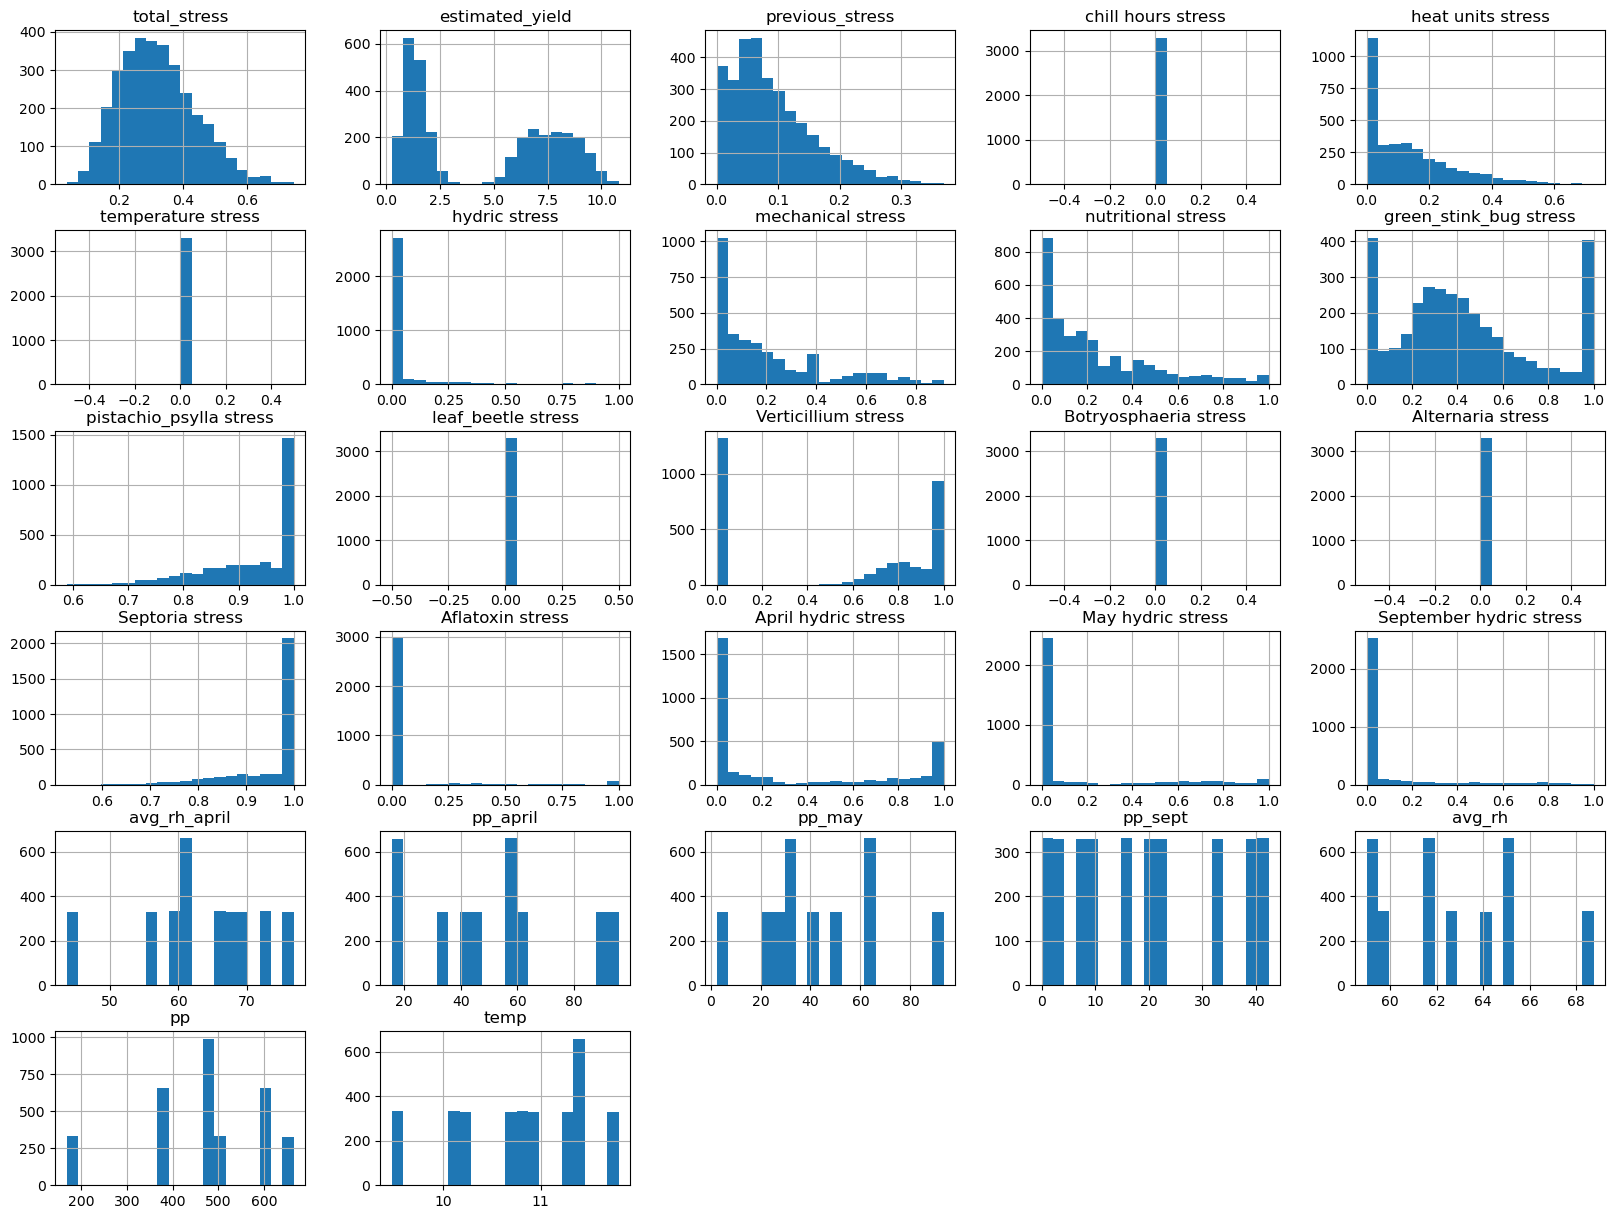

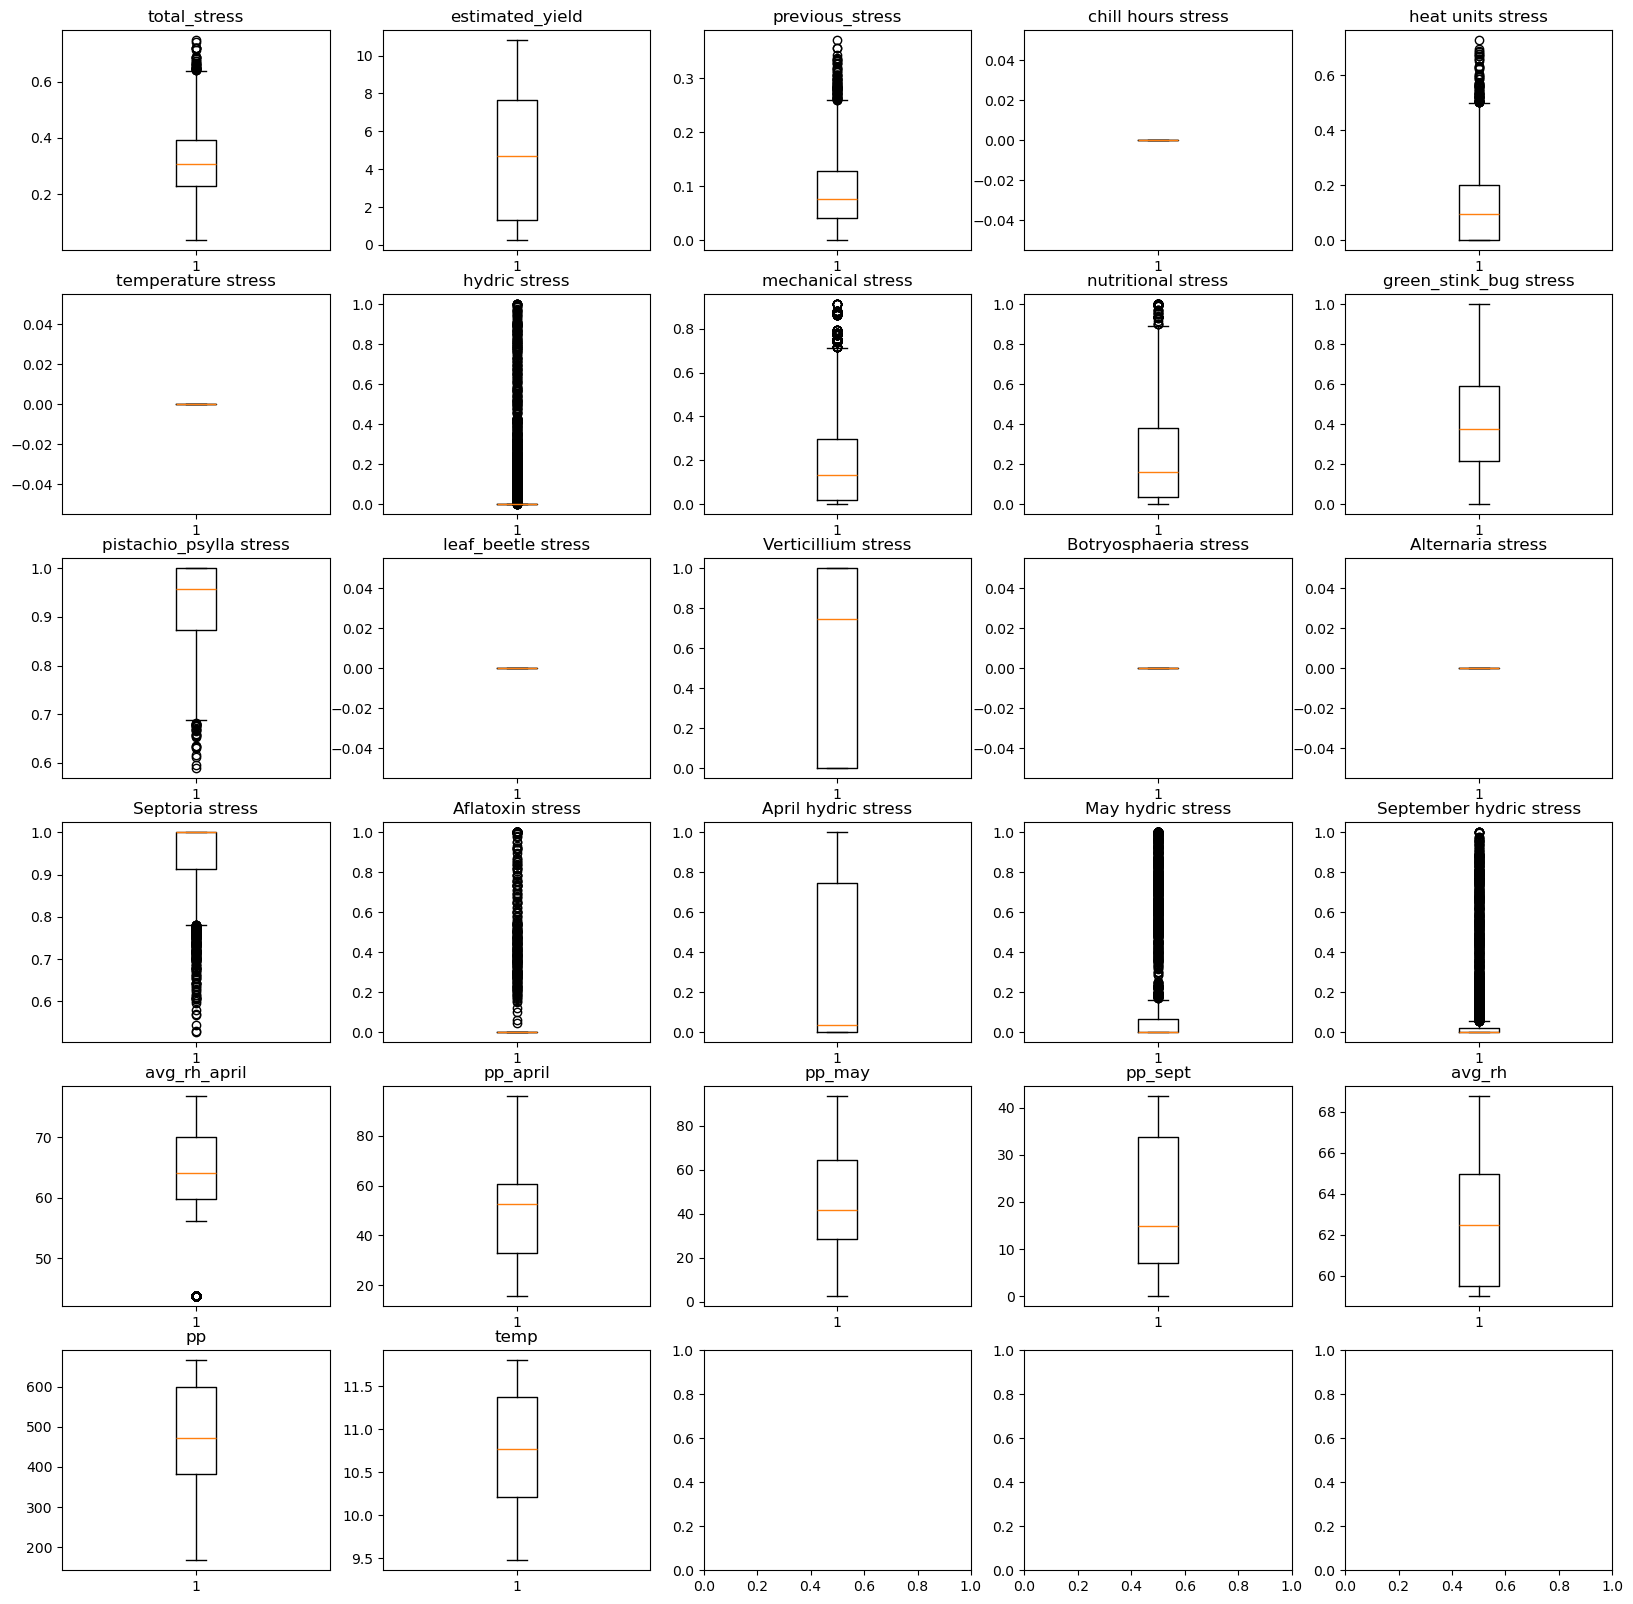

In [48]:
# Distribution of the estimated yield, total stress, previous stress, and stressors
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

numeric_df.hist(bins=20, figsize=(20,15))
plt.show()

# Boxplot of the estimated yield, total stress, previous stress, and stressors
# Do a 6x6 grid of boxplots
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, col in enumerate(numeric_df.columns):
    axs[i//5, i%5].boxplot(numeric_df[col])
    axs[i//5, i%5].set_title(col)

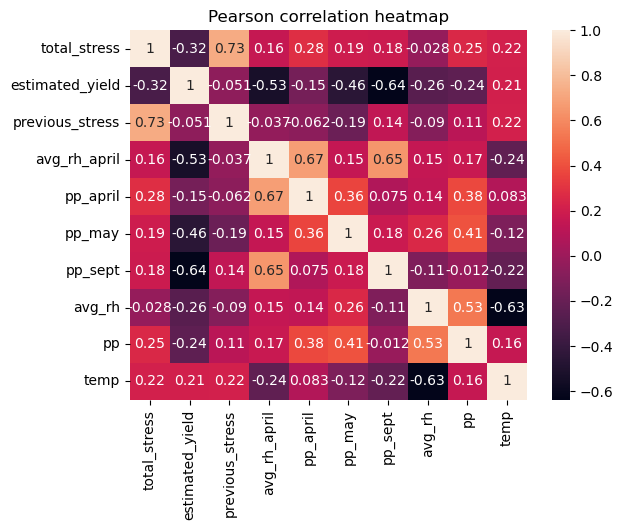

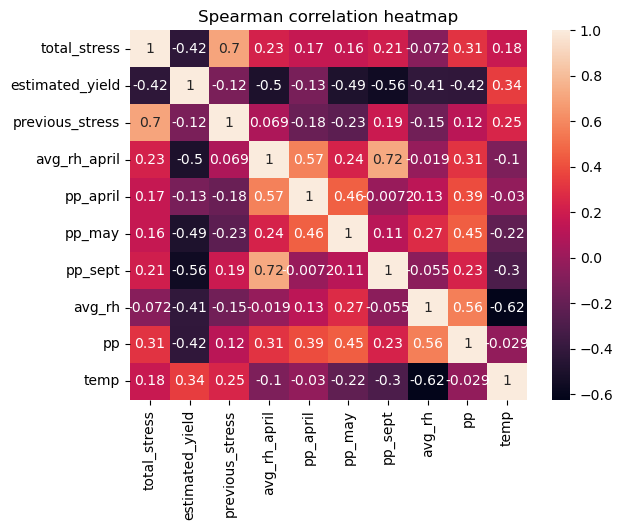

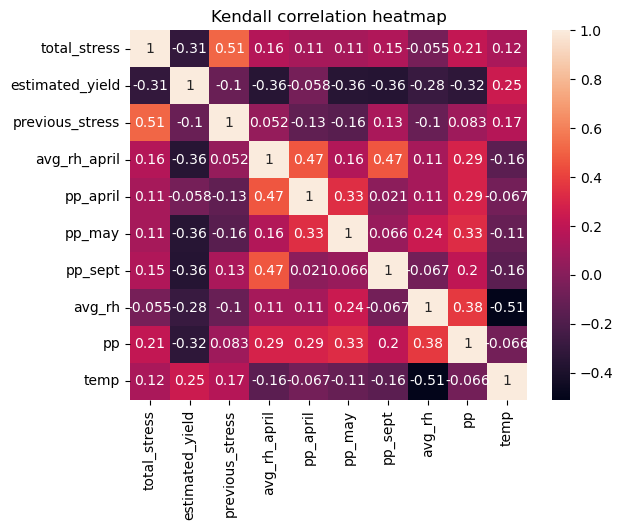

In [49]:
# Heatmap of the correlation between the variables
import seaborn as sns
sns.heatmap(df[["total_stress", "estimated_yield", "previous_stress", "avg_rh_april", "pp_april", "pp_may", "pp_sept", "avg_rh", "pp", "temp"]].corr(method='pearson'), annot=True)
plt.title("Pearson correlation heatmap")
plt.show()
sns.heatmap(df[["total_stress", "estimated_yield", "previous_stress", "avg_rh_april", "pp_april", "pp_may", "pp_sept", "avg_rh", "pp", "temp"]].corr(method='spearman'), annot=True)
plt.title("Spearman correlation heatmap")
plt.show()
sns.heatmap(df[["total_stress", "estimated_yield", "previous_stress", "avg_rh_april", "pp_april", "pp_may", "pp_sept", "avg_rh", "pp", "temp"]].corr(method='kendall'), annot=True)
plt.title("Kendall correlation heatmap")
plt.show()

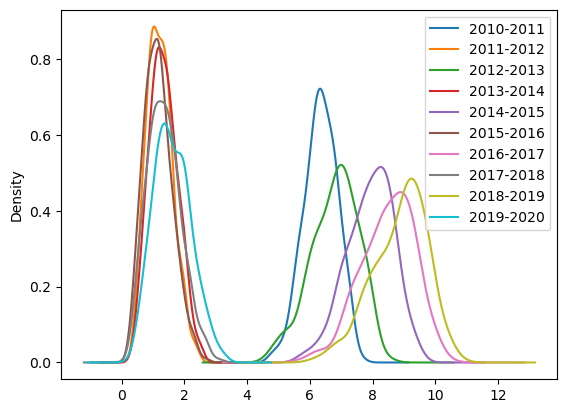

,total_stress,estimated_yield,previous_stress,chill hours stress,heat units stress,temperature stress,hydric stress,mechanical stress,nutritional stress,green_stink_bug stress,...,May hydric stress,September hydric stress,avg_rh_april,pp_april,pp_may,pp_sept,avg_rh,pp,temp,is_on_year
year,,,,,,,,,,,,,,,,,,,,,
2010-2011,0.207106,6.345023,0.000000,0.0,0.112813,0.0,0.000000,0.202415,0.210860,0.469120,...,0.344980,0.000000,59.833333,60.8,64.6,0.0,62.452514,467.2,10.766760,1.0
2011-2012,0.300815,1.220835,0.062247,0.0,0.165672,0.0,0.450607,0.202415,0.399453,0.512415,...,0.000000,0.431873,71.954545,46.2,49.2,42.4,59.490566,167.6,10.169182,0.0
2012-2013,0.276231,6.792023,0.092968,0.0,0.260713,0.0,0.000000,0.202415,0.210860,0.438415,...,0.000000,0.000000,66.400000,59.2,41.8,15.0,68.751497,505.6,9.473952,1.0
2013-2014,0.289717,1.339879,0.087975,0.0,0.195193,0.0,0.000000,0.203028,0.210766,0.611016,...,0.000000,0.000000,61.720000,32.8,23.4,23.0,65.075988,490.0,10.213374,0.0
2014-2015,0.260606,7.916951,0.092980,0.0,0.046406,0.0,0.000000,0.203028,0.210766,0.000000,...,0.000000,0.000000,56.173913,15.8,2.4,7.0,61.913738,383.2,10.915016,1.0
2015-2016,0.428697,1.165957,0.084071,0.0,0.143245,0.0,0.033953,0.202499,0.230291,0.680572,...,0.348480,0.000000,70.100000,95.8,64.8,10.0,64.936639,601.2,11.323140,0.0
2016-2017,0.315311,8.478961,0.134498,0.0,0.040157,0.0,0.000000,0.202499,0.210771,0.206057,...,0.000000,0.000000,43.733333,15.6,30.8,3.6,59.372222,373.8,11.802222,1.0
2017-2018,0.395740,1.353320,0.102679,0.0,0.101292,0.0,0.171320,0.202499,0.285533,0.518725,...,0.791727,0.191857,60.592593,42.4,93.4,33.8,64.284900,665.4,10.650142,0.0
2018-2019,0.391874,8.866463,0.125824,0.0,0.127361,0.0,0.000000,0.202499,0.210771,0.385945,...,0.000000,0.000000,68.200000,89.2,28.5,21.2,58.988827,472.8,11.374302,1.0


In [50]:
# Plot distribution grouped by year
import matplotlib.pyplot as plt
df.groupby("year").estimated_yield.plot(kind="kde", legend=True)
plt.show()

# Group by year and get the mean and add count column
# df_grouped = df.groupby("year").agg(
#     total_stress_mean=("total_stress", "mean"),
#     estimated_yield_mean=("estimated_yield", "mean"),
#     previous_stress_mean=("previous_stress", "mean"),
#     count=("estimated_yield", "count")
# )
df_grouped = df.groupby("year").mean()
display(df_grouped)


## Feed an AI model with the data

Now that we have the best model possible for the real data, we can feed an AI model with the data to predict the yield of the pistachio crop in the future. We are going to test different models and compare the results. 

In [53]:
test_size = 0.2

# Split the data into train and test
data = df_grouped.copy()
# Put estimated_yield at the end
data = data[[c for c in data if c not in ["estimated_yield"]] + ["estimated_yield"]]

In [51]:
# Functions
def metrics_and_plots(y_true, y_pred, X_test, only_metrics=False):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.metrics import mean_squared_error, r2_score
    import seaborn as sns
    # Metrics
    from sklearn.metrics import mean_squared_error, r2_score
    import statistics as stat
    # Remove hours 1-7
    y_true_df = pd.DataFrame(y_true)
    y_pred_df = pd.DataFrame(y_pred)
    # Rename 
    y_pred_df.columns = ['liters']
    y_true_df.columns = ['liters']
    print('R2:', r2_score(y_true_df["liters"], y_pred_df["liters"]))
    print('RMSE:', mean_squared_error(y_true_df["liters"], y_pred_df["liters"], squared=False))
    print('Max error:', max(abs(y_true_df["liters"] - y_pred_df["liters"])))
    print('Error median:', np.median(abs(y_true_df["liters"] - y_pred_df["liters"])))
    print('Error std:', np.std(abs(y_true_df["liters"] - y_pred_df["liters"])))
    # Accuracy (inside 10%/25% error)
    print('Accuracy (<10%):', len(y_true_df[(abs(y_true_df["liters"] - y_pred_df["liters"]) / y_true_df["liters"]) < 0.1]) / len(y_true_df))
    print('Accuracy (<25%):', len(y_true_df[(abs(y_true_df["liters"] - y_pred_df["liters"]) / y_true_df["liters"]) < 0.25]) / len(y_true_df))

    if only_metrics:
        return
    # Plot error by day of the week
    error = abs(y_true.ravel() - y_pred.ravel())
    error = pd.DataFrame(error)
    # Group by day of the week
    error['dayOfWeek'] = X_test[:, 5]
    error['hour'] = X_test[:, -1]
    # Filter by hours distinct to 1-7
    error = error[~error['hour'].isin([1, 2, 3, 4, 5, 6, 7])]
    # Group by hour
    error_mean = error.drop(columns=['dayOfWeek']).groupby('hour').mean()
    error_var = error.drop(columns=['dayOfWeek']).groupby('hour').std()
    # Plot all errors
    fig, axs = plt.subplots(1, 2, figsize=(23, 4))
    error_mean.plot(kind='bar', title='Error medio por hora - Horas distintas a 1-7', ax=axs[0])
    error_var.plot(kind='bar', title='Error varianza por hora - Horas distintas a 1-7', ax=axs[1])
    # Group by day of the week
    error = error.drop(columns=['hour'])
    error_mean = error.groupby('dayOfWeek').mean()
    error_var = error.groupby('dayOfWeek').std()
    # Plot all errors
    fig, axs = plt.subplots(1, 2, figsize=(23, 4))
    error_mean.plot(kind='bar', title='Error medio por día de la semana - Horas distintas a 1-7', ax=axs[0])
    error_var.plot(kind='bar', title='Error varianza por día de la semana - Horas distintas a 1-7', ax=axs[1])
    # Plot number of errors by group of errors
    plt.figure()
    error['group'] = pd.cut(error[0], bins=[0, 5, 10, 15, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000], right=False)
    error_group = error.groupby('group').size()
    error_group.plot(kind='bar', title='Número de errores por grupo de error - Horas distintas a 1-7', figsize=(18, 5))
    # New variable weekend and weekday
    y_true_df['Weekend'] = y_true_df['dayOfWeek'].apply(lambda x: "Fin de semana" if x in [5, 6] else "Entre semana")
    # Plot real vs predicted hue weekend
    plt.figure()
    sns.scatterplot(data=y_true_df, x='liters', y=y_pred_df['liters'], hue='Weekend')
    plt.title('Real vs Predicted - day of the week')
    plt.xlabel('Real')
    plt.ylabel('Predicted')
    plt.legend()
    plt.show()

def plot_residuals(y_test, y_pred):
    # Residuals qqplot
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    # Calculate residuals
    residuals = y_test.ravel() - y_pred
    # QQ plot
    fig, axes = plt.subplots(1, 2, figsize=(25, 6), gridspec_kw={'width_ratios': [2, 3]})
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=axes[0])
    axes[0].set_title('QQ plot')
    axes[1].set_title('residuals')
    axes[1].plot(residuals)

### XGBoost

/Users/topopelon/miniconda3/envs/pistachio-simulation/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


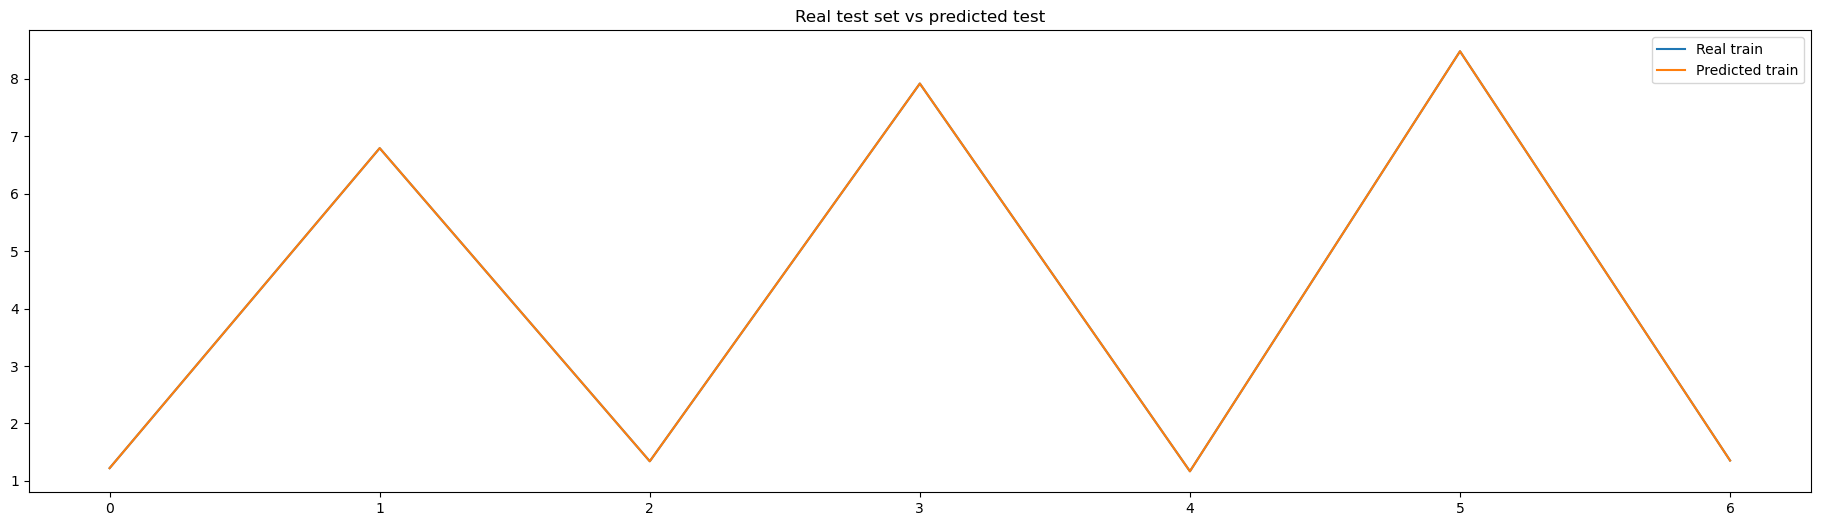

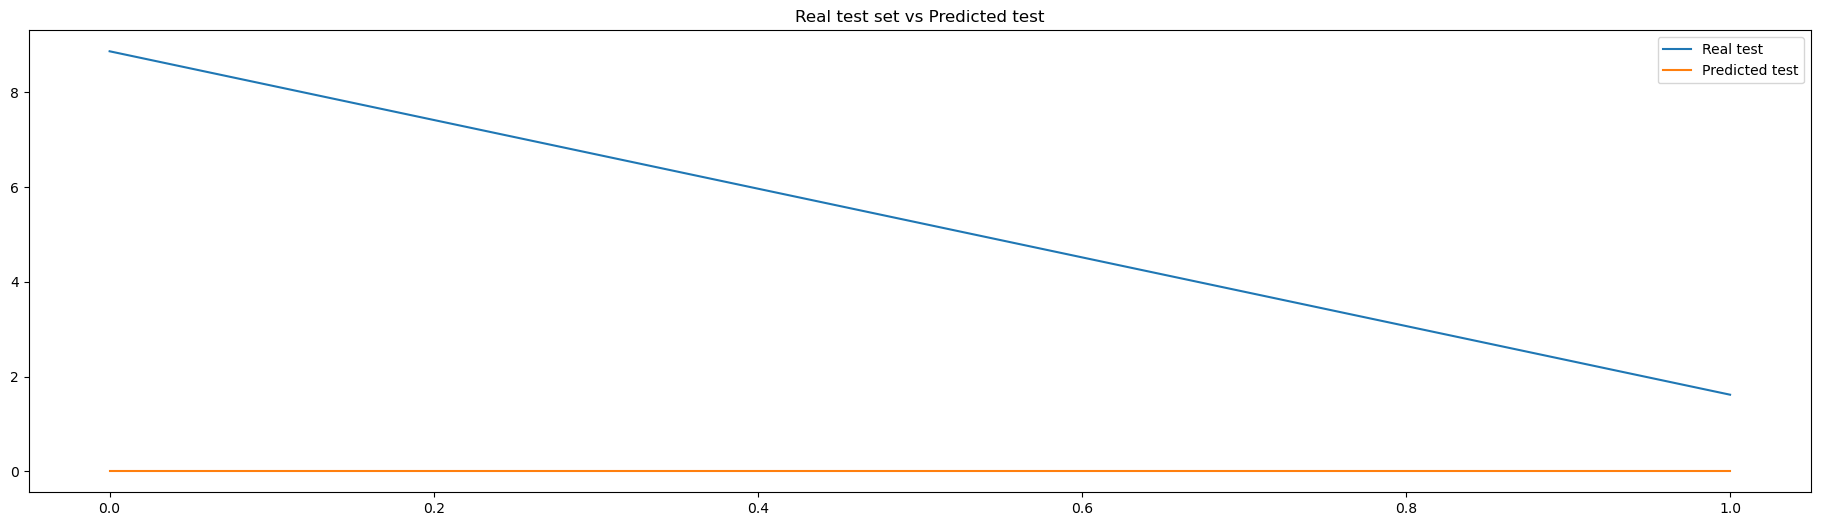

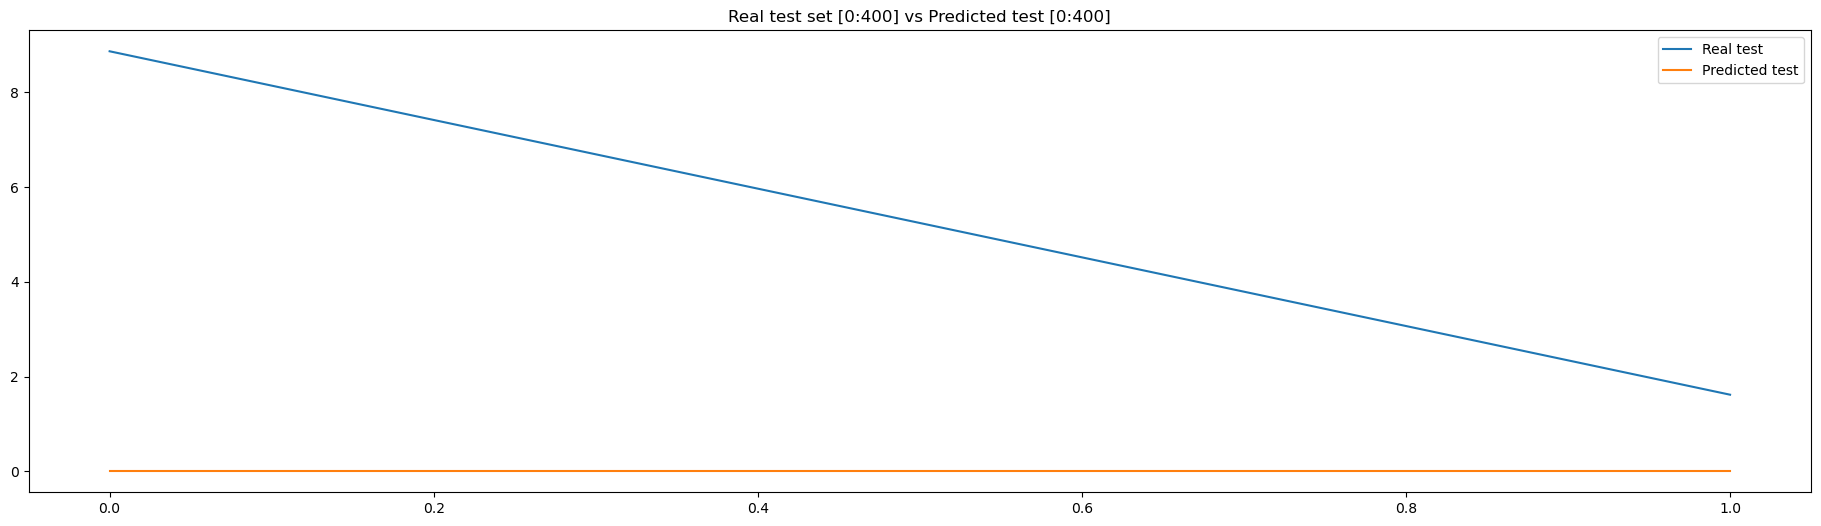

R2: -2.0907639330591326
RMSE: 6.372886543930556
Max error: 8.866462576361329
Error median: 5.241502156393528
Error std: 3.6249604199678003
Accuracy (<10%): 0.0
Accuracy (<25%): 0.0


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import xgboost
# Bayesian Ridge
from sklearn.linear_model import BayesianRidge

# Scale
# scaler = StandardScaler()
# Drop NaN
data = data.dropna()
# Split data
def split_sequence(sequence, n_steps_in, n_steps_out):
    '''
    Split data into sequences of length n_steps_in. This is the sliding window approach
    where we use the last n_steps_in values to predict the next n_steps_out. In this case,
    we only need to predict the next value. You can uncommnet the `print(f'{seq_x} => {seq_y}')`
    statement to see the windows created and the corresponding output.
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix+n_steps_out-1:out_end_ix, -1]
        # seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
        # print(f'{seq_x} => {seq_y}')
    return np.array(X), np.array(y)

X, y = split_sequence(data.values, 1, 1)
X = X.reshape((X.shape[0], -1))
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
# Scale
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# Best params in optuna
# params = {
#     'n_estimators': 5000,
#     'max_depth': 7,
#     'learning_rate': 0.0008313896119288818,
#     'gamma': 0.007851369783179437,
#     'subsample': 0.8180179222776849,
#     'colsample_bytree': 0.6021960309532763,
#     'random_state': 123,
#     'enable_categorical': True,
# }
model = BayesianRidge()
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
# y_pred < 100 = 0.
y_pred[y_pred < 100] = 0
# Plot real vs predicted
plt.figure(figsize=(23, 6))
plt.title('Real test set vs predicted test')
plt.plot(y_train.ravel(), label='Real train')
plt.plot(y_pred_train.ravel(), label='Predicted train')
plt.legend()
plt.show()

plt.figure(figsize=(23, 6))
plt.title("Real test set vs Predicted test")
plt.plot(y_test.ravel(), label='Real test')
plt.plot(y_pred.ravel(), label='Predicted test')
plt.legend()
plt.show()
# Close up
plt.figure(figsize=(23, 6))
plt.title("Real test set [0:400] vs Predicted test [0:400]")
plt.plot(y_test.ravel()[0:400], label='Real test')
plt.plot(y_pred.ravel()[0:400], label='Predicted test')
plt.legend()
plt.show()
# Metrics
metrics_and_plots(y_test.ravel(), y_pred.ravel(), np.array(X_test), only_metrics=True)
# Residuals
# plot_residuals(y_test, y_pred)